In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model

import keras

import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score
)

from imblearn.over_sampling import SMOTE

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Load the dataset
df = pd.read_csv("datasets/3. online_shoppers_intention_clean.csv")

# 2. Select relevant columns
# df = df[[
#     "Administrative", "Informational", "ProductRelated",
#     "BounceRates", "ExitRates", "PageValues", "Month",
#     "TrafficType", "VisitorType", "Revenue"
# ]]

# 3. Separate input features and target
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# 4. Split the data into train_val and test sets (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Split the train_val into training and validation sets (75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 x 0.8 = 0.2

# 6. Define numerical and categorical columns
numerical_features = [
    "Administrative",
    "Administrative_Duration",
    "Informational",
    "Informational_Duration",
    "ProductRelated",
    "ProductRelated_Duration",
    "BounceRates",
    "ExitRates",
    "PageValues",
    "SpecialDay"
]
categorical_features = [
    "Month",
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "VisitorType",
    "Weekend"
]

# 7. Preprocess numerical features
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[numerical_features])

# Transform the numerical features
X_train_scaled = min_max_scaler.transform(X_train[numerical_features])
X_val_scaled = min_max_scaler.transform(X_val[numerical_features])
X_test_scaled = min_max_scaler.transform(X_test[numerical_features])

# Convert scaled arrays back to dataframes for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test.index)

# 8. Preprocess categorical features
# Initialise the OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False turns the data into NumPy array

# Fit the encoder on the training data
one_hot_encoder.fit(X_train[categorical_features])

# Transform the categorical features
X_train_encoded = one_hot_encoder.transform(X_train[categorical_features])
X_val_encoded = one_hot_encoder.transform(X_val[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Get the new feature names after one-hot encoding
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Convert encoded arrays back to dataframes
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_feature_names, index=X_val.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# 9. Combine processed features
X_train_processed = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_val_processed = pd.concat([X_val_scaled, X_val_encoded], axis=1)
X_test_processed = pd.concat([X_test_scaled, X_test_encoded], axis=1)

# Verify the shapes
print("Processed Training Data Shape:", X_train_processed.shape)
print("Processed Validation Data Shape:", X_val_processed.shape)
print("Processed Test Data Shape:", X_test_processed.shape)

# 10. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Verify the resampled data
print("Resampled Training Data Shape:", X_train_resampled.shape)
print("Resampled Training Target Distribution:\n", y_train_resampled.value_counts())

# 11. Reset indices
X_train_resampled.reset_index(drop=True, inplace=True)
y_train_resampled.reset_index(drop=True, inplace=True)

X_val_processed.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_test_processed.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 12. Final verification
print("Final Training Data Shape:", X_train_resampled.shape)
print("Final Validation Data Shape:", X_val_processed.shape)
print("Final Test Data Shape:", X_test_processed.shape)

Processed Training Data Shape: (7334, 74)
Processed Validation Data Shape: (2445, 74)
Processed Test Data Shape: (2445, 74)
Resampled Training Data Shape: (12378, 74)
Resampled Training Target Distribution:
 Revenue
False    6189
True     6189
Name: count, dtype: int64
Final Training Data Shape: (12378, 74)
Final Validation Data Shape: (2445, 74)
Final Test Data Shape: (2445, 74)


# WARNING: DO NOT RUN THE CELL BELOW IF YOU DO NOT WANT TO RUN OPTIMISATION, AS IT MAY TAKE HOURS TO DAYS TO COMPLETE

In [ ]:
# 13. Set seed for reproducability
keras.utils.set_random_seed(42)

# 14. Define the function to create NN model
def create_model(trial):
    # Hyperparameters to tune
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    n_neurons = trial.suggest_int('n_neurons', 16, 128) 
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Add input layer
    model.add(Input(shape=(X_train_resampled.shape[1],)))  # Dynamically adjusts based on the number of columns of the dataset
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for i in range(n_hidden_layers - 1):  # -1 as already added the first layer
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate)) # Add dropout layer to minimise overfitting
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 15. Define the objective function for Optuna
def objective(trial):
    try:
        # Create the model
        model = create_model(trial)
        
        # Suggest batch size
        batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128])
        
        # Define early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20
        )
        
        # Train the model
        history = model.fit(
            X_train_resampled, y_train_resampled,
            validation_data=(X_val_processed, y_val),
            epochs=100, 
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0 
        )
        
        # Evaluate the model on validation data
        score = model.evaluate(X_val_processed, y_val, verbose=0)
        return score[1]  # Return validation accuracy

    finally:
        # Clear keras session to free memory
        K.clear_session()

# 16. Create the study
study_name = "neural_network_optimisation_3"
storage_name = "sqlite:///optuna_study_neural_network_3.db" # Use .db so that a record store of all trials will be saved

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42))  

# 17. Optimise the study objective function with 1000 trials
study.optimize(objective, n_trials=1000, timeout=None, show_progress_bar=True)

# 18. Retrieve and display the best trial
print("\nBest trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.4f}")
print("  Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-20 15:10:34,994] A new study created in RDB with name: neural_network_optimisation_3
  0%|          | 0/1000 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.671575:   0%|          | 1/1000 [04:23<73:05:44, 263.41s/it]

[I 2024-10-20 15:14:58,398] Trial 0 finished with value: 0.6715746521949768 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 2.9380279387035334e-05, 'optimizer': 'sgd', 'dropout_rate': 0.34044600469728353, 'n_neurons': 96, 'batch_size': 2}. Best is trial 0 with value: 0.6715746521949768.


Best trial: 0. Best value: 0.671575:   0%|          | 2/1000 [04:37<32:23:50, 116.86s/it]

[I 2024-10-20 15:15:12,683] Trial 1 finished with value: 0.6110429167747498 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 7.52374288453485e-05, 'optimizer': 'sgd', 'dropout_rate': 0.1798695128633439, 'n_neurons': 74, 'batch_size': 64}. Best is trial 0 with value: 0.6715746521949768.


Best trial: 0. Best value: 0.671575:   0%|          | 3/1000 [05:15<22:19:43, 80.63s/it] 

[I 2024-10-20 15:15:50,184] Trial 2 finished with value: 0.5938650369644165 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 2.32335035153901e-05, 'optimizer': 'sgd', 'dropout_rate': 0.20351199264000677, 'n_neurons': 90, 'batch_size': 16}. Best is trial 0 with value: 0.6715746521949768.


Best trial: 3. Best value: 0.753374:   0%|          | 4/1000 [05:39<16:09:19, 58.39s/it]

[I 2024-10-20 15:16:14,494] Trial 3 finished with value: 0.7533742189407349 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 1.3667272915456215e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.43149500366077176, 'n_neurons': 56, 'batch_size': 32}. Best is trial 3 with value: 0.7533742189407349.


Best trial: 4. Best value: 0.870348:   0%|          | 5/1000 [05:43<10:43:16, 38.79s/it]

[I 2024-10-20 15:16:18,528] Trial 4 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0020597335357437196, 'optimizer': 'rmsprop', 'dropout_rate': 0.4452413703502375, 'n_neurons': 86, 'batch_size': 64}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 6/1000 [06:00<8:36:55, 31.20s/it] 

[I 2024-10-20 15:16:35,000] Trial 5 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.002055424552015075, 'optimizer': 'rmsprop', 'dropout_rate': 0.11016765069763808, 'n_neurons': 28, 'batch_size': 16}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 7/1000 [07:00<11:15:22, 40.81s/it]

[I 2024-10-20 15:17:35,584] Trial 6 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006153085601625313, 'optimizer': 'sgd', 'dropout_rate': 0.4214688307596458, 'n_neurons': 37, 'batch_size': 8}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 8/1000 [07:16<9:04:41, 32.94s/it] 

[I 2024-10-20 15:17:51,693] Trial 7 finished with value: 0.5832310914993286 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.000178744632562384, 'optimizer': 'sgd', 'dropout_rate': 0.47716388156500766, 'n_neurons': 52, 'batch_size': 8}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 9/1000 [15:29<48:38:24, 176.69s/it]

[I 2024-10-20 15:26:04,468] Trial 8 finished with value: 0.8212679028511047 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 1.4270403521460843e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.15795794883648925, 'n_neurons': 71, 'batch_size': 1}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 10/1000 [15:42<34:39:35, 126.04s/it]

[I 2024-10-20 15:26:17,072] Trial 9 finished with value: 0.5177913904190063 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 9.169384722192322e-05, 'optimizer': 'sgd', 'dropout_rate': 0.37102574473691297, 'n_neurons': 17, 'batch_size': 64}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 11/1000 [15:46<24:25:33, 88.91s/it] 

[I 2024-10-20 15:26:21,803] Trial 10 finished with value: 0.8376278281211853 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.001082725997676882, 'optimizer': 'adam', 'dropout_rate': 0.2758541800454106, 'n_neurons': 118, 'batch_size': 128}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|          | 12/1000 [15:58<17:57:16, 65.42s/it]

[I 2024-10-20 15:26:33,500] Trial 11 finished with value: 0.8535787463188171 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0014090261742891953, 'optimizer': 'rmsprop', 'dropout_rate': 0.10687112498408052, 'n_neurons': 24, 'batch_size': 16}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 4. Best value: 0.870348:   1%|▏         | 13/1000 [16:30<15:12:03, 55.44s/it]

[I 2024-10-20 15:27:05,985] Trial 12 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0006630599890152523, 'optimizer': 'rmsprop', 'dropout_rate': 0.2604603292118235, 'n_neurons': 117, 'batch_size': 4}. Best is trial 4 with value: 0.8703476190567017.


Best trial: 13. Best value: 0.873211:   1%|▏         | 14/1000 [16:34<10:52:14, 39.69s/it]

[I 2024-10-20 15:27:09,275] Trial 13 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005045365190356968, 'optimizer': 'rmsprop', 'dropout_rate': 0.4862778301767896, 'n_neurons': 97, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 15/1000 [16:37<7:52:46, 28.80s/it] 

[I 2024-10-20 15:27:12,830] Trial 14 finished with value: 0.8388547897338867 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009956055660659066, 'optimizer': 'adam', 'dropout_rate': 0.48088370397047187, 'n_neurons': 97, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 16/1000 [16:41<5:49:56, 21.34s/it]

[I 2024-10-20 15:27:16,841] Trial 15 finished with value: 0.8552147150039673 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.00366088776192469, 'optimizer': 'rmsprop', 'dropout_rate': 0.49840679574448554, 'n_neurons': 128, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 17/1000 [16:47<4:31:57, 16.60s/it]

[I 2024-10-20 15:27:22,424] Trial 16 finished with value: 0.8535787463188171 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0004077596608811986, 'optimizer': 'rmsprop', 'dropout_rate': 0.4146511487079995, 'n_neurons': 82, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 18/1000 [17:55<8:45:37, 32.12s/it]

[I 2024-10-20 15:28:30,658] Trial 17 finished with value: 0.8143149018287659 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0030464773406747394, 'optimizer': 'rmsprop', 'dropout_rate': 0.3550291001293532, 'n_neurons': 104, 'batch_size': 2}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 19/1000 [18:01<6:38:00, 24.34s/it]

[I 2024-10-20 15:28:36,896] Trial 18 finished with value: 0.8466257452964783 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006937482239640232, 'optimizer': 'adam', 'dropout_rate': 0.4538212180144964, 'n_neurons': 59, 'batch_size': 32}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 20/1000 [18:05<4:55:19, 18.08s/it]

[I 2024-10-20 15:28:40,381] Trial 19 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0007516850513426535, 'optimizer': 'rmsprop', 'dropout_rate': 0.38871462705344517, 'n_neurons': 106, 'batch_size': 128}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 21/1000 [20:01<12:54:06, 47.44s/it]

[I 2024-10-20 15:30:36,280] Trial 20 finished with value: 0.8425357937812805 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0041946462124574065, 'optimizer': 'rmsprop', 'dropout_rate': 0.32022777832012783, 'n_neurons': 82, 'batch_size': 1}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 22/1000 [20:05<9:19:28, 34.32s/it] 

[I 2024-10-20 15:30:40,008] Trial 21 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0006617288313652909, 'optimizer': 'rmsprop', 'dropout_rate': 0.38649925118943673, 'n_neurons': 109, 'batch_size': 128}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 23/1000 [20:08<6:45:46, 24.92s/it]

[I 2024-10-20 15:30:42,996] Trial 22 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0020192520984696526, 'optimizer': 'rmsprop', 'dropout_rate': 0.4506404929898924, 'n_neurons': 108, 'batch_size': 128}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▏         | 24/1000 [20:48<8:01:53, 29.62s/it]

[I 2024-10-20 15:31:23,595] Trial 23 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00029813359231864467, 'optimizer': 'rmsprop', 'dropout_rate': 0.39743099030235557, 'n_neurons': 90, 'batch_size': 4}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   2%|▎         | 25/1000 [21:28<8:52:45, 32.79s/it]

[I 2024-10-20 15:32:03,753] Trial 24 finished with value: 0.8417177796363831 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00024920875447357097, 'optimizer': 'rmsprop', 'dropout_rate': 0.4601759275264728, 'n_neurons': 87, 'batch_size': 4}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 26/1000 [22:23<10:39:56, 39.42s/it]

[I 2024-10-20 15:32:58,656] Trial 25 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0001617921130824836, 'optimizer': 'adam', 'dropout_rate': 0.40969544530575464, 'n_neurons': 72, 'batch_size': 4}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 27/1000 [24:02<15:30:09, 57.36s/it]

[I 2024-10-20 15:34:37,835] Trial 26 finished with value: 0.8515337705612183 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.002013360529595247, 'optimizer': 'rmsprop', 'dropout_rate': 0.2947560566618453, 'n_neurons': 95, 'batch_size': 4}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 28/1000 [24:37<13:40:24, 50.64s/it]

[I 2024-10-20 15:35:12,810] Trial 27 finished with value: 0.8261758685112 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 7.868710149303334e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.49773369114692423, 'n_neurons': 66, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 29/1000 [24:58<11:15:13, 41.72s/it]

[I 2024-10-20 15:35:33,746] Trial 28 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0004127533709336261, 'optimizer': 'rmsprop', 'dropout_rate': 0.44355972877949, 'n_neurons': 80, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 30/1000 [25:15<9:12:35, 34.18s/it] 

[I 2024-10-20 15:35:50,326] Trial 29 finished with value: 0.8568507432937622 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.001245698894122832, 'optimizer': 'adam', 'dropout_rate': 0.3356133709270177, 'n_neurons': 80, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 31/1000 [27:55<19:24:18, 72.09s/it]

[I 2024-10-20 15:38:30,882] Trial 30 finished with value: 0.8417177796363831 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0005028359764523389, 'optimizer': 'rmsprop', 'dropout_rate': 0.44033388205629104, 'n_neurons': 44, 'batch_size': 2}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 32/1000 [28:35<16:43:48, 62.22s/it]

[I 2024-10-20 15:39:10,060] Trial 31 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0002868804143676687, 'optimizer': 'rmsprop', 'dropout_rate': 0.398295237752685, 'n_neurons': 98, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 33/1000 [29:15<14:55:37, 55.57s/it]

[I 2024-10-20 15:39:50,120] Trial 32 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 4.8821113729376007e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.46966813712641803, 'n_neurons': 98, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   3%|▎         | 34/1000 [29:36<12:07:55, 45.21s/it]

[I 2024-10-20 15:40:11,169] Trial 33 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0001228478861721363, 'optimizer': 'rmsprop', 'dropout_rate': 0.44463700598086137, 'n_neurons': 77, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   4%|▎         | 35/1000 [29:42<9:00:18, 33.59s/it] 

[I 2024-10-20 15:40:17,649] Trial 34 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.005549408623832575, 'optimizer': 'rmsprop', 'dropout_rate': 0.3671237715094688, 'n_neurons': 88, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 13. Best value: 0.873211:   4%|▎         | 36/1000 [30:16<9:01:06, 33.68s/it]

[I 2024-10-20 15:40:51,526] Trial 35 finished with value: 0.8462167978286743 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.006179405441509618, 'optimizer': 'sgd', 'dropout_rate': 0.35760528895424176, 'n_neurons': 89, 'batch_size': 64}. Best is trial 13 with value: 0.873210608959198.


Best trial: 36. Best value: 0.878528:   4%|▎         | 37/1000 [30:28<7:16:50, 27.22s/it]

[I 2024-10-20 15:41:03,663] Trial 36 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027820103815779417, 'optimizer': 'rmsprop', 'dropout_rate': 0.32166869872241877, 'n_neurons': 100, 'batch_size': 64}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 38/1000 [31:33<10:19:24, 38.63s/it]

[I 2024-10-20 15:42:08,926] Trial 37 finished with value: 0.8400818109512329 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002825274151247492, 'optimizer': 'sgd', 'dropout_rate': 0.24215488569450672, 'n_neurons': 115, 'batch_size': 32}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 39/1000 [31:43<7:57:42, 29.83s/it] 

[I 2024-10-20 15:42:18,204] Trial 38 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.009728458109831747, 'optimizer': 'rmsprop', 'dropout_rate': 0.31866210408280743, 'n_neurons': 101, 'batch_size': 64}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 40/1000 [32:47<10:41:42, 40.11s/it]

[I 2024-10-20 15:43:22,285] Trial 39 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.004514398416231697, 'optimizer': 'rmsprop', 'dropout_rate': 0.23976246271017948, 'n_neurons': 62, 'batch_size': 8}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 41/1000 [34:41<16:33:55, 62.19s/it]

[I 2024-10-20 15:45:16,011] Trial 40 finished with value: 0.798363983631134 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0024200829128747706, 'optimizer': 'sgd', 'dropout_rate': 0.19740582179150878, 'n_neurons': 93, 'batch_size': 16}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 42/1000 [34:50<12:22:46, 46.52s/it]

[I 2024-10-20 15:45:25,977] Trial 41 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.005142539742007751, 'optimizer': 'rmsprop', 'dropout_rate': 0.3762486287023439, 'n_neurons': 86, 'batch_size': 64}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 43/1000 [35:01<9:32:02, 35.86s/it] 

[I 2024-10-20 15:45:36,975] Trial 42 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.005082054430780745, 'optimizer': 'rmsprop', 'dropout_rate': 0.3649243849802013, 'n_neurons': 86, 'batch_size': 64}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 44/1000 [35:11<7:24:01, 27.87s/it]

[I 2024-10-20 15:45:46,183] Trial 43 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00655010373618367, 'optimizer': 'rmsprop', 'dropout_rate': 0.3363794467036925, 'n_neurons': 68, 'batch_size': 64}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 36. Best value: 0.878528:   4%|▍         | 45/1000 [40:38<31:13:56, 117.73s/it]

[I 2024-10-20 15:51:13,614] Trial 44 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.007565315121653061, 'optimizer': 'rmsprop', 'dropout_rate': 0.2981178393965264, 'n_neurons': 66, 'batch_size': 1}. Best is trial 36 with value: 0.8785275816917419.


Best trial: 45. Best value: 0.878937:   5%|▍         | 46/1000 [40:50<22:47:55, 86.03s/it] 

[I 2024-10-20 15:51:25,670] Trial 45 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0052812129953266895, 'optimizer': 'rmsprop', 'dropout_rate': 0.33579232042999985, 'n_neurons': 51, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▍         | 47/1000 [41:04<17:00:22, 64.24s/it]

[I 2024-10-20 15:51:39,063] Trial 46 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003704358742760039, 'optimizer': 'rmsprop', 'dropout_rate': 0.3296678184805949, 'n_neurons': 47, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▍         | 48/1000 [42:09<17:05:14, 64.62s/it]

[I 2024-10-20 15:52:44,562] Trial 47 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016693649932124875, 'optimizer': 'rmsprop', 'dropout_rate': 0.31324898619325975, 'n_neurons': 50, 'batch_size': 8}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▍         | 49/1000 [42:15<12:24:18, 46.96s/it]

[I 2024-10-20 15:52:50,323] Trial 48 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0037089363884501183, 'optimizer': 'adam', 'dropout_rate': 0.2534562038770454, 'n_neurons': 36, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▌         | 50/1000 [43:57<16:43:42, 63.39s/it]

[I 2024-10-20 15:54:32,058] Trial 49 finished with value: 0.8552147150039673 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0010094507279170331, 'optimizer': 'rmsprop', 'dropout_rate': 0.2839930922074049, 'n_neurons': 35, 'batch_size': 2}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▌         | 51/1000 [44:32<14:29:03, 54.95s/it]

[I 2024-10-20 15:55:07,293] Trial 50 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030948319119704186, 'optimizer': 'sgd', 'dropout_rate': 0.2737338824996791, 'n_neurons': 43, 'batch_size': 16}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▌         | 52/1000 [44:36<10:29:01, 39.81s/it]

[I 2024-10-20 15:55:11,794] Trial 51 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.007985673857896187, 'optimizer': 'rmsprop', 'dropout_rate': 0.3338583018054579, 'n_neurons': 47, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▌         | 53/1000 [44:42<7:46:12, 29.54s/it] 

[I 2024-10-20 15:55:17,360] Trial 52 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.008559819535226679, 'optimizer': 'rmsprop', 'dropout_rate': 0.3457088733735487, 'n_neurons': 52, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   5%|▌         | 54/1000 [44:46<5:46:20, 21.97s/it]

[I 2024-10-20 15:55:21,662] Trial 53 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.008227261347151973, 'optimizer': 'rmsprop', 'dropout_rate': 0.14667978108934598, 'n_neurons': 53, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 55/1000 [44:50<4:21:41, 16.61s/it]

[I 2024-10-20 15:55:25,787] Trial 54 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.008687764233573161, 'optimizer': 'rmsprop', 'dropout_rate': 0.34398981972639586, 'n_neurons': 46, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 56/1000 [44:58<3:38:43, 13.90s/it]

[I 2024-10-20 15:55:33,362] Trial 55 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.009559751575859645, 'optimizer': 'rmsprop', 'dropout_rate': 0.3487236598697274, 'n_neurons': 46, 'batch_size': 32}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 57/1000 [45:03<2:57:44, 11.31s/it]

[I 2024-10-20 15:55:38,620] Trial 56 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003568588907036059, 'optimizer': 'rmsprop', 'dropout_rate': 0.3124774813687082, 'n_neurons': 27, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 58/1000 [45:08<2:25:06,  9.24s/it]

[I 2024-10-20 15:55:43,039] Trial 57 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.007581217841614077, 'optimizer': 'rmsprop', 'dropout_rate': 0.3301648978630239, 'n_neurons': 57, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 59/1000 [48:33<17:49:21, 68.18s/it]

[I 2024-10-20 15:59:08,756] Trial 58 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002556754460043617, 'optimizer': 'rmsprop', 'dropout_rate': 0.32459031999493043, 'n_neurons': 56, 'batch_size': 1}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 60/1000 [48:38<12:51:39, 49.25s/it]

[I 2024-10-20 15:59:13,841] Trial 59 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004259735072946604, 'optimizer': 'adam', 'dropout_rate': 0.35078221336301174, 'n_neurons': 39, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 61/1000 [48:44<9:23:48, 36.03s/it] 

[I 2024-10-20 15:59:19,000] Trial 60 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0071387696096366585, 'optimizer': 'rmsprop', 'dropout_rate': 0.3783574060598089, 'n_neurons': 61, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▌         | 62/1000 [48:48<6:54:44, 26.53s/it]

[I 2024-10-20 15:59:23,371] Trial 61 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.008329606862882444, 'optimizer': 'rmsprop', 'dropout_rate': 0.33365053629507135, 'n_neurons': 48, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▋         | 63/1000 [48:53<5:12:41, 20.02s/it]

[I 2024-10-20 15:59:28,211] Trial 62 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0053510589645174795, 'optimizer': 'rmsprop', 'dropout_rate': 0.28787950127194023, 'n_neurons': 56, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▋         | 64/1000 [48:57<4:00:36, 15.42s/it]

[I 2024-10-20 15:59:32,903] Trial 63 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.008506822962058206, 'optimizer': 'rmsprop', 'dropout_rate': 0.3062411199002927, 'n_neurons': 32, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   6%|▋         | 65/1000 [49:02<3:07:58, 12.06s/it]

[I 2024-10-20 15:59:37,124] Trial 64 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00639036815597704, 'optimizer': 'rmsprop', 'dropout_rate': 0.32965016086716603, 'n_neurons': 41, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 66/1000 [49:07<2:35:30,  9.99s/it]

[I 2024-10-20 15:59:42,275] Trial 65 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00370416858843014, 'optimizer': 'rmsprop', 'dropout_rate': 0.35518083498272035, 'n_neurons': 49, 'batch_size': 128}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 67/1000 [49:13<2:19:58,  9.00s/it]

[I 2024-10-20 15:59:48,972] Trial 66 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001608051342459985, 'optimizer': 'rmsprop', 'dropout_rate': 0.34602693411197305, 'n_neurons': 53, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 68/1000 [49:41<3:48:06, 14.69s/it]

[I 2024-10-20 16:00:16,919] Trial 67 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001492893966581683, 'optimizer': 'rmsprop', 'dropout_rate': 0.34595685739549736, 'n_neurons': 53, 'batch_size': 8}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 69/1000 [51:24<10:39:14, 41.20s/it]

[I 2024-10-20 16:01:59,975] Trial 68 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022866760513172075, 'optimizer': 'rmsprop', 'dropout_rate': 0.27217325558904193, 'n_neurons': 60, 'batch_size': 2}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 70/1000 [51:35<8:15:13, 31.95s/it] 

[I 2024-10-20 16:02:10,350] Trial 69 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.000900537498582137, 'optimizer': 'rmsprop', 'dropout_rate': 0.2984093604944667, 'n_neurons': 52, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 71/1000 [51:46<6:39:48, 25.82s/it]

[I 2024-10-20 16:02:21,872] Trial 70 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004352892776412499, 'optimizer': 'adam', 'dropout_rate': 0.38965827420307775, 'n_neurons': 32, 'batch_size': 32}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 72/1000 [51:52<5:06:37, 19.82s/it]

[I 2024-10-20 16:02:27,703] Trial 71 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032301561513207924, 'optimizer': 'rmsprop', 'dropout_rate': 0.3411652025869053, 'n_neurons': 46, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 73/1000 [51:57<3:55:24, 15.24s/it]

[I 2024-10-20 16:02:32,237] Trial 72 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00595635014203692, 'optimizer': 'rmsprop', 'dropout_rate': 0.32684933072905104, 'n_neurons': 56, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 45. Best value: 0.878937:   7%|▋         | 74/1000 [52:01<3:03:42, 11.90s/it]

[I 2024-10-20 16:02:36,361] Trial 73 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.005957890174799001, 'optimizer': 'rmsprop', 'dropout_rate': 0.3643664775690011, 'n_neurons': 57, 'batch_size': 64}. Best is trial 45 with value: 0.8789365887641907.


Best trial: 74. Best value: 0.879755:   8%|▊         | 75/1000 [52:08<2:40:53, 10.44s/it]

[I 2024-10-20 16:02:43,374] Trial 74 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001758631853655388, 'optimizer': 'rmsprop', 'dropout_rate': 0.32213039266416643, 'n_neurons': 63, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 76/1000 [52:23<3:04:33, 11.98s/it]

[I 2024-10-20 16:02:58,969] Trial 75 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020455150668069765, 'optimizer': 'rmsprop', 'dropout_rate': 0.3221008007287882, 'n_neurons': 64, 'batch_size': 16}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 77/1000 [52:39<3:19:46, 12.99s/it]

[I 2024-10-20 16:03:14,295] Trial 76 finished with value: 0.7190183997154236 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015566806581039964, 'optimizer': 'sgd', 'dropout_rate': 0.3093224718993689, 'n_neurons': 126, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 78/1000 [52:55<3:33:38, 13.90s/it]

[I 2024-10-20 16:03:30,335] Trial 77 finished with value: 0.716564416885376 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 1.1612575830956404e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.30443595152377967, 'n_neurons': 72, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 79/1000 [53:44<6:17:02, 24.56s/it]

[I 2024-10-20 16:04:19,773] Trial 78 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004375865070290281, 'optimizer': 'rmsprop', 'dropout_rate': 0.2868385270063074, 'n_neurons': 69, 'batch_size': 4}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 80/1000 [54:00<5:34:26, 21.81s/it]

[I 2024-10-20 16:04:35,164] Trial 79 finished with value: 0.7869120836257935 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 2.07925765285943e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.3238687600453028, 'n_neurons': 75, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 81/1000 [57:58<22:06:44, 86.62s/it]

[I 2024-10-20 16:08:33,008] Trial 80 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012149409224540668, 'optimizer': 'rmsprop', 'dropout_rate': 0.42546743970042966, 'n_neurons': 57, 'batch_size': 1}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 82/1000 [58:03<15:53:20, 62.31s/it]

[I 2024-10-20 16:08:38,591] Trial 81 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002839172304360558, 'optimizer': 'rmsprop', 'dropout_rate': 0.3420628687168035, 'n_neurons': 43, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 83/1000 [58:09<11:32:04, 45.28s/it]

[I 2024-10-20 16:08:44,145] Trial 82 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028177053300456768, 'optimizer': 'rmsprop', 'dropout_rate': 0.3614049479303912, 'n_neurons': 44, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 84/1000 [58:14<8:28:56, 33.34s/it] 

[I 2024-10-20 16:08:49,608] Trial 83 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002757349465375383, 'optimizer': 'rmsprop', 'dropout_rate': 0.3597244271892496, 'n_neurons': 43, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   8%|▊         | 85/1000 [58:20<6:21:11, 25.00s/it]

[I 2024-10-20 16:08:55,143] Trial 84 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034325857233160157, 'optimizer': 'rmsprop', 'dropout_rate': 0.37700583380211616, 'n_neurons': 19, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▊         | 86/1000 [58:25<4:51:08, 19.11s/it]

[I 2024-10-20 16:09:00,525] Trial 85 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002235816204533226, 'optimizer': 'rmsprop', 'dropout_rate': 0.3168369468827748, 'n_neurons': 41, 'batch_size': 128}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▊         | 87/1000 [58:30<3:44:55, 14.78s/it]

[I 2024-10-20 16:09:05,204] Trial 86 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0048465685942535855, 'optimizer': 'rmsprop', 'dropout_rate': 0.40426000740258483, 'n_neurons': 63, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▉         | 88/1000 [58:43<3:39:59, 14.47s/it]

[I 2024-10-20 16:09:18,957] Trial 87 finished with value: 0.7173824310302734 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017750697082609013, 'optimizer': 'sgd', 'dropout_rate': 0.33668401812764004, 'n_neurons': 50, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▉         | 89/1000 [58:49<2:57:38, 11.70s/it]

[I 2024-10-20 16:09:24,188] Trial 88 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030110594344680357, 'optimizer': 'rmsprop', 'dropout_rate': 0.3699816876204671, 'n_neurons': 38, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▉         | 90/1000 [1:00:21<9:02:47, 35.79s/it]

[I 2024-10-20 16:10:56,182] Trial 89 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.006151586098422699, 'optimizer': 'rmsprop', 'dropout_rate': 0.3855246935035465, 'n_neurons': 45, 'batch_size': 2}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▉         | 91/1000 [1:00:39<7:44:04, 30.63s/it]

[I 2024-10-20 16:11:14,782] Trial 90 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003831444763199792, 'optimizer': 'adam', 'dropout_rate': 0.3302738607941684, 'n_neurons': 59, 'batch_size': 8}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▉         | 92/1000 [1:00:47<5:57:18, 23.61s/it]

[I 2024-10-20 16:11:22,009] Trial 91 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018700286936622207, 'optimizer': 'rmsprop', 'dropout_rate': 0.34435521420779225, 'n_neurons': 54, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 74. Best value: 0.879755:   9%|▉         | 93/1000 [1:00:55<4:46:48, 18.97s/it]

[I 2024-10-20 16:11:30,162] Trial 92 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013221250136562874, 'optimizer': 'rmsprop', 'dropout_rate': 0.35593240810810756, 'n_neurons': 51, 'batch_size': 64}. Best is trial 74 with value: 0.8797546029090881.


Best trial: 93. Best value: 0.880164:   9%|▉         | 94/1000 [1:01:01<3:49:07, 15.17s/it]

[I 2024-10-20 16:11:36,470] Trial 93 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025954823854342705, 'optimizer': 'rmsprop', 'dropout_rate': 0.3271231579284928, 'n_neurons': 41, 'batch_size': 64}. Best is trial 93 with value: 0.8801636099815369.


Best trial: 93. Best value: 0.880164:  10%|▉         | 95/1000 [1:01:06<3:04:43, 12.25s/it]

[I 2024-10-20 16:11:41,887] Trial 94 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002813615335744931, 'optimizer': 'rmsprop', 'dropout_rate': 0.31358644820729253, 'n_neurons': 40, 'batch_size': 64}. Best is trial 93 with value: 0.8801636099815369.


Best trial: 93. Best value: 0.880164:  10%|▉         | 96/1000 [1:01:10<2:27:13,  9.77s/it]

[I 2024-10-20 16:11:45,881] Trial 95 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.009938408645715715, 'optimizer': 'rmsprop', 'dropout_rate': 0.3244244539713459, 'n_neurons': 35, 'batch_size': 64}. Best is trial 93 with value: 0.8801636099815369.


Best trial: 93. Best value: 0.880164:  10%|▉         | 97/1000 [1:01:15<2:04:13,  8.25s/it]

[I 2024-10-20 16:11:50,598] Trial 96 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0052866335068017445, 'optimizer': 'rmsprop', 'dropout_rate': 0.29206987959460257, 'n_neurons': 48, 'batch_size': 64}. Best is trial 93 with value: 0.8801636099815369.


Best trial: 93. Best value: 0.880164:  10%|▉         | 98/1000 [1:01:25<2:09:45,  8.63s/it]

[I 2024-10-20 16:12:00,110] Trial 97 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0071340736476473415, 'optimizer': 'rmsprop', 'dropout_rate': 0.3001635698523909, 'n_neurons': 43, 'batch_size': 16}. Best is trial 93 with value: 0.8801636099815369.


Best trial: 93. Best value: 0.880164:  10%|▉         | 99/1000 [1:01:33<2:07:31,  8.49s/it]

[I 2024-10-20 16:12:08,275] Trial 98 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003985278858917704, 'optimizer': 'rmsprop', 'dropout_rate': 0.3389548544756015, 'n_neurons': 32, 'batch_size': 32}. Best is trial 93 with value: 0.8801636099815369.


Best trial: 99. Best value: 0.880982:  10%|█         | 100/1000 [1:01:39<1:57:45,  7.85s/it]

[I 2024-10-20 16:12:14,629] Trial 99 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002520332323969815, 'optimizer': 'rmsprop', 'dropout_rate': 0.3289665101346174, 'n_neurons': 55, 'batch_size': 64}. Best is trial 99 with value: 0.8809816241264343.


Best trial: 99. Best value: 0.880982:  10%|█         | 101/1000 [1:02:39<5:50:03, 23.36s/it]

[I 2024-10-20 16:13:14,189] Trial 100 finished with value: 0.847034752368927 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 4.347480831100363e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.33034845301885796, 'n_neurons': 66, 'batch_size': 4}. Best is trial 99 with value: 0.8809816241264343.


Best trial: 99. Best value: 0.880982:  10%|█         | 102/1000 [1:02:44<4:29:28, 18.01s/it]

[I 2024-10-20 16:13:19,692] Trial 101 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032822681403521384, 'optimizer': 'rmsprop', 'dropout_rate': 0.3624368831399956, 'n_neurons': 55, 'batch_size': 64}. Best is trial 99 with value: 0.8809816241264343.


Best trial: 102. Best value: 0.882209:  10%|█         | 103/1000 [1:02:50<3:35:54, 14.44s/it]

[I 2024-10-20 16:13:25,820] Trial 102 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026058946113436264, 'optimizer': 'rmsprop', 'dropout_rate': 0.3523532572744825, 'n_neurons': 49, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  10%|█         | 104/1000 [1:02:57<2:59:23, 12.01s/it]

[I 2024-10-20 16:13:32,165] Trial 103 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022619714681501916, 'optimizer': 'rmsprop', 'dropout_rate': 0.3538743491525277, 'n_neurons': 60, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  10%|█         | 105/1000 [1:03:03<2:35:36, 10.43s/it]

[I 2024-10-20 16:13:38,906] Trial 104 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023749934242368073, 'optimizer': 'rmsprop', 'dropout_rate': 0.3549948273435446, 'n_neurons': 58, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 106/1000 [1:03:08<2:08:26,  8.62s/it]

[I 2024-10-20 16:13:43,299] Trial 105 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0024601054012725223, 'optimizer': 'rmsprop', 'dropout_rate': 0.3517739247312581, 'n_neurons': 59, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 107/1000 [1:03:14<1:59:20,  8.02s/it]

[I 2024-10-20 16:13:49,914] Trial 106 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0022383950869781003, 'optimizer': 'rmsprop', 'dropout_rate': 0.3737386460002037, 'n_neurons': 64, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 108/1000 [1:03:28<2:25:56,  9.82s/it]

[I 2024-10-20 16:14:03,927] Trial 107 finished with value: 0.6871165633201599 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001856590561651347, 'optimizer': 'sgd', 'dropout_rate': 0.28051605444408, 'n_neurons': 50, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 109/1000 [1:03:34<2:06:16,  8.50s/it]

[I 2024-10-20 16:14:09,366] Trial 108 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025407574963395158, 'optimizer': 'rmsprop', 'dropout_rate': 0.3183699998686202, 'n_neurons': 61, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 110/1000 [1:08:57<25:28:07, 103.02s/it]

[I 2024-10-20 16:19:32,921] Trial 109 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011472319802875936, 'optimizer': 'rmsprop', 'dropout_rate': 0.26471902633499134, 'n_neurons': 61, 'batch_size': 1}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 111/1000 [1:09:06<18:28:27, 74.81s/it] 

[I 2024-10-20 16:19:41,909] Trial 110 finished with value: 0.8498977422714233 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0008854882671003868, 'optimizer': 'adam', 'dropout_rate': 0.31694431364261794, 'n_neurons': 68, 'batch_size': 128}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█         | 112/1000 [1:09:13<13:23:02, 54.26s/it]

[I 2024-10-20 16:19:48,220] Trial 111 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002526003058277591, 'optimizer': 'rmsprop', 'dropout_rate': 0.30564796550548723, 'n_neurons': 58, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█▏        | 113/1000 [1:09:20<9:52:42, 40.09s/it] 

[I 2024-10-20 16:19:55,260] Trial 112 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014225282123699224, 'optimizer': 'rmsprop', 'dropout_rate': 0.3043400572728892, 'n_neurons': 59, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  11%|█▏        | 114/1000 [1:09:26<7:20:47, 29.85s/it]

[I 2024-10-20 16:20:01,205] Trial 113 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025258619690281953, 'optimizer': 'rmsprop', 'dropout_rate': 0.32021169529168014, 'n_neurons': 65, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 115/1000 [1:09:32<5:36:11, 22.79s/it]

[I 2024-10-20 16:20:07,534] Trial 114 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019144100724085426, 'optimizer': 'rmsprop', 'dropout_rate': 0.30929364998985454, 'n_neurons': 70, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 116/1000 [1:09:38<4:22:31, 17.82s/it]

[I 2024-10-20 16:20:13,744] Trial 115 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00191687901557771, 'optimizer': 'rmsprop', 'dropout_rate': 0.30969953426084723, 'n_neurons': 75, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 117/1000 [1:09:45<3:32:43, 14.46s/it]

[I 2024-10-20 16:20:20,353] Trial 116 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002116847669302046, 'optimizer': 'rmsprop', 'dropout_rate': 0.3524450744903918, 'n_neurons': 75, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 118/1000 [1:09:51<2:55:17, 11.92s/it]

[I 2024-10-20 16:20:26,372] Trial 117 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002255546424675176, 'optimizer': 'rmsprop', 'dropout_rate': 0.3831945461265238, 'n_neurons': 75, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 119/1000 [1:09:57<2:30:13, 10.23s/it]

[I 2024-10-20 16:20:32,652] Trial 118 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002077750512260269, 'optimizer': 'rmsprop', 'dropout_rate': 0.3841770705327077, 'n_neurons': 76, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 120/1000 [1:10:03<2:12:20,  9.02s/it]

[I 2024-10-20 16:20:38,857] Trial 119 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021528294167766876, 'optimizer': 'rmsprop', 'dropout_rate': 0.3931067597660711, 'n_neurons': 79, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 121/1000 [1:11:00<5:40:11, 23.22s/it]

[I 2024-10-20 16:21:35,207] Trial 120 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.001728700722321103, 'optimizer': 'rmsprop', 'dropout_rate': 0.3980548522141272, 'n_neurons': 78, 'batch_size': 2}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 122/1000 [1:11:06<4:23:59, 18.04s/it]

[I 2024-10-20 16:21:41,161] Trial 121 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021543901823534357, 'optimizer': 'rmsprop', 'dropout_rate': 0.40669096059680354, 'n_neurons': 83, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 123/1000 [1:11:12<3:33:35, 14.61s/it]

[I 2024-10-20 16:21:47,770] Trial 122 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020585180090267837, 'optimizer': 'rmsprop', 'dropout_rate': 0.418473205692165, 'n_neurons': 80, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▏        | 124/1000 [1:11:20<3:01:09, 12.41s/it]

[I 2024-10-20 16:21:55,038] Trial 123 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001443263674330428, 'optimizer': 'rmsprop', 'dropout_rate': 0.3899483501529392, 'n_neurons': 85, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  12%|█▎        | 125/1000 [1:11:27<2:37:42, 10.81s/it]

[I 2024-10-20 16:22:02,131] Trial 124 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016262811840950034, 'optimizer': 'rmsprop', 'dropout_rate': 0.410269282244675, 'n_neurons': 82, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 126/1000 [1:11:34<2:23:50,  9.87s/it]

[I 2024-10-20 16:22:09,813] Trial 125 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016611839648562352, 'optimizer': 'rmsprop', 'dropout_rate': 0.37172720249099156, 'n_neurons': 73, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 127/1000 [1:12:00<3:33:30, 14.67s/it]

[I 2024-10-20 16:22:35,686] Trial 126 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0010121398171638895, 'optimizer': 'rmsprop', 'dropout_rate': 0.43729519198214334, 'n_neurons': 82, 'batch_size': 8}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 128/1000 [1:12:06<2:53:55, 11.97s/it]

[I 2024-10-20 16:22:41,339] Trial 127 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024595726461212153, 'optimizer': 'rmsprop', 'dropout_rate': 0.35352391591228755, 'n_neurons': 92, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 129/1000 [1:12:14<2:37:41, 10.86s/it]

[I 2024-10-20 16:22:49,613] Trial 128 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012689865783837477, 'optimizer': 'rmsprop', 'dropout_rate': 0.3820646550577045, 'n_neurons': 83, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 130/1000 [1:12:42<3:50:15, 15.88s/it]

[I 2024-10-20 16:23:17,211] Trial 129 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0005952264387991688, 'optimizer': 'rmsprop', 'dropout_rate': 0.41893144104202734, 'n_neurons': 76, 'batch_size': 16}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 131/1000 [1:12:50<3:16:46, 13.59s/it]

[I 2024-10-20 16:23:25,445] Trial 130 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003233769524319822, 'optimizer': 'rmsprop', 'dropout_rate': 0.4124295645734781, 'n_neurons': 71, 'batch_size': 32}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 132/1000 [1:12:57<2:47:12, 11.56s/it]

[I 2024-10-20 16:23:32,271] Trial 131 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020646263860716386, 'optimizer': 'rmsprop', 'dropout_rate': 0.4244656483902651, 'n_neurons': 78, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 133/1000 [1:13:04<2:29:36, 10.35s/it]

[I 2024-10-20 16:23:39,814] Trial 132 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019479099091913913, 'optimizer': 'rmsprop', 'dropout_rate': 0.430559298809766, 'n_neurons': 84, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  13%|█▎        | 134/1000 [1:13:12<2:18:32,  9.60s/it]

[I 2024-10-20 16:23:47,650] Trial 133 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015691572508066847, 'optimizer': 'rmsprop', 'dropout_rate': 0.40325008640246585, 'n_neurons': 74, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  14%|█▎        | 135/1000 [1:13:19<2:05:19,  8.69s/it]

[I 2024-10-20 16:23:54,231] Trial 134 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026042771966174, 'optimizer': 'rmsprop', 'dropout_rate': 0.42897114581315726, 'n_neurons': 77, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  14%|█▎        | 136/1000 [1:13:25<1:55:36,  8.03s/it]

[I 2024-10-20 16:24:00,705] Trial 135 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020899808757033162, 'optimizer': 'rmsprop', 'dropout_rate': 0.4110176775325702, 'n_neurons': 81, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  14%|█▎        | 137/1000 [1:13:40<2:24:32, 10.05s/it]

[I 2024-10-20 16:24:15,471] Trial 136 finished with value: 0.7083844542503357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018640426620639017, 'optimizer': 'sgd', 'dropout_rate': 0.45419820410543715, 'n_neurons': 81, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  14%|█▍        | 138/1000 [1:13:47<2:10:35,  9.09s/it]

[I 2024-10-20 16:24:22,323] Trial 137 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003130622139915906, 'optimizer': 'rmsprop', 'dropout_rate': 0.4054467487011472, 'n_neurons': 87, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  14%|█▍        | 139/1000 [1:14:44<5:37:02, 23.49s/it]

[I 2024-10-20 16:25:19,402] Trial 138 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013753898238802126, 'optimizer': 'adam', 'dropout_rate': 0.4199501611484753, 'n_neurons': 68, 'batch_size': 4}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 102. Best value: 0.882209:  14%|█▍        | 140/1000 [1:14:50<4:22:58, 18.35s/it]

[I 2024-10-20 16:25:25,760] Trial 139 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002081719579150501, 'optimizer': 'rmsprop', 'dropout_rate': 0.43643070199162903, 'n_neurons': 79, 'batch_size': 64}. Best is trial 102 with value: 0.8822085857391357.


Best trial: 140. Best value: 0.882618:  14%|█▍        | 141/1000 [1:14:56<3:29:27, 14.63s/it]

[I 2024-10-20 16:25:31,717] Trial 140 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002143678138997168, 'optimizer': 'rmsprop', 'dropout_rate': 0.4064093524023112, 'n_neurons': 89, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  14%|█▍        | 142/1000 [1:15:03<2:53:45, 12.15s/it]

[I 2024-10-20 16:25:38,080] Trial 141 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021710874084654623, 'optimizer': 'rmsprop', 'dropout_rate': 0.4057339783678695, 'n_neurons': 78, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  14%|█▍        | 143/1000 [1:15:10<2:32:48, 10.70s/it]

[I 2024-10-20 16:25:45,392] Trial 142 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002610035021428292, 'optimizer': 'rmsprop', 'dropout_rate': 0.4372957897603193, 'n_neurons': 92, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  14%|█▍        | 144/1000 [1:15:17<2:16:52,  9.59s/it]

[I 2024-10-20 16:25:52,407] Trial 143 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020536164607309194, 'optimizer': 'rmsprop', 'dropout_rate': 0.4266581749530008, 'n_neurons': 89, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  14%|█▍        | 145/1000 [1:15:26<2:12:25,  9.29s/it]

[I 2024-10-20 16:26:00,997] Trial 144 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016457562984830297, 'optimizer': 'rmsprop', 'dropout_rate': 0.4151139413945581, 'n_neurons': 90, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▍        | 146/1000 [1:15:32<1:58:43,  8.34s/it]

[I 2024-10-20 16:26:07,120] Trial 145 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029174985937913903, 'optimizer': 'rmsprop', 'dropout_rate': 0.44385845023816795, 'n_neurons': 85, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▍        | 147/1000 [1:17:52<11:20:50, 47.89s/it]

[I 2024-10-20 16:28:27,291] Trial 146 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024500363082197653, 'optimizer': 'rmsprop', 'dropout_rate': 0.41249102097628226, 'n_neurons': 89, 'batch_size': 1}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▍        | 148/1000 [1:17:59<8:25:44, 35.62s/it] 

[I 2024-10-20 16:28:34,265] Trial 147 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0001844820740889963, 'optimizer': 'rmsprop', 'dropout_rate': 0.39679727470385895, 'n_neurons': 82, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▍        | 149/1000 [1:18:05<6:18:21, 26.68s/it]

[I 2024-10-20 16:28:40,083] Trial 148 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003396808941065807, 'optimizer': 'rmsprop', 'dropout_rate': 0.46054723673570686, 'n_neurons': 84, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▌        | 150/1000 [1:18:09<4:43:24, 20.00s/it]

[I 2024-10-20 16:28:44,520] Trial 149 finished with value: 0.8417177796363831 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0020286694120509215, 'optimizer': 'rmsprop', 'dropout_rate': 0.4516897056965515, 'n_neurons': 80, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▌        | 151/1000 [1:18:14<3:39:50, 15.54s/it]

[I 2024-10-20 16:28:49,632] Trial 150 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002836201813632223, 'optimizer': 'rmsprop', 'dropout_rate': 0.4370073676281942, 'n_neurons': 96, 'batch_size': 128}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▌        | 152/1000 [1:18:21<3:02:29, 12.91s/it]

[I 2024-10-20 16:28:56,421] Trial 151 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020215614611882034, 'optimizer': 'rmsprop', 'dropout_rate': 0.42630852532025415, 'n_neurons': 73, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▌        | 153/1000 [1:18:29<2:42:25, 11.51s/it]

[I 2024-10-20 16:29:04,643] Trial 152 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015398398829238194, 'optimizer': 'rmsprop', 'dropout_rate': 0.4102920861031345, 'n_neurons': 73, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  15%|█▌        | 154/1000 [1:18:37<2:25:04, 10.29s/it]

[I 2024-10-20 16:29:12,094] Trial 153 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017998574095902443, 'optimizer': 'rmsprop', 'dropout_rate': 0.43343329465818337, 'n_neurons': 76, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 155/1000 [1:18:43<2:08:15,  9.11s/it]

[I 2024-10-20 16:29:18,443] Trial 154 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002316828018007234, 'optimizer': 'rmsprop', 'dropout_rate': 0.46985692120365535, 'n_neurons': 88, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 156/1000 [1:18:53<2:10:15,  9.26s/it]

[I 2024-10-20 16:29:28,060] Trial 155 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011394893682648145, 'optimizer': 'rmsprop', 'dropout_rate': 0.42214667337015044, 'n_neurons': 71, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 157/1000 [1:18:58<1:52:46,  8.03s/it]

[I 2024-10-20 16:29:33,206] Trial 156 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.00265717314754175, 'optimizer': 'rmsprop', 'dropout_rate': 0.3988762936800132, 'n_neurons': 74, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 158/1000 [1:20:48<9:01:55, 38.62s/it]

[I 2024-10-20 16:31:23,204] Trial 157 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0037214480264883133, 'optimizer': 'rmsprop', 'dropout_rate': 0.29335173739146025, 'n_neurons': 86, 'batch_size': 2}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 159/1000 [1:20:53<6:42:26, 28.71s/it]

[I 2024-10-20 16:31:28,806] Trial 158 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021772588265137585, 'optimizer': 'rmsprop', 'dropout_rate': 0.40770828455528624, 'n_neurons': 81, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 160/1000 [1:21:32<7:22:20, 31.60s/it]

[I 2024-10-20 16:32:07,130] Trial 159 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013933196597703207, 'optimizer': 'rmsprop', 'dropout_rate': 0.42907147808035934, 'n_neurons': 67, 'batch_size': 8}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 140. Best value: 0.882618:  16%|█▌        | 161/1000 [1:21:47<6:12:48, 26.66s/it]

[I 2024-10-20 16:32:22,274] Trial 160 finished with value: 0.7096114754676819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017097316118086755, 'optimizer': 'sgd', 'dropout_rate': 0.3933510191123779, 'n_neurons': 91, 'batch_size': 64}. Best is trial 140 with value: 0.8826175928115845.


Best trial: 161. Best value: 0.884254:  16%|█▌        | 162/1000 [1:21:53<4:48:11, 20.63s/it]

[I 2024-10-20 16:32:28,848] Trial 161 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021562961412078716, 'optimizer': 'rmsprop', 'dropout_rate': 0.42152228281002596, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  16%|█▋        | 163/1000 [1:22:00<3:49:07, 16.42s/it]

[I 2024-10-20 16:32:35,450] Trial 162 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020013616999512945, 'optimizer': 'rmsprop', 'dropout_rate': 0.4465124328936693, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  16%|█▋        | 164/1000 [1:22:07<3:10:58, 13.71s/it]

[I 2024-10-20 16:32:42,811] Trial 163 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001913876781736002, 'optimizer': 'rmsprop', 'dropout_rate': 0.4473671119189864, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  16%|█▋        | 165/1000 [1:22:13<2:38:22, 11.38s/it]

[I 2024-10-20 16:32:48,765] Trial 164 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030432816487188383, 'optimizer': 'rmsprop', 'dropout_rate': 0.46101769829847555, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 166/1000 [1:22:19<2:14:23,  9.67s/it]

[I 2024-10-20 16:32:54,441] Trial 165 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031203708093804467, 'optimizer': 'rmsprop', 'dropout_rate': 0.4581697968719933, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 167/1000 [1:22:24<1:55:06,  8.29s/it]

[I 2024-10-20 16:32:59,517] Trial 166 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030694536676949035, 'optimizer': 'rmsprop', 'dropout_rate': 0.47823666567016515, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 168/1000 [1:22:30<1:46:04,  7.65s/it]

[I 2024-10-20 16:33:05,671] Trial 167 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032235431302786288, 'optimizer': 'rmsprop', 'dropout_rate': 0.4690678645854329, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 169/1000 [1:22:42<2:01:59,  8.81s/it]

[I 2024-10-20 16:33:17,184] Trial 168 finished with value: 0.8261758685112 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003981929673457272, 'optimizer': 'adam', 'dropout_rate': 0.48988535657004856, 'n_neurons': 76, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 170/1000 [1:22:47<1:47:27,  7.77s/it]

[I 2024-10-20 16:33:22,525] Trial 169 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002881328797842608, 'optimizer': 'rmsprop', 'dropout_rate': 0.47961871283358043, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 171/1000 [1:22:55<1:50:04,  7.97s/it]

[I 2024-10-20 16:33:30,957] Trial 170 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004410588481021263, 'optimizer': 'rmsprop', 'dropout_rate': 0.49238787085824015, 'n_neurons': 72, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 172/1000 [1:23:01<1:40:48,  7.30s/it]

[I 2024-10-20 16:33:36,714] Trial 171 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029985873907946835, 'optimizer': 'rmsprop', 'dropout_rate': 0.4834767295761334, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 173/1000 [1:23:06<1:31:34,  6.64s/it]

[I 2024-10-20 16:33:41,816] Trial 172 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034505081623105896, 'optimizer': 'rmsprop', 'dropout_rate': 0.4815883574283417, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  17%|█▋        | 174/1000 [1:23:13<1:32:49,  6.74s/it]

[I 2024-10-20 16:33:48,788] Trial 173 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029714109450757107, 'optimizer': 'rmsprop', 'dropout_rate': 0.47321801739452896, 'n_neurons': 94, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 175/1000 [1:23:21<1:35:36,  6.95s/it]

[I 2024-10-20 16:33:56,234] Trial 174 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001958939063695466, 'optimizer': 'rmsprop', 'dropout_rate': 0.4805883195095048, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 176/1000 [1:23:27<1:33:46,  6.83s/it]

[I 2024-10-20 16:34:02,772] Trial 175 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024305867008701148, 'optimizer': 'rmsprop', 'dropout_rate': 0.44790211673360847, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 177/1000 [1:24:16<4:24:57, 19.32s/it]

[I 2024-10-20 16:34:51,229] Trial 176 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016123595538739069, 'optimizer': 'rmsprop', 'dropout_rate': 0.4633362866445937, 'n_neurons': 73, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 178/1000 [1:24:22<3:29:50, 15.32s/it]

[I 2024-10-20 16:34:57,209] Trial 177 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002766369736238829, 'optimizer': 'rmsprop', 'dropout_rate': 0.4444755503862537, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 179/1000 [1:24:28<2:51:39, 12.55s/it]

[I 2024-10-20 16:35:03,282] Trial 178 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001959410934161498, 'optimizer': 'rmsprop', 'dropout_rate': 0.4556092243894994, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 180/1000 [1:24:34<2:24:36, 10.58s/it]

[I 2024-10-20 16:35:09,287] Trial 179 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0036588876691464336, 'optimizer': 'rmsprop', 'dropout_rate': 0.4541300291451323, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 181/1000 [1:24:38<1:58:26,  8.68s/it]

[I 2024-10-20 16:35:13,522] Trial 180 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0024435991523596764, 'optimizer': 'rmsprop', 'dropout_rate': 0.4969409144523223, 'n_neurons': 83, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 182/1000 [1:24:45<1:49:29,  8.03s/it]

[I 2024-10-20 16:35:20,047] Trial 181 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001931434008097155, 'optimizer': 'rmsprop', 'dropout_rate': 0.48164573040059355, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 183/1000 [1:24:51<1:44:16,  7.66s/it]

[I 2024-10-20 16:35:26,833] Trial 182 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017701857985077314, 'optimizer': 'rmsprop', 'dropout_rate': 0.483784224388013, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 184/1000 [1:25:00<1:46:15,  7.81s/it]

[I 2024-10-20 16:35:35,011] Trial 183 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001671605921241309, 'optimizer': 'rmsprop', 'dropout_rate': 0.4852612458502726, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  18%|█▊        | 185/1000 [1:25:08<1:47:50,  7.94s/it]

[I 2024-10-20 16:35:43,245] Trial 184 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013381788280822815, 'optimizer': 'rmsprop', 'dropout_rate': 0.4756028080320223, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▊        | 186/1000 [1:25:16<1:47:08,  7.90s/it]

[I 2024-10-20 16:35:51,044] Trial 185 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017956873035991489, 'optimizer': 'rmsprop', 'dropout_rate': 0.4684017956742598, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▊        | 187/1000 [1:28:31<14:29:21, 64.16s/it]

[I 2024-10-20 16:39:06,482] Trial 186 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022844408471575568, 'optimizer': 'rmsprop', 'dropout_rate': 0.48746454782643456, 'n_neurons': 74, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 188/1000 [1:28:37<10:31:15, 46.64s/it]

[I 2024-10-20 16:39:12,258] Trial 187 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002802531720074331, 'optimizer': 'rmsprop', 'dropout_rate': 0.47858012635110797, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 189/1000 [1:28:42<7:43:18, 34.28s/it] 

[I 2024-10-20 16:39:17,675] Trial 188 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0004270899160123947, 'optimizer': 'rmsprop', 'dropout_rate': 0.4984021620842669, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 190/1000 [1:28:50<5:56:08, 26.38s/it]

[I 2024-10-20 16:39:25,633] Trial 189 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001472727915549077, 'optimizer': 'rmsprop', 'dropout_rate': 0.46195116983840134, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 191/1000 [1:28:59<4:45:28, 21.17s/it]

[I 2024-10-20 16:39:34,652] Trial 190 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018755548313305614, 'optimizer': 'rmsprop', 'dropout_rate': 0.47812015219282045, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 192/1000 [1:29:07<3:52:00, 17.23s/it]

[I 2024-10-20 16:39:42,678] Trial 191 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020760962239638214, 'optimizer': 'rmsprop', 'dropout_rate': 0.4551203172867447, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 193/1000 [1:29:13<3:07:36, 13.95s/it]

[I 2024-10-20 16:39:48,974] Trial 192 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022787853512236385, 'optimizer': 'rmsprop', 'dropout_rate': 0.42576607912158665, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  19%|█▉        | 194/1000 [1:29:19<2:33:11, 11.40s/it]

[I 2024-10-20 16:39:54,439] Trial 193 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030918786463513424, 'optimizer': 'rmsprop', 'dropout_rate': 0.44054931857426227, 'n_neurons': 84, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|█▉        | 195/1000 [1:29:25<2:09:55,  9.68s/it]

[I 2024-10-20 16:40:00,110] Trial 194 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002667960343451629, 'optimizer': 'rmsprop', 'dropout_rate': 0.11847581745028363, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|█▉        | 196/1000 [1:29:33<2:03:52,  9.24s/it]

[I 2024-10-20 16:40:08,328] Trial 195 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002027608723965721, 'optimizer': 'rmsprop', 'dropout_rate': 0.4676373871027333, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|█▉        | 197/1000 [1:29:39<1:51:29,  8.33s/it]

[I 2024-10-20 16:40:14,528] Trial 196 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024131861837307883, 'optimizer': 'rmsprop', 'dropout_rate': 0.41693343021431306, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|█▉        | 198/1000 [1:29:47<1:50:13,  8.25s/it]

[I 2024-10-20 16:40:22,577] Trial 197 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017176450748186672, 'optimizer': 'rmsprop', 'dropout_rate': 0.4881004071361178, 'n_neurons': 88, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|█▉        | 199/1000 [1:29:55<1:47:05,  8.02s/it]

[I 2024-10-20 16:40:30,076] Trial 198 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021430522813770253, 'optimizer': 'rmsprop', 'dropout_rate': 0.4318772445433069, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|██        | 200/1000 [1:32:02<9:46:06, 43.96s/it]

[I 2024-10-20 16:42:37,888] Trial 199 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001535868230732944, 'optimizer': 'sgd', 'dropout_rate': 0.4734292270112593, 'n_neurons': 83, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|██        | 201/1000 [1:32:08<7:10:33, 32.33s/it]

[I 2024-10-20 16:42:43,092] Trial 200 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0033283384665284813, 'optimizer': 'rmsprop', 'dropout_rate': 0.45890209474053373, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|██        | 202/1000 [1:32:14<5:28:09, 24.67s/it]

[I 2024-10-20 16:42:49,895] Trial 201 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018844280208648008, 'optimizer': 'rmsprop', 'dropout_rate': 0.43984639333717757, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|██        | 203/1000 [1:32:21<4:16:12, 19.29s/it]

[I 2024-10-20 16:42:56,617] Trial 202 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019680807409774123, 'optimizer': 'rmsprop', 'dropout_rate': 0.45018395342252243, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|██        | 204/1000 [1:32:29<3:28:46, 15.74s/it]

[I 2024-10-20 16:43:04,067] Trial 203 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025144622205370555, 'optimizer': 'rmsprop', 'dropout_rate': 0.43712308930082067, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  20%|██        | 205/1000 [1:32:35<2:52:21, 13.01s/it]

[I 2024-10-20 16:43:10,702] Trial 204 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017464695899342853, 'optimizer': 'rmsprop', 'dropout_rate': 0.43247368028383587, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 206/1000 [1:32:41<2:24:39, 10.93s/it]

[I 2024-10-20 16:43:16,793] Trial 205 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022680812458238824, 'optimizer': 'rmsprop', 'dropout_rate': 0.4247432626831354, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 207/1000 [1:33:02<3:02:13, 13.79s/it]

[I 2024-10-20 16:43:37,244] Trial 206 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027980129515935816, 'optimizer': 'adam', 'dropout_rate': 0.44301015638329316, 'n_neurons': 75, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 208/1000 [1:33:10<2:41:53, 12.26s/it]

[I 2024-10-20 16:43:45,954] Trial 207 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012334030597748445, 'optimizer': 'rmsprop', 'dropout_rate': 0.4834915826147, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 209/1000 [1:33:17<2:18:51, 10.53s/it]

[I 2024-10-20 16:43:52,445] Trial 208 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001884548332932707, 'optimizer': 'rmsprop', 'dropout_rate': 0.41747444823680335, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 210/1000 [1:33:24<2:03:07,  9.35s/it]

[I 2024-10-20 16:43:59,043] Trial 209 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022418110309735473, 'optimizer': 'rmsprop', 'dropout_rate': 0.49269136959068516, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 211/1000 [1:33:29<1:47:56,  8.21s/it]

[I 2024-10-20 16:44:04,584] Trial 210 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002614083868516172, 'optimizer': 'rmsprop', 'dropout_rate': 0.49221534312825277, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██        | 212/1000 [1:33:36<1:41:39,  7.74s/it]

[I 2024-10-20 16:44:11,234] Trial 211 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021745441302036786, 'optimizer': 'rmsprop', 'dropout_rate': 0.49634217988912516, 'n_neurons': 66, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██▏       | 213/1000 [1:33:43<1:39:15,  7.57s/it]

[I 2024-10-20 16:44:18,399] Trial 212 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015591990028213372, 'optimizer': 'rmsprop', 'dropout_rate': 0.47560099717947274, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  21%|██▏       | 214/1000 [1:33:49<1:33:08,  7.11s/it]

[I 2024-10-20 16:44:24,439] Trial 213 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030069541748777343, 'optimizer': 'rmsprop', 'dropout_rate': 0.49987574814619984, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 215/1000 [1:33:55<1:30:05,  6.89s/it]

[I 2024-10-20 16:44:30,804] Trial 214 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031612802651389818, 'optimizer': 'rmsprop', 'dropout_rate': 0.4999443534375748, 'n_neurons': 85, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 216/1000 [1:34:07<1:47:12,  8.20s/it]

[I 2024-10-20 16:44:42,082] Trial 215 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003909489551037395, 'optimizer': 'rmsprop', 'dropout_rate': 0.49024616331667636, 'n_neurons': 77, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 217/1000 [1:34:12<1:37:01,  7.43s/it]

[I 2024-10-20 16:44:47,722] Trial 216 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027057673242298448, 'optimizer': 'rmsprop', 'dropout_rate': 0.48465081961216394, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 218/1000 [1:34:22<1:44:05,  7.99s/it]

[I 2024-10-20 16:44:56,998] Trial 217 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003114045439348173, 'optimizer': 'rmsprop', 'dropout_rate': 0.4831927572207219, 'n_neurons': 72, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 219/1000 [1:34:27<1:33:55,  7.22s/it]

[I 2024-10-20 16:45:02,410] Trial 218 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027307258996109103, 'optimizer': 'rmsprop', 'dropout_rate': 0.4678439281430372, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 220/1000 [1:34:31<1:21:58,  6.31s/it]

[I 2024-10-20 16:45:06,599] Trial 219 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002443511363877373, 'optimizer': 'rmsprop', 'dropout_rate': 0.4876649025757243, 'n_neurons': 68, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 221/1000 [1:34:37<1:21:24,  6.27s/it]

[I 2024-10-20 16:45:12,782] Trial 220 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003366766555273306, 'optimizer': 'rmsprop', 'dropout_rate': 0.47990043221594203, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 222/1000 [1:34:45<1:25:49,  6.62s/it]

[I 2024-10-20 16:45:20,216] Trial 221 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018750775907292096, 'optimizer': 'rmsprop', 'dropout_rate': 0.49212543421490756, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 223/1000 [1:34:51<1:25:18,  6.59s/it]

[I 2024-10-20 16:45:26,729] Trial 222 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023116648767139486, 'optimizer': 'rmsprop', 'dropout_rate': 0.47448919302138653, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▏       | 224/1000 [1:34:57<1:22:49,  6.40s/it]

[I 2024-10-20 16:45:32,703] Trial 223 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028512018364390537, 'optimizer': 'rmsprop', 'dropout_rate': 0.48417795430720684, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  22%|██▎       | 225/1000 [1:35:51<4:27:08, 20.68s/it]

[I 2024-10-20 16:46:26,700] Trial 224 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00213218562341306, 'optimizer': 'rmsprop', 'dropout_rate': 0.45915595575647794, 'n_neurons': 78, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 226/1000 [1:35:57<3:29:53, 16.27s/it]

[I 2024-10-20 16:46:32,681] Trial 225 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025637134377450347, 'optimizer': 'rmsprop', 'dropout_rate': 0.4991584722905494, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 227/1000 [1:36:03<2:50:56, 13.27s/it]

[I 2024-10-20 16:46:38,941] Trial 226 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0017472928679509029, 'optimizer': 'rmsprop', 'dropout_rate': 0.4716953902355468, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 228/1000 [1:36:09<2:22:12, 11.05s/it]

[I 2024-10-20 16:46:44,826] Trial 227 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0035606146551741573, 'optimizer': 'rmsprop', 'dropout_rate': 0.4115686034737248, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 229/1000 [1:36:16<2:04:20,  9.68s/it]

[I 2024-10-20 16:46:51,288] Trial 228 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023150280732415845, 'optimizer': 'rmsprop', 'dropout_rate': 0.48392171359763697, 'n_neurons': 83, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 230/1000 [1:38:57<11:47:04, 55.10s/it]

[I 2024-10-20 16:49:32,370] Trial 229 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029588224140386123, 'optimizer': 'rmsprop', 'dropout_rate': 0.46477857539209594, 'n_neurons': 78, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 231/1000 [1:39:04<8:39:48, 40.56s/it] 

[I 2024-10-20 16:49:39,002] Trial 230 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001977764826981752, 'optimizer': 'rmsprop', 'dropout_rate': 0.4250163858486444, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 232/1000 [1:39:10<6:29:58, 30.47s/it]

[I 2024-10-20 16:49:45,926] Trial 231 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002138504855967133, 'optimizer': 'rmsprop', 'dropout_rate': 0.4492343889055711, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 233/1000 [1:39:17<4:55:53, 23.15s/it]

[I 2024-10-20 16:49:51,990] Trial 232 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002530737302325666, 'optimizer': 'rmsprop', 'dropout_rate': 0.43895514678767944, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  23%|██▎       | 234/1000 [1:39:27<4:08:17, 19.45s/it]

[I 2024-10-20 16:50:02,807] Trial 233 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00010818076519508585, 'optimizer': 'rmsprop', 'dropout_rate': 0.44094794885181, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▎       | 235/1000 [1:39:33<3:16:05, 15.38s/it]

[I 2024-10-20 16:50:08,696] Trial 234 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002592729440761423, 'optimizer': 'rmsprop', 'dropout_rate': 0.4900316436797787, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▎       | 236/1000 [1:39:40<2:41:48, 12.71s/it]

[I 2024-10-20 16:50:15,166] Trial 235 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029568316079019176, 'optimizer': 'rmsprop', 'dropout_rate': 0.40199441798634883, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▎       | 237/1000 [1:39:46<2:15:55, 10.69s/it]

[I 2024-10-20 16:50:21,145] Trial 236 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002418671739892337, 'optimizer': 'rmsprop', 'dropout_rate': 0.45488682664864216, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 238/1000 [1:39:52<1:59:05,  9.38s/it]

[I 2024-10-20 16:50:27,464] Trial 237 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017921058543373845, 'optimizer': 'rmsprop', 'dropout_rate': 0.4206638601771724, 'n_neurons': 87, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 239/1000 [1:40:02<2:00:25,  9.49s/it]

[I 2024-10-20 16:50:37,231] Trial 238 finished with value: 0.6629856824874878 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001536885997310127, 'optimizer': 'sgd', 'dropout_rate': 0.42698536336349435, 'n_neurons': 88, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 240/1000 [1:40:09<1:51:36,  8.81s/it]

[I 2024-10-20 16:50:44,450] Trial 239 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018264658527951277, 'optimizer': 'rmsprop', 'dropout_rate': 0.43280687315957805, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 241/1000 [1:40:14<1:36:07,  7.60s/it]

[I 2024-10-20 16:50:49,219] Trial 240 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004053759654273007, 'optimizer': 'rmsprop', 'dropout_rate': 0.21281934009820214, 'n_neurons': 85, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 242/1000 [1:40:21<1:34:47,  7.50s/it]

[I 2024-10-20 16:50:56,496] Trial 241 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001742340927188656, 'optimizer': 'rmsprop', 'dropout_rate': 0.42067526162544644, 'n_neurons': 92, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 243/1000 [1:40:27<1:28:13,  6.99s/it]

[I 2024-10-20 16:51:02,298] Trial 242 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018837177557683553, 'optimizer': 'rmsprop', 'dropout_rate': 0.4336237441416382, 'n_neurons': 89, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 244/1000 [1:40:34<1:28:26,  7.02s/it]

[I 2024-10-20 16:51:09,381] Trial 243 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001719316648419766, 'optimizer': 'rmsprop', 'dropout_rate': 0.4460255411344918, 'n_neurons': 92, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  24%|██▍       | 245/1000 [1:40:41<1:30:19,  7.18s/it]

[I 2024-10-20 16:51:16,930] Trial 244 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014034940173305492, 'optimizer': 'rmsprop', 'dropout_rate': 0.41925727115266226, 'n_neurons': 90, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▍       | 246/1000 [1:40:49<1:31:35,  7.29s/it]

[I 2024-10-20 16:51:24,477] Trial 245 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001410639424984937, 'optimizer': 'rmsprop', 'dropout_rate': 0.4308551951944566, 'n_neurons': 96, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▍       | 247/1000 [1:40:56<1:29:42,  7.15s/it]

[I 2024-10-20 16:51:31,294] Trial 246 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015563784873870383, 'optimizer': 'rmsprop', 'dropout_rate': 0.4155476720268814, 'n_neurons': 91, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▍       | 248/1000 [1:41:03<1:31:22,  7.29s/it]

[I 2024-10-20 16:51:38,920] Trial 247 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002329561734211032, 'optimizer': 'adam', 'dropout_rate': 0.4390710089269493, 'n_neurons': 95, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▍       | 249/1000 [1:41:09<1:26:33,  6.92s/it]

[I 2024-10-20 16:51:44,958] Trial 248 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026887168978533063, 'optimizer': 'rmsprop', 'dropout_rate': 0.4231222072400549, 'n_neurons': 89, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▌       | 250/1000 [1:41:16<1:26:45,  6.94s/it]

[I 2024-10-20 16:51:51,959] Trial 249 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001951602542269371, 'optimizer': 'rmsprop', 'dropout_rate': 0.47880339171114306, 'n_neurons': 93, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▌       | 251/1000 [1:42:56<7:11:49, 34.59s/it]

[I 2024-10-20 16:53:31,071] Trial 250 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016650979269084794, 'optimizer': 'rmsprop', 'dropout_rate': 0.4283134136816527, 'n_neurons': 91, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▌       | 252/1000 [1:43:01<5:23:52, 25.98s/it]

[I 2024-10-20 16:53:36,953] Trial 251 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0002280012058970218, 'optimizer': 'rmsprop', 'dropout_rate': 0.4524172387794135, 'n_neurons': 90, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▌       | 253/1000 [1:43:09<4:14:16, 20.42s/it]

[I 2024-10-20 16:53:44,416] Trial 252 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013892090122254537, 'optimizer': 'rmsprop', 'dropout_rate': 0.49279653389419364, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  25%|██▌       | 254/1000 [1:43:39<4:51:23, 23.44s/it]

[I 2024-10-20 16:54:14,881] Trial 253 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003248584623220963, 'optimizer': 'rmsprop', 'dropout_rate': 0.46396222052244673, 'n_neurons': 83, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 255/1000 [1:43:46<3:48:28, 18.40s/it]

[I 2024-10-20 16:54:21,531] Trial 254 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022485376636600376, 'optimizer': 'rmsprop', 'dropout_rate': 0.4368829119447747, 'n_neurons': 62, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 256/1000 [1:43:52<3:01:54, 14.67s/it]

[I 2024-10-20 16:54:27,498] Trial 255 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002203702894699213, 'optimizer': 'rmsprop', 'dropout_rate': 0.43851393238732544, 'n_neurons': 100, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 257/1000 [1:43:57<2:24:21, 11.66s/it]

[I 2024-10-20 16:54:32,124] Trial 256 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002215266782786636, 'optimizer': 'rmsprop', 'dropout_rate': 0.44300854354769315, 'n_neurons': 62, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 258/1000 [1:44:03<2:03:16,  9.97s/it]

[I 2024-10-20 16:54:38,153] Trial 257 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002839680323360927, 'optimizer': 'rmsprop', 'dropout_rate': 0.4475742813987007, 'n_neurons': 66, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 259/1000 [1:44:18<2:24:49, 11.73s/it]

[I 2024-10-20 16:54:53,982] Trial 258 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024484377354304933, 'optimizer': 'rmsprop', 'dropout_rate': 0.4177101433170176, 'n_neurons': 106, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 260/1000 [1:44:25<2:03:29, 10.01s/it]

[I 2024-10-20 16:54:59,994] Trial 259 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0020590240023646072, 'optimizer': 'rmsprop', 'dropout_rate': 0.4402886660013425, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 261/1000 [1:44:32<1:55:32,  9.38s/it]

[I 2024-10-20 16:55:07,901] Trial 260 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026259581031642496, 'optimizer': 'rmsprop', 'dropout_rate': 0.4994398087885564, 'n_neurons': 98, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▌       | 262/1000 [1:44:43<1:58:32,  9.64s/it]

[I 2024-10-20 16:55:18,138] Trial 261 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0033636434611916005, 'optimizer': 'rmsprop', 'dropout_rate': 0.4732365342310335, 'n_neurons': 102, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▋       | 263/1000 [1:44:50<1:48:37,  8.84s/it]

[I 2024-10-20 16:55:25,127] Trial 262 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002211787664237078, 'optimizer': 'rmsprop', 'dropout_rate': 0.48376244728205586, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▋       | 264/1000 [1:44:59<1:49:49,  8.95s/it]

[I 2024-10-20 16:55:34,336] Trial 263 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018899436716999134, 'optimizer': 'rmsprop', 'dropout_rate': 0.45908654018639505, 'n_neurons': 68, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  26%|██▋       | 265/1000 [1:45:06<1:41:55,  8.32s/it]

[I 2024-10-20 16:55:41,177] Trial 264 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016525907311934862, 'optimizer': 'rmsprop', 'dropout_rate': 0.43566150501335343, 'n_neurons': 100, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 266/1000 [1:45:15<1:46:22,  8.70s/it]

[I 2024-10-20 16:55:50,744] Trial 265 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012387057167828346, 'optimizer': 'rmsprop', 'dropout_rate': 0.4233013294947575, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 267/1000 [1:46:43<6:37:03, 32.50s/it]

[I 2024-10-20 16:57:18,801] Trial 266 finished with value: 0.8535787463188171 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029197537308334218, 'optimizer': 'sgd', 'dropout_rate': 0.47791772806072186, 'n_neurons': 72, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 268/1000 [1:46:50<5:03:35, 24.88s/it]

[I 2024-10-20 16:57:25,912] Trial 267 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002387620844086159, 'optimizer': 'rmsprop', 'dropout_rate': 0.45039596518712083, 'n_neurons': 109, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 269/1000 [1:46:56<3:54:05, 19.21s/it]

[I 2024-10-20 16:57:31,896] Trial 268 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0036402467341961928, 'optimizer': 'rmsprop', 'dropout_rate': 0.4912164973009998, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 270/1000 [1:48:59<10:11:42, 50.28s/it]

[I 2024-10-20 16:59:34,655] Trial 269 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020210280866700086, 'optimizer': 'adam', 'dropout_rate': 0.46679183878254454, 'n_neurons': 112, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 271/1000 [1:49:06<7:33:21, 37.31s/it] 

[I 2024-10-20 16:59:41,720] Trial 270 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002941390302257646, 'optimizer': 'rmsprop', 'dropout_rate': 0.4283825460373617, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 272/1000 [1:49:20<6:07:37, 30.30s/it]

[I 2024-10-20 16:59:55,650] Trial 271 finished with value: 0.8515337705612183 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 6.66645182187787e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.410552754128697, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 273/1000 [1:49:27<4:42:28, 23.31s/it]

[I 2024-10-20 17:00:02,661] Trial 272 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022853185018087588, 'optimizer': 'rmsprop', 'dropout_rate': 0.4381603193661565, 'n_neurons': 64, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  27%|██▋       | 274/1000 [1:49:36<3:48:16, 18.87s/it]

[I 2024-10-20 17:00:11,153] Trial 273 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014817755685181174, 'optimizer': 'rmsprop', 'dropout_rate': 0.45609723977440464, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 275/1000 [1:49:42<3:03:05, 15.15s/it]

[I 2024-10-20 17:00:17,640] Trial 274 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025948533046937523, 'optimizer': 'rmsprop', 'dropout_rate': 0.4863468129527317, 'n_neurons': 104, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 276/1000 [1:49:49<2:32:46, 12.66s/it]

[I 2024-10-20 17:00:24,489] Trial 275 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001854462255873778, 'optimizer': 'rmsprop', 'dropout_rate': 0.4756181081927252, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 277/1000 [1:49:55<2:06:53, 10.53s/it]

[I 2024-10-20 17:00:30,045] Trial 276 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004449897980954358, 'optimizer': 'rmsprop', 'dropout_rate': 0.4434654263411822, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 278/1000 [1:50:01<1:52:46,  9.37s/it]

[I 2024-10-20 17:00:36,713] Trial 277 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021046379939583136, 'optimizer': 'rmsprop', 'dropout_rate': 0.41537176926822533, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 279/1000 [1:50:07<1:37:53,  8.15s/it]

[I 2024-10-20 17:00:42,001] Trial 278 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0016784939160994182, 'optimizer': 'rmsprop', 'dropout_rate': 0.42950749380792225, 'n_neurons': 124, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 280/1000 [1:50:13<1:30:30,  7.54s/it]

[I 2024-10-20 17:00:48,135] Trial 279 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031199984465819838, 'optimizer': 'rmsprop', 'dropout_rate': 0.48240724117722683, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 281/1000 [1:50:19<1:27:11,  7.28s/it]

[I 2024-10-20 17:00:54,788] Trial 280 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025684072178572917, 'optimizer': 'rmsprop', 'dropout_rate': 0.41971423503728467, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 282/1000 [1:51:20<4:38:44, 23.29s/it]

[I 2024-10-20 17:01:55,452] Trial 281 finished with value: 0.8498977422714233 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0010572498963957973, 'optimizer': 'rmsprop', 'dropout_rate': 0.40436407056019785, 'n_neurons': 74, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 283/1000 [1:51:27<3:39:54, 18.40s/it]

[I 2024-10-20 17:02:02,442] Trial 282 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022053483501595747, 'optimizer': 'rmsprop', 'dropout_rate': 0.46658814686161537, 'n_neurons': 95, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 284/1000 [1:51:39<3:15:18, 16.37s/it]

[I 2024-10-20 17:02:14,058] Trial 283 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0008073448493330916, 'optimizer': 'rmsprop', 'dropout_rate': 0.4343586820541682, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  28%|██▊       | 285/1000 [1:52:14<4:23:13, 22.09s/it]

[I 2024-10-20 17:02:49,498] Trial 284 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018157756791403014, 'optimizer': 'rmsprop', 'dropout_rate': 0.49272964913070155, 'n_neurons': 70, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▊       | 286/1000 [1:52:20<3:25:38, 17.28s/it]

[I 2024-10-20 17:02:55,564] Trial 285 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027447704314476637, 'optimizer': 'rmsprop', 'dropout_rate': 0.453310487265435, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▊       | 287/1000 [1:52:35<3:17:44, 16.64s/it]

[I 2024-10-20 17:03:10,707] Trial 286 finished with value: 0.8265848755836487 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 2.926692815981748e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.47211590890502503, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 288/1000 [1:52:42<2:40:41, 13.54s/it]

[I 2024-10-20 17:03:17,017] Trial 287 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0036767166977982484, 'optimizer': 'rmsprop', 'dropout_rate': 0.44515129099579587, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 289/1000 [1:52:58<2:51:07, 14.44s/it]

[I 2024-10-20 17:03:33,556] Trial 288 finished with value: 0.7210633754730225 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0015510405042557674, 'optimizer': 'sgd', 'dropout_rate': 0.4237816255694259, 'n_neurons': 93, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 290/1000 [1:53:10<2:40:28, 13.56s/it]

[I 2024-10-20 17:03:45,068] Trial 289 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002051056990201212, 'optimizer': 'rmsprop', 'dropout_rate': 0.4829959406982011, 'n_neurons': 79, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 291/1000 [1:53:17<2:19:46, 11.83s/it]

[I 2024-10-20 17:03:52,848] Trial 290 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002414192848243721, 'optimizer': 'rmsprop', 'dropout_rate': 0.4981557908873209, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 292/1000 [1:53:30<2:21:17, 11.97s/it]

[I 2024-10-20 17:04:05,164] Trial 291 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030234932307105404, 'optimizer': 'rmsprop', 'dropout_rate': 0.4609214275720549, 'n_neurons': 99, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 293/1000 [1:53:38<2:09:52, 11.02s/it]

[I 2024-10-20 17:04:13,968] Trial 292 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018723051829219034, 'optimizer': 'adam', 'dropout_rate': 0.431833685139001, 'n_neurons': 67, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  29%|██▉       | 294/1000 [1:53:48<2:02:46, 10.43s/it]

[I 2024-10-20 17:04:23,030] Trial 293 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012761111071686296, 'optimizer': 'rmsprop', 'dropout_rate': 0.49020421088425153, 'n_neurons': 83, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|██▉       | 295/1000 [1:53:52<1:41:04,  8.60s/it]

[I 2024-10-20 17:04:27,355] Trial 294 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.001318250224152451, 'optimizer': 'rmsprop', 'dropout_rate': 0.4898007387642518, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|██▉       | 296/1000 [1:53:59<1:35:53,  8.17s/it]

[I 2024-10-20 17:04:34,529] Trial 295 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013045230709752334, 'optimizer': 'rmsprop', 'dropout_rate': 0.477934975251778, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|██▉       | 297/1000 [1:54:06<1:32:55,  7.93s/it]

[I 2024-10-20 17:04:41,891] Trial 296 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015713989510443467, 'optimizer': 'rmsprop', 'dropout_rate': 0.48809842687590227, 'n_neurons': 87, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|██▉       | 298/1000 [1:55:19<5:19:06, 27.27s/it]

[I 2024-10-20 17:05:54,303] Trial 297 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011156315013750445, 'optimizer': 'rmsprop', 'dropout_rate': 0.4990913089482695, 'n_neurons': 84, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|██▉       | 299/1000 [1:55:26<4:08:42, 21.29s/it]

[I 2024-10-20 17:06:01,622] Trial 298 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00170448338197384, 'optimizer': 'rmsprop', 'dropout_rate': 0.4697225566806132, 'n_neurons': 89, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|███       | 300/1000 [1:55:34<3:21:59, 17.31s/it]

[I 2024-10-20 17:06:09,661] Trial 299 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014312304540813612, 'optimizer': 'rmsprop', 'dropout_rate': 0.48596896985888216, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|███       | 301/1000 [1:57:33<9:17:34, 47.86s/it]

[I 2024-10-20 17:08:08,798] Trial 300 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0014234307347821607, 'optimizer': 'rmsprop', 'dropout_rate': 0.48504913225348745, 'n_neurons': 81, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|███       | 302/1000 [1:57:43<7:03:51, 36.43s/it]

[I 2024-10-20 17:08:18,571] Trial 301 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001218018245988368, 'optimizer': 'rmsprop', 'dropout_rate': 0.49260610483184775, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|███       | 303/1000 [1:57:48<5:14:56, 27.11s/it]

[I 2024-10-20 17:08:23,928] Trial 302 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0006531174738622941, 'optimizer': 'rmsprop', 'dropout_rate': 0.4787485229524936, 'n_neurons': 87, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|███       | 304/1000 [1:57:56<4:07:46, 21.36s/it]

[I 2024-10-20 17:08:31,866] Trial 303 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001554586268509474, 'optimizer': 'rmsprop', 'dropout_rate': 0.49960439942561363, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  30%|███       | 305/1000 [1:58:03<3:17:13, 17.03s/it]

[I 2024-10-20 17:08:38,781] Trial 304 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021744156904863554, 'optimizer': 'rmsprop', 'dropout_rate': 0.475728015300784, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 306/1000 [1:58:09<2:37:36, 13.63s/it]

[I 2024-10-20 17:08:44,473] Trial 305 finished with value: 0.8503067493438721 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00035323418239920746, 'optimizer': 'rmsprop', 'dropout_rate': 0.4868894925141518, 'n_neurons': 82, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 307/1000 [1:58:14<2:06:47, 10.98s/it]

[I 2024-10-20 17:08:49,274] Trial 306 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.003447869564284371, 'optimizer': 'rmsprop', 'dropout_rate': 0.39770666270172944, 'n_neurons': 64, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 308/1000 [1:58:23<1:59:09, 10.33s/it]

[I 2024-10-20 17:08:58,096] Trial 307 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014315776694759535, 'optimizer': 'rmsprop', 'dropout_rate': 0.41131413041478837, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 309/1000 [1:58:31<1:51:13,  9.66s/it]

[I 2024-10-20 17:09:06,184] Trial 308 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020290140669785286, 'optimizer': 'rmsprop', 'dropout_rate': 0.48092519866520617, 'n_neurons': 27, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 310/1000 [1:58:37<1:38:26,  8.56s/it]

[I 2024-10-20 17:09:12,180] Trial 309 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023847803895872496, 'optimizer': 'rmsprop', 'dropout_rate': 0.24442279213929347, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 311/1000 [1:58:48<1:46:57,  9.31s/it]

[I 2024-10-20 17:09:23,258] Trial 310 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0009657196546512275, 'optimizer': 'rmsprop', 'dropout_rate': 0.4906744040170959, 'n_neurons': 93, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███       | 312/1000 [1:59:04<2:10:04, 11.34s/it]

[I 2024-10-20 17:09:39,335] Trial 311 finished with value: 0.7795500755310059 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002907492320754729, 'optimizer': 'sgd', 'dropout_rate': 0.46920625053638826, 'n_neurons': 102, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███▏      | 313/1000 [2:01:00<8:11:28, 42.92s/it]

[I 2024-10-20 17:11:35,945] Trial 312 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017380031804626853, 'optimizer': 'rmsprop', 'dropout_rate': 0.48469821966705395, 'n_neurons': 90, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  31%|███▏      | 314/1000 [2:01:07<6:06:34, 32.06s/it]

[I 2024-10-20 17:11:42,662] Trial 313 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003919350231047637, 'optimizer': 'rmsprop', 'dropout_rate': 0.4740910002780178, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 315/1000 [2:01:16<4:46:13, 25.07s/it]

[I 2024-10-20 17:11:51,421] Trial 314 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011623648919574653, 'optimizer': 'rmsprop', 'dropout_rate': 0.462719517167796, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 316/1000 [2:01:43<4:51:59, 25.61s/it]

[I 2024-10-20 17:12:18,299] Trial 315 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026226632949488686, 'optimizer': 'adam', 'dropout_rate': 0.4905053384470123, 'n_neurons': 61, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 317/1000 [2:01:51<3:51:38, 20.35s/it]

[I 2024-10-20 17:12:26,366] Trial 316 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001987444163124766, 'optimizer': 'rmsprop', 'dropout_rate': 0.41941922166854095, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 318/1000 [2:01:57<3:02:17, 16.04s/it]

[I 2024-10-20 17:12:32,344] Trial 317 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031531151436664, 'optimizer': 'rmsprop', 'dropout_rate': 0.36793388521428855, 'n_neurons': 24, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 319/1000 [2:02:04<2:32:52, 13.47s/it]

[I 2024-10-20 17:12:39,821] Trial 318 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022138081423477905, 'optimizer': 'rmsprop', 'dropout_rate': 0.4071890104877525, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 320/1000 [2:02:12<2:12:29, 11.69s/it]

[I 2024-10-20 17:12:47,359] Trial 319 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016477296840235434, 'optimizer': 'rmsprop', 'dropout_rate': 0.4782189597743335, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 321/1000 [2:02:27<2:23:35, 12.69s/it]

[I 2024-10-20 17:13:02,378] Trial 320 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013959229313690346, 'optimizer': 'rmsprop', 'dropout_rate': 0.15220510252615846, 'n_neurons': 86, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 322/1000 [2:02:38<2:18:58, 12.30s/it]

[I 2024-10-20 17:13:13,766] Trial 321 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024833257675442454, 'optimizer': 'rmsprop', 'dropout_rate': 0.3889695316536061, 'n_neurons': 80, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 323/1000 [2:02:45<2:00:15, 10.66s/it]

[I 2024-10-20 17:13:20,597] Trial 322 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001883224642054406, 'optimizer': 'rmsprop', 'dropout_rate': 0.4964417727537141, 'n_neurons': 67, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▏      | 324/1000 [2:02:49<1:38:26,  8.74s/it]

[I 2024-10-20 17:13:24,852] Trial 323 finished with value: 0.8568507432937622 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.004649343833615818, 'optimizer': 'rmsprop', 'dropout_rate': 0.49981426520042394, 'n_neurons': 97, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  32%|███▎      | 325/1000 [2:02:57<1:33:30,  8.31s/it]

[I 2024-10-20 17:13:32,171] Trial 324 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002808479430745412, 'optimizer': 'rmsprop', 'dropout_rate': 0.42321884001556376, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 326/1000 [2:03:04<1:28:40,  7.89s/it]

[I 2024-10-20 17:13:39,087] Trial 325 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002224587918935738, 'optimizer': 'rmsprop', 'dropout_rate': 0.3772204352714046, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 327/1000 [2:03:09<1:20:00,  7.13s/it]

[I 2024-10-20 17:13:44,448] Trial 326 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0005196417348549781, 'optimizer': 'rmsprop', 'dropout_rate': 0.45648575454803675, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 328/1000 [2:03:44<2:53:02, 15.45s/it]

[I 2024-10-20 17:14:19,304] Trial 327 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034174940098899375, 'optimizer': 'rmsprop', 'dropout_rate': 0.4838195416364258, 'n_neurons': 80, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 329/1000 [2:03:51<2:26:27, 13.10s/it]

[I 2024-10-20 17:14:26,908] Trial 328 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018045761027271133, 'optimizer': 'rmsprop', 'dropout_rate': 0.4685518315359952, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 330/1000 [2:04:00<2:09:29, 11.60s/it]

[I 2024-10-20 17:14:35,005] Trial 329 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015926467556479826, 'optimizer': 'rmsprop', 'dropout_rate': 0.4149490418663432, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 331/1000 [2:04:06<1:52:45, 10.11s/it]

[I 2024-10-20 17:14:41,656] Trial 330 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023263211914361166, 'optimizer': 'rmsprop', 'dropout_rate': 0.4916977567013844, 'n_neurons': 91, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 332/1000 [2:07:14<11:45:18, 63.35s/it]

[I 2024-10-20 17:17:49,229] Trial 331 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001957008262373711, 'optimizer': 'rmsprop', 'dropout_rate': 0.4487356016853171, 'n_neurons': 88, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 333/1000 [2:07:20<8:34:19, 46.27s/it] 

[I 2024-10-20 17:17:55,633] Trial 332 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027494998160831237, 'optimizer': 'rmsprop', 'dropout_rate': 0.4294398316940502, 'n_neurons': 53, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  33%|███▎      | 334/1000 [2:07:30<6:32:30, 35.36s/it]

[I 2024-10-20 17:18:05,547] Trial 333 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012928469369618372, 'optimizer': 'rmsprop', 'dropout_rate': 0.4754054050282547, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▎      | 335/1000 [2:07:46<5:27:29, 29.55s/it]

[I 2024-10-20 17:18:21,530] Trial 334 finished with value: 0.7701431512832642 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030967947161179453, 'optimizer': 'sgd', 'dropout_rate': 0.2767197525509976, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▎      | 336/1000 [2:07:52<4:09:45, 22.57s/it]

[I 2024-10-20 17:18:27,813] Trial 335 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002187774770425436, 'optimizer': 'rmsprop', 'dropout_rate': 0.40224665013501903, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▎      | 337/1000 [2:07:58<3:14:34, 17.61s/it]

[I 2024-10-20 17:18:33,850] Trial 336 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002542278029663343, 'optimizer': 'rmsprop', 'dropout_rate': 0.48579359776634673, 'n_neurons': 79, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 338/1000 [2:08:06<2:42:12, 14.70s/it]

[I 2024-10-20 17:18:41,768] Trial 337 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016537621440948767, 'optimizer': 'adam', 'dropout_rate': 0.4227089759220001, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 339/1000 [2:08:12<2:11:40, 11.95s/it]

[I 2024-10-20 17:18:47,308] Trial 338 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00393993360784399, 'optimizer': 'rmsprop', 'dropout_rate': 0.45866652205624947, 'n_neurons': 85, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 340/1000 [2:08:19<1:54:44, 10.43s/it]

[I 2024-10-20 17:18:54,186] Trial 339 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019622657665888483, 'optimizer': 'rmsprop', 'dropout_rate': 0.46456780806636205, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 341/1000 [2:08:26<1:45:17,  9.59s/it]

[I 2024-10-20 17:19:01,801] Trial 340 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002321675326863132, 'optimizer': 'rmsprop', 'dropout_rate': 0.4916710663643452, 'n_neurons': 95, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 342/1000 [2:08:32<1:32:45,  8.46s/it]

[I 2024-10-20 17:19:07,628] Trial 341 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034190317473092283, 'optimizer': 'rmsprop', 'dropout_rate': 0.17682242948130794, 'n_neurons': 83, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 343/1000 [2:08:40<1:31:53,  8.39s/it]

[I 2024-10-20 17:19:15,863] Trial 342 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014965645361132071, 'optimizer': 'rmsprop', 'dropout_rate': 0.4790954746378705, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 344/1000 [2:10:34<7:16:06, 39.89s/it]

[I 2024-10-20 17:21:09,245] Trial 343 finished with value: 0.8417177796363831 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00014340241599165458, 'optimizer': 'rmsprop', 'dropout_rate': 0.413047846595249, 'n_neurons': 75, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  34%|███▍      | 345/1000 [2:10:40<5:25:41, 29.83s/it]

[I 2024-10-20 17:21:15,621] Trial 344 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002751284261560864, 'optimizer': 'rmsprop', 'dropout_rate': 0.43686697856822193, 'n_neurons': 65, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▍      | 346/1000 [2:10:45<4:02:28, 22.25s/it]

[I 2024-10-20 17:21:20,157] Trial 345 finished with value: 0.8535787463188171 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.001771376190343176, 'optimizer': 'rmsprop', 'dropout_rate': 0.34105554763007206, 'n_neurons': 48, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▍      | 347/1000 [2:11:25<5:02:27, 27.79s/it]

[I 2024-10-20 17:22:00,887] Trial 346 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002104722066897288, 'optimizer': 'rmsprop', 'dropout_rate': 0.4484600973662046, 'n_neurons': 81, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▍      | 348/1000 [2:11:35<4:01:44, 22.25s/it]

[I 2024-10-20 17:22:10,198] Trial 347 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0010694175711544872, 'optimizer': 'rmsprop', 'dropout_rate': 0.4720008323763609, 'n_neurons': 87, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▍      | 349/1000 [2:11:41<3:08:18, 17.36s/it]

[I 2024-10-20 17:22:16,139] Trial 348 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0031302414270836126, 'optimizer': 'rmsprop', 'dropout_rate': 0.48316002081554604, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▌      | 350/1000 [2:11:49<2:38:49, 14.66s/it]

[I 2024-10-20 17:22:24,513] Trial 349 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013714558322001826, 'optimizer': 'rmsprop', 'dropout_rate': 0.4319287244608712, 'n_neurons': 56, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▌      | 351/1000 [2:12:04<2:39:52, 14.78s/it]

[I 2024-10-20 17:22:39,574] Trial 350 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026288865978823625, 'optimizer': 'rmsprop', 'dropout_rate': 0.26729309147794617, 'n_neurons': 74, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▌      | 352/1000 [2:12:11<2:14:46, 12.48s/it]

[I 2024-10-20 17:22:46,683] Trial 351 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020286377459900985, 'optimizer': 'rmsprop', 'dropout_rate': 0.49427439503357257, 'n_neurons': 105, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▌      | 353/1000 [2:12:22<2:10:05, 12.06s/it]

[I 2024-10-20 17:22:57,775] Trial 352 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001707834409023837, 'optimizer': 'rmsprop', 'dropout_rate': 0.40584641257304577, 'n_neurons': 37, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  35%|███▌      | 354/1000 [2:12:28<1:49:00, 10.12s/it]

[I 2024-10-20 17:23:03,376] Trial 353 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025057196950507474, 'optimizer': 'rmsprop', 'dropout_rate': 0.4179842790220662, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 355/1000 [2:12:33<1:33:23,  8.69s/it]

[I 2024-10-20 17:23:08,712] Trial 354 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.002264511803380821, 'optimizer': 'rmsprop', 'dropout_rate': 0.4690122490553295, 'n_neurons': 112, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 356/1000 [2:12:49<1:55:10, 10.73s/it]

[I 2024-10-20 17:23:24,210] Trial 355 finished with value: 0.7734151482582092 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029619423660858586, 'optimizer': 'sgd', 'dropout_rate': 0.39586226962237386, 'n_neurons': 93, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 357/1000 [2:13:39<4:02:00, 22.58s/it]

[I 2024-10-20 17:24:14,443] Trial 356 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018708022090437005, 'optimizer': 'rmsprop', 'dropout_rate': 0.42707092056308243, 'n_neurons': 85, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 358/1000 [2:13:46<3:12:52, 18.02s/it]

[I 2024-10-20 17:24:21,837] Trial 357 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015170354608801367, 'optimizer': 'rmsprop', 'dropout_rate': 0.4802943884450829, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 359/1000 [2:13:52<2:32:52, 14.31s/it]

[I 2024-10-20 17:24:27,477] Trial 358 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003723307007056292, 'optimizer': 'rmsprop', 'dropout_rate': 0.4426660460051473, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 360/1000 [2:14:00<2:12:54, 12.46s/it]

[I 2024-10-20 17:24:35,624] Trial 359 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002312161722809731, 'optimizer': 'adam', 'dropout_rate': 0.49957554832717027, 'n_neurons': 89, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 361/1000 [2:14:16<2:22:01, 13.34s/it]

[I 2024-10-20 17:24:51,003] Trial 360 finished with value: 0.7431492805480957 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 1.3410124551263705e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.4533833454269831, 'n_neurons': 62, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▌      | 362/1000 [2:14:23<2:02:51, 11.55s/it]

[I 2024-10-20 17:24:58,399] Trial 361 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002000442297012759, 'optimizer': 'rmsprop', 'dropout_rate': 0.4864860865835628, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▋      | 363/1000 [2:17:47<12:17:03, 69.42s/it]

[I 2024-10-20 17:28:22,854] Trial 362 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011766198851166185, 'optimizer': 'rmsprop', 'dropout_rate': 0.4747469619540442, 'n_neurons': 83, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▋      | 364/1000 [2:17:55<8:58:49, 50.83s/it] 

[I 2024-10-20 17:28:30,309] Trial 363 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002890749108633018, 'optimizer': 'rmsprop', 'dropout_rate': 0.4915928863887139, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  36%|███▋      | 365/1000 [2:18:04<6:44:36, 38.23s/it]

[I 2024-10-20 17:28:39,131] Trial 364 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016336658950185095, 'optimizer': 'rmsprop', 'dropout_rate': 0.45838356383149215, 'n_neurons': 67, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 366/1000 [2:18:09<5:00:42, 28.46s/it]

[I 2024-10-20 17:28:44,791] Trial 365 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024366523458525546, 'optimizer': 'rmsprop', 'dropout_rate': 0.2978716131606855, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 367/1000 [2:18:15<3:46:41, 21.49s/it]

[I 2024-10-20 17:28:50,008] Trial 366 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0043627306615409535, 'optimizer': 'rmsprop', 'dropout_rate': 0.3475278578983989, 'n_neurons': 59, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 368/1000 [2:18:21<3:00:10, 17.11s/it]

[I 2024-10-20 17:28:56,892] Trial 367 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018356505990694237, 'optimizer': 'rmsprop', 'dropout_rate': 0.41120856636092573, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 369/1000 [2:18:26<2:21:35, 13.46s/it]

[I 2024-10-20 17:29:01,858] Trial 368 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0020856480239148795, 'optimizer': 'rmsprop', 'dropout_rate': 0.4349046155678601, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 370/1000 [2:18:37<2:13:34, 12.72s/it]

[I 2024-10-20 17:29:12,848] Trial 369 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0008570480935196683, 'optimizer': 'rmsprop', 'dropout_rate': 0.46461758044954654, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 371/1000 [2:18:43<1:51:52, 10.67s/it]

[I 2024-10-20 17:29:18,737] Trial 370 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003199418752005638, 'optimizer': 'rmsprop', 'dropout_rate': 0.42401558229126174, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 372/1000 [2:18:51<1:42:57,  9.84s/it]

[I 2024-10-20 17:29:26,625] Trial 371 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013345868183741035, 'optimizer': 'rmsprop', 'dropout_rate': 0.4855906489638542, 'n_neurons': 90, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 373/1000 [2:18:57<1:29:25,  8.56s/it]

[I 2024-10-20 17:29:32,198] Trial 372 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0025752091144572906, 'optimizer': 'rmsprop', 'dropout_rate': 0.4447102855578837, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  37%|███▋      | 374/1000 [2:20:24<5:36:19, 32.23s/it]

[I 2024-10-20 17:30:59,681] Trial 373 finished with value: 0.838036835193634 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0022297540042991205, 'optimizer': 'rmsprop', 'dropout_rate': 0.3591401688348468, 'n_neurons': 16, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 375/1000 [2:20:31<4:14:51, 24.47s/it]

[I 2024-10-20 17:31:06,022] Trial 374 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003518788856619949, 'optimizer': 'rmsprop', 'dropout_rate': 0.47123606225881104, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 376/1000 [2:20:46<3:47:46, 21.90s/it]

[I 2024-10-20 17:31:21,938] Trial 375 finished with value: 0.7852760553359985 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 1.872943413183058e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.48045103385221244, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 377/1000 [2:20:54<3:04:04, 17.73s/it]

[I 2024-10-20 17:31:29,928] Trial 376 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017338003402726323, 'optimizer': 'rmsprop', 'dropout_rate': 0.4918171377307429, 'n_neurons': 98, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 378/1000 [2:21:21<3:30:00, 20.26s/it]

[I 2024-10-20 17:31:56,087] Trial 377 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002716555338796344, 'optimizer': 'rmsprop', 'dropout_rate': 0.419191832713395, 'n_neurons': 75, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 379/1000 [2:21:35<3:11:27, 18.50s/it]

[I 2024-10-20 17:32:10,468] Trial 378 finished with value: 0.6842535734176636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015377631562108252, 'optimizer': 'sgd', 'dropout_rate': 0.42990984194846116, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 380/1000 [2:21:42<2:36:29, 15.14s/it]

[I 2024-10-20 17:32:17,799] Trial 379 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020649370757172647, 'optimizer': 'rmsprop', 'dropout_rate': 0.4992538559640537, 'n_neurons': 34, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 381/1000 [2:21:49<2:10:12, 12.62s/it]

[I 2024-10-20 17:32:24,531] Trial 380 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002468267927009399, 'optimizer': 'rmsprop', 'dropout_rate': 0.4529088422238726, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 382/1000 [2:22:01<2:07:14, 12.35s/it]

[I 2024-10-20 17:32:36,259] Trial 381 finished with value: 0.8429448008537292 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030203016301922885, 'optimizer': 'adam', 'dropout_rate': 0.38456389367656757, 'n_neurons': 83, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 383/1000 [2:22:15<2:13:07, 12.95s/it]

[I 2024-10-20 17:32:50,592] Trial 382 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018581788473294757, 'optimizer': 'rmsprop', 'dropout_rate': 0.10117738200243231, 'n_neurons': 73, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 384/1000 [2:22:24<1:59:31, 11.64s/it]

[I 2024-10-20 17:32:59,187] Trial 383 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013707382592199687, 'optimizer': 'rmsprop', 'dropout_rate': 0.43996348487000564, 'n_neurons': 92, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  38%|███▊      | 385/1000 [2:22:31<1:46:39, 10.41s/it]

[I 2024-10-20 17:33:06,707] Trial 384 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002176613194994067, 'optimizer': 'rmsprop', 'dropout_rate': 0.4617201700306669, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▊      | 386/1000 [2:22:39<1:38:55,  9.67s/it]

[I 2024-10-20 17:33:14,654] Trial 385 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016728124802371253, 'optimizer': 'rmsprop', 'dropout_rate': 0.4034078775317813, 'n_neurons': 65, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▊      | 387/1000 [2:22:46<1:28:42,  8.68s/it]

[I 2024-10-20 17:33:21,036] Trial 386 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028028833921172557, 'optimizer': 'rmsprop', 'dropout_rate': 0.4776321702195408, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 388/1000 [2:22:52<1:23:04,  8.14s/it]

[I 2024-10-20 17:33:27,927] Trial 387 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024090946622933665, 'optimizer': 'rmsprop', 'dropout_rate': 0.33455003550003204, 'n_neurons': 85, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 389/1000 [2:23:54<4:05:12, 24.08s/it]

[I 2024-10-20 17:34:29,189] Trial 388 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003281864922548155, 'optimizer': 'rmsprop', 'dropout_rate': 0.34845768994533527, 'n_neurons': 88, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 390/1000 [2:24:00<3:10:20, 18.72s/it]

[I 2024-10-20 17:34:35,407] Trial 389 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002446533439184579, 'optimizer': 'rmsprop', 'dropout_rate': 0.32954752906632373, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 391/1000 [2:24:06<2:30:23, 14.82s/it]

[I 2024-10-20 17:34:41,116] Trial 390 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002780417787931901, 'optimizer': 'rmsprop', 'dropout_rate': 0.33972364704052416, 'n_neurons': 88, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 392/1000 [2:24:10<1:58:29, 11.69s/it]

[I 2024-10-20 17:34:45,521] Trial 391 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.003955481193678908, 'optimizer': 'rmsprop', 'dropout_rate': 0.3410911662947992, 'n_neurons': 83, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 393/1000 [2:24:16<1:40:15,  9.91s/it]

[I 2024-10-20 17:34:51,272] Trial 392 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003422691621031503, 'optimizer': 'rmsprop', 'dropout_rate': 0.3159128061494285, 'n_neurons': 85, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  39%|███▉      | 394/1000 [2:27:40<11:29:53, 68.31s/it]

[I 2024-10-20 17:38:15,833] Trial 393 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028430511542024066, 'optimizer': 'rmsprop', 'dropout_rate': 0.33428693517774416, 'n_neurons': 87, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|███▉      | 395/1000 [2:27:46<8:19:24, 49.53s/it] 

[I 2024-10-20 17:38:21,544] Trial 394 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002760086040443375, 'optimizer': 'rmsprop', 'dropout_rate': 0.3558296013866939, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|███▉      | 396/1000 [2:27:52<6:06:40, 36.42s/it]

[I 2024-10-20 17:38:27,396] Trial 395 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00027012337826959245, 'optimizer': 'rmsprop', 'dropout_rate': 0.3451581552603227, 'n_neurons': 89, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|███▉      | 397/1000 [2:27:58<4:33:57, 27.26s/it]

[I 2024-10-20 17:38:33,271] Trial 396 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0035870613177770797, 'optimizer': 'rmsprop', 'dropout_rate': 0.33274556238901587, 'n_neurons': 51, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|███▉      | 398/1000 [2:28:03<3:26:11, 20.55s/it]

[I 2024-10-20 17:38:38,169] Trial 397 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004865152402987584, 'optimizer': 'rmsprop', 'dropout_rate': 0.32729678743898927, 'n_neurons': 82, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|███▉      | 399/1000 [2:28:09<2:43:27, 16.32s/it]

[I 2024-10-20 17:38:44,611] Trial 398 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030137104056863, 'optimizer': 'rmsprop', 'dropout_rate': 0.3367604494689109, 'n_neurons': 85, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|████      | 400/1000 [2:28:15<2:11:58, 13.20s/it]

[I 2024-10-20 17:38:50,527] Trial 399 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002421162756126004, 'optimizer': 'rmsprop', 'dropout_rate': 0.35163131142136167, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|████      | 401/1000 [2:28:21<1:51:23, 11.16s/it]

[I 2024-10-20 17:38:56,928] Trial 400 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002442112766535751, 'optimizer': 'rmsprop', 'dropout_rate': 0.36407704513160927, 'n_neurons': 90, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|████      | 402/1000 [2:28:37<2:04:05, 12.45s/it]

[I 2024-10-20 17:39:12,394] Trial 401 finished with value: 0.7856850624084473 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003319790586950693, 'optimizer': 'sgd', 'dropout_rate': 0.3198159445179127, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|████      | 403/1000 [2:28:45<1:51:12, 11.18s/it]

[I 2024-10-20 17:39:20,599] Trial 402 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022089253066641303, 'optimizer': 'rmsprop', 'dropout_rate': 0.48677638863831135, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|████      | 404/1000 [2:28:52<1:37:35,  9.82s/it]

[I 2024-10-20 17:39:27,267] Trial 403 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004158494139914648, 'optimizer': 'rmsprop', 'dropout_rate': 0.3391458205684169, 'n_neurons': 94, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  40%|████      | 405/1000 [2:28:58<1:28:10,  8.89s/it]

[I 2024-10-20 17:39:33,979] Trial 404 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027571409577524346, 'optimizer': 'rmsprop', 'dropout_rate': 0.49186573079202955, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 406/1000 [2:31:17<7:52:34, 47.73s/it]

[I 2024-10-20 17:41:52,348] Trial 405 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001018792404728996, 'optimizer': 'rmsprop', 'dropout_rate': 0.32364755726221467, 'n_neurons': 67, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 407/1000 [2:31:25<5:53:37, 35.78s/it]

[I 2024-10-20 17:42:00,237] Trial 406 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020405299803514317, 'optimizer': 'adam', 'dropout_rate': 0.34597685865092986, 'n_neurons': 54, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 408/1000 [2:31:31<4:25:48, 26.94s/it]

[I 2024-10-20 17:42:06,552] Trial 407 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002537588676978782, 'optimizer': 'rmsprop', 'dropout_rate': 0.47985544182878254, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 409/1000 [2:32:01<4:33:33, 27.77s/it]

[I 2024-10-20 17:42:36,264] Trial 408 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003113162243084897, 'optimizer': 'rmsprop', 'dropout_rate': 0.3370042214231722, 'n_neurons': 78, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 410/1000 [2:32:09<3:35:26, 21.91s/it]

[I 2024-10-20 17:42:44,489] Trial 409 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014880374120953012, 'optimizer': 'rmsprop', 'dropout_rate': 0.36090162538452386, 'n_neurons': 63, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 411/1000 [2:32:16<2:51:18, 17.45s/it]

[I 2024-10-20 17:42:51,541] Trial 410 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002267017950253887, 'optimizer': 'rmsprop', 'dropout_rate': 0.308242473502543, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████      | 412/1000 [2:32:25<2:25:56, 14.89s/it]

[I 2024-10-20 17:43:00,462] Trial 411 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001196675478738356, 'optimizer': 'rmsprop', 'dropout_rate': 0.4729024420839896, 'n_neurons': 88, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████▏     | 413/1000 [2:32:32<2:02:56, 12.57s/it]

[I 2024-10-20 17:43:07,600] Trial 412 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018733886452302728, 'optimizer': 'rmsprop', 'dropout_rate': 0.3696912504543006, 'n_neurons': 82, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  41%|████▏     | 414/1000 [2:32:37<1:39:41, 10.21s/it]

[I 2024-10-20 17:43:12,303] Trial 413 finished with value: 0.8396728038787842 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002663878208872042, 'optimizer': 'rmsprop', 'dropout_rate': 0.48772230764108404, 'n_neurons': 45, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 415/1000 [2:32:49<1:45:04, 10.78s/it]

[I 2024-10-20 17:43:24,408] Trial 414 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003720332704160165, 'optimizer': 'rmsprop', 'dropout_rate': 0.4941571735849846, 'n_neurons': 101, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 416/1000 [2:32:57<1:36:03,  9.87s/it]

[I 2024-10-20 17:43:32,161] Trial 415 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017416691024852659, 'optimizer': 'rmsprop', 'dropout_rate': 0.4803256184748025, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 417/1000 [2:33:06<1:33:10,  9.59s/it]

[I 2024-10-20 17:43:41,099] Trial 416 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002134831542865637, 'optimizer': 'rmsprop', 'dropout_rate': 0.31444044618523154, 'n_neurons': 92, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 418/1000 [2:33:12<1:23:37,  8.62s/it]

[I 2024-10-20 17:43:47,458] Trial 417 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003024984348986291, 'optimizer': 'rmsprop', 'dropout_rate': 0.4685259520788425, 'n_neurons': 57, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 419/1000 [2:33:52<2:54:31, 18.02s/it]

[I 2024-10-20 17:44:27,419] Trial 418 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002518217855264802, 'optimizer': 'rmsprop', 'dropout_rate': 0.41232692680419963, 'n_neurons': 80, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 420/1000 [2:33:59<2:22:57, 14.79s/it]

[I 2024-10-20 17:44:34,660] Trial 419 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019373942135264, 'optimizer': 'rmsprop', 'dropout_rate': 0.49915256001232056, 'n_neurons': 70, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 421/1000 [2:34:07<2:03:15, 12.77s/it]

[I 2024-10-20 17:44:42,728] Trial 420 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014971144198836332, 'optimizer': 'rmsprop', 'dropout_rate': 0.3511269811845833, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 422/1000 [2:34:14<1:46:31, 11.06s/it]

[I 2024-10-20 17:44:49,786] Trial 421 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00230889186310799, 'optimizer': 'rmsprop', 'dropout_rate': 0.4826555483628457, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 423/1000 [2:34:21<1:34:35,  9.84s/it]

[I 2024-10-20 17:44:56,773] Trial 422 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027557163015476138, 'optimizer': 'rmsprop', 'dropout_rate': 0.48427515311979735, 'n_neurons': 86, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▏     | 424/1000 [2:34:37<1:51:00, 11.56s/it]

[I 2024-10-20 17:45:12,367] Trial 423 finished with value: 0.7333333492279053 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022846509050196656, 'optimizer': 'sgd', 'dropout_rate': 0.47512085776760066, 'n_neurons': 88, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  42%|████▎     | 425/1000 [2:34:43<1:36:06, 10.03s/it]

[I 2024-10-20 17:45:18,812] Trial 424 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032129034305241133, 'optimizer': 'rmsprop', 'dropout_rate': 0.4871703627216105, 'n_neurons': 84, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 426/1000 [2:34:50<1:26:59,  9.09s/it]

[I 2024-10-20 17:45:25,725] Trial 425 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022908279052399768, 'optimizer': 'rmsprop', 'dropout_rate': 0.4754953111948646, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 427/1000 [2:34:56<1:18:26,  8.21s/it]

[I 2024-10-20 17:45:31,887] Trial 426 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026559881967330567, 'optimizer': 'rmsprop', 'dropout_rate': 0.46382451080326925, 'n_neurons': 120, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 428/1000 [2:35:04<1:15:12,  7.89s/it]

[I 2024-10-20 17:45:39,019] Trial 427 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023008304727418416, 'optimizer': 'rmsprop', 'dropout_rate': 0.47304996707836866, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 429/1000 [2:37:32<7:57:12, 50.15s/it]

[I 2024-10-20 17:48:07,762] Trial 428 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030092135847369084, 'optimizer': 'adam', 'dropout_rate': 0.4807274889857978, 'n_neurons': 90, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 430/1000 [2:37:37<5:47:27, 36.58s/it]

[I 2024-10-20 17:48:12,672] Trial 429 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0037469149333481133, 'optimizer': 'rmsprop', 'dropout_rate': 0.46679355556828356, 'n_neurons': 82, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 431/1000 [2:37:43<4:20:14, 27.44s/it]

[I 2024-10-20 17:48:18,802] Trial 430 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002482010758390903, 'optimizer': 'rmsprop', 'dropout_rate': 0.49098289158682146, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 432/1000 [2:37:50<3:21:31, 21.29s/it]

[I 2024-10-20 17:48:25,732] Trial 431 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021134885863105645, 'optimizer': 'rmsprop', 'dropout_rate': 0.47537993870021494, 'n_neurons': 72, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 433/1000 [2:37:57<2:38:36, 16.78s/it]

[I 2024-10-20 17:48:32,006] Trial 432 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00284572624436003, 'optimizer': 'rmsprop', 'dropout_rate': 0.22960897164986888, 'n_neurons': 96, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  43%|████▎     | 434/1000 [2:38:03<2:08:11, 13.59s/it]

[I 2024-10-20 17:48:38,141] Trial 433 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003244903398344922, 'optimizer': 'rmsprop', 'dropout_rate': 0.48227111438602466, 'n_neurons': 68, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▎     | 435/1000 [2:38:08<1:45:31, 11.21s/it]

[I 2024-10-20 17:48:43,788] Trial 434 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002416259468774558, 'optimizer': 'rmsprop', 'dropout_rate': 0.13138753168381417, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▎     | 436/1000 [2:38:24<1:56:47, 12.42s/it]

[I 2024-10-20 17:48:59,055] Trial 435 finished with value: 0.8462167978286743 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 4.15779506313097e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.18959746990087545, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▎     | 437/1000 [2:38:28<1:35:08, 10.14s/it]

[I 2024-10-20 17:49:03,865] Trial 436 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0018226483353192963, 'optimizer': 'rmsprop', 'dropout_rate': 0.2840557882981627, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 438/1000 [2:39:50<4:56:53, 31.70s/it]

[I 2024-10-20 17:50:25,862] Trial 437 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022756205405124103, 'optimizer': 'rmsprop', 'dropout_rate': 0.4878993064238595, 'n_neurons': 75, 'batch_size': 2}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 439/1000 [2:39:58<3:49:55, 24.59s/it]

[I 2024-10-20 17:50:33,874] Trial 438 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019531161792774503, 'optimizer': 'rmsprop', 'dropout_rate': 0.47224712978806016, 'n_neurons': 71, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 440/1000 [2:40:04<2:56:19, 18.89s/it]

[I 2024-10-20 17:50:39,466] Trial 439 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0023932127746826943, 'optimizer': 'rmsprop', 'dropout_rate': 0.1340152151677215, 'n_neurons': 108, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 441/1000 [2:40:43<3:53:32, 25.07s/it]

[I 2024-10-20 17:51:18,941] Trial 440 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020694055036787192, 'optimizer': 'rmsprop', 'dropout_rate': 0.4937540495965722, 'n_neurons': 76, 'batch_size': 8}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 442/1000 [2:40:51<3:03:36, 19.74s/it]

[I 2024-10-20 17:51:26,260] Trial 441 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017534395773673946, 'optimizer': 'rmsprop', 'dropout_rate': 0.46165454750521173, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 443/1000 [2:41:00<2:34:38, 16.66s/it]

[I 2024-10-20 17:51:35,719] Trial 442 finished with value: 0.8494887351989746 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00019310504301818914, 'optimizer': 'rmsprop', 'dropout_rate': 0.48365153639646236, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 444/1000 [2:41:08<2:09:27, 13.97s/it]

[I 2024-10-20 17:51:43,419] Trial 443 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00248702679782385, 'optimizer': 'rmsprop', 'dropout_rate': 0.4988661726554707, 'n_neurons': 80, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  44%|████▍     | 445/1000 [2:41:27<2:23:24, 15.50s/it]

[I 2024-10-20 17:52:02,502] Trial 444 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00212827724652375, 'optimizer': 'rmsprop', 'dropout_rate': 0.4754873376773274, 'n_neurons': 70, 'batch_size': 16}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▍     | 446/1000 [2:41:33<1:56:32, 12.62s/it]

[I 2024-10-20 17:52:08,396] Trial 445 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0026331181625013625, 'optimizer': 'rmsprop', 'dropout_rate': 0.46593838205069205, 'n_neurons': 61, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▍     | 447/1000 [2:42:01<2:40:04, 17.37s/it]

[I 2024-10-20 17:52:36,834] Trial 446 finished with value: 0.8400818109512329 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003136356318458697, 'optimizer': 'sgd', 'dropout_rate': 0.1599422031976822, 'n_neurons': 76, 'batch_size': 32}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▍     | 448/1000 [2:42:10<2:16:00, 14.78s/it]

[I 2024-10-20 17:52:45,591] Trial 447 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016509900007101747, 'optimizer': 'rmsprop', 'dropout_rate': 0.4798472787945251, 'n_neurons': 73, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▍     | 449/1000 [2:42:15<1:49:20, 11.91s/it]

[I 2024-10-20 17:52:50,789] Trial 448 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.005622578145199649, 'optimizer': 'rmsprop', 'dropout_rate': 0.12313660748585864, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▌     | 450/1000 [2:42:21<1:33:05, 10.16s/it]

[I 2024-10-20 17:52:56,858] Trial 449 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004208525073589289, 'optimizer': 'rmsprop', 'dropout_rate': 0.4888957586707788, 'n_neurons': 77, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▌     | 451/1000 [2:42:29<1:24:47,  9.27s/it]

[I 2024-10-20 17:53:04,053] Trial 450 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020190311972600405, 'optimizer': 'rmsprop', 'dropout_rate': 0.46974612664351617, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▌     | 452/1000 [2:43:05<2:39:06, 17.42s/it]

[I 2024-10-20 17:53:40,495] Trial 451 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019945512841595047, 'optimizer': 'rmsprop', 'dropout_rate': 0.459029784555949, 'n_neurons': 66, 'batch_size': 4}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▌     | 453/1000 [2:43:14<2:15:47, 14.90s/it]

[I 2024-10-20 17:53:49,501] Trial 452 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022846389289164688, 'optimizer': 'adam', 'dropout_rate': 0.4657412280204279, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  45%|████▌     | 454/1000 [2:43:21<1:53:10, 12.44s/it]

[I 2024-10-20 17:53:56,198] Trial 453 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025480140012099713, 'optimizer': 'rmsprop', 'dropout_rate': 0.4555707494603244, 'n_neurons': 75, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 455/1000 [2:43:27<1:36:43, 10.65s/it]

[I 2024-10-20 17:54:02,676] Trial 454 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019811680744386043, 'optimizer': 'rmsprop', 'dropout_rate': 0.20797036291157203, 'n_neurons': 78, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 456/1000 [2:43:34<1:26:20,  9.52s/it]

[I 2024-10-20 17:54:09,573] Trial 455 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028588412538372095, 'optimizer': 'rmsprop', 'dropout_rate': 0.4702533537785983, 'n_neurons': 69, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 457/1000 [2:43:42<1:21:37,  9.02s/it]

[I 2024-10-20 17:54:17,419] Trial 456 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023688397851265664, 'optimizer': 'rmsprop', 'dropout_rate': 0.47401424430954187, 'n_neurons': 74, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 458/1000 [2:47:13<10:29:01, 69.63s/it]

[I 2024-10-20 17:57:48,484] Trial 457 finished with value: 0.847034752368927 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034717257973705218, 'optimizer': 'rmsprop', 'dropout_rate': 0.45634278851458904, 'n_neurons': 72, 'batch_size': 1}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 459/1000 [2:47:18<7:32:14, 50.16s/it] 

[I 2024-10-20 17:57:53,197] Trial 458 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0018853466705695979, 'optimizer': 'rmsprop', 'dropout_rate': 0.3022301584678034, 'n_neurons': 76, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 460/1000 [2:47:25<5:34:21, 37.15s/it]

[I 2024-10-20 17:57:59,999] Trial 459 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002235722727872432, 'optimizer': 'rmsprop', 'dropout_rate': 0.2262407508646721, 'n_neurons': 79, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 461/1000 [2:47:31<4:10:42, 27.91s/it]

[I 2024-10-20 17:58:06,338] Trial 460 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027534599133805368, 'optimizer': 'rmsprop', 'dropout_rate': 0.46856675541264736, 'n_neurons': 39, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▌     | 462/1000 [2:47:36<3:09:44, 21.16s/it]

[I 2024-10-20 17:58:11,761] Trial 461 finished with value: 0.8445807695388794 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0003503314754475207, 'optimizer': 'rmsprop', 'dropout_rate': 0.4489648168940509, 'n_neurons': 103, 'batch_size': 128}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 161. Best value: 0.884254:  46%|████▋     | 463/1000 [2:47:42<2:28:21, 16.58s/it]

[I 2024-10-20 17:58:17,638] Trial 462 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0032448057726863306, 'optimizer': 'rmsprop', 'dropout_rate': 0.48077808601236016, 'n_neurons': 81, 'batch_size': 64}. Best is trial 161 with value: 0.8842535614967346.


Best trial: 463. Best value: 0.884663:  46%|████▋     | 464/1000 [2:47:50<2:04:22, 13.92s/it]

[I 2024-10-20 17:58:25,369] Trial 463 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021128004424019846, 'optimizer': 'rmsprop', 'dropout_rate': 0.4624585324407349, 'n_neurons': 59, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  46%|████▋     | 465/1000 [2:47:58<1:47:33, 12.06s/it]

[I 2024-10-20 17:58:33,092] Trial 464 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022988903032133616, 'optimizer': 'rmsprop', 'dropout_rate': 0.4623658484554454, 'n_neurons': 61, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 466/1000 [2:48:05<1:35:38, 10.75s/it]

[I 2024-10-20 17:58:40,764] Trial 465 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002091588609849853, 'optimizer': 'rmsprop', 'dropout_rate': 0.4631186081106834, 'n_neurons': 63, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 467/1000 [2:48:13<1:28:05,  9.92s/it]

[I 2024-10-20 17:58:48,744] Trial 466 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025993251692918162, 'optimizer': 'rmsprop', 'dropout_rate': 0.4522953537944492, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 468/1000 [2:48:21<1:23:13,  9.39s/it]

[I 2024-10-20 17:58:56,894] Trial 467 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018085392702541913, 'optimizer': 'rmsprop', 'dropout_rate': 0.47215082597841584, 'n_neurons': 59, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 469/1000 [2:49:49<4:51:15, 32.91s/it]

[I 2024-10-20 18:00:24,695] Trial 468 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024183440483959142, 'optimizer': 'rmsprop', 'dropout_rate': 0.48032540120455824, 'n_neurons': 65, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 470/1000 [2:49:54<3:35:18, 24.37s/it]

[I 2024-10-20 18:00:29,150] Trial 469 finished with value: 0.5415132641792297 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 8.295199125439272e-05, 'optimizer': 'sgd', 'dropout_rate': 0.4593359501161458, 'n_neurons': 58, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 471/1000 [2:50:00<2:46:34, 18.89s/it]

[I 2024-10-20 18:00:35,256] Trial 470 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028846879068504, 'optimizer': 'rmsprop', 'dropout_rate': 0.4703146654495497, 'n_neurons': 55, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 472/1000 [2:50:07<2:15:14, 15.37s/it]

[I 2024-10-20 18:00:42,398] Trial 471 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020222108129960815, 'optimizer': 'rmsprop', 'dropout_rate': 0.4483972852795866, 'n_neurons': 60, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 473/1000 [2:50:34<2:47:09, 19.03s/it]

[I 2024-10-20 18:01:09,975] Trial 472 finished with value: 0.8503067493438721 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001971593214932468, 'optimizer': 'rmsprop', 'dropout_rate': 0.44750562518393683, 'n_neurons': 59, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  47%|████▋     | 474/1000 [2:50:41<2:14:35, 15.35s/it]

[I 2024-10-20 18:01:16,744] Trial 473 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017528616419191026, 'optimizer': 'rmsprop', 'dropout_rate': 0.43951913987634483, 'n_neurons': 61, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 475/1000 [2:50:47<1:50:04, 12.58s/it]

[I 2024-10-20 18:01:22,853] Trial 474 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002138703558021653, 'optimizer': 'rmsprop', 'dropout_rate': 0.2542118845891421, 'n_neurons': 64, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 476/1000 [2:50:56<1:38:34, 11.29s/it]

[I 2024-10-20 18:01:31,125] Trial 475 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001993309270232379, 'optimizer': 'rmsprop', 'dropout_rate': 0.4513793421299687, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 477/1000 [2:51:15<1:58:36, 13.61s/it]

[I 2024-10-20 18:01:50,146] Trial 476 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016429992756131502, 'optimizer': 'adam', 'dropout_rate': 0.4554777068250127, 'n_neurons': 62, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 478/1000 [2:51:21<1:40:09, 11.51s/it]

[I 2024-10-20 18:01:56,771] Trial 477 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022689315641632236, 'optimizer': 'rmsprop', 'dropout_rate': 0.44539711284106925, 'n_neurons': 59, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 479/1000 [2:51:33<1:41:40, 11.71s/it]

[I 2024-10-20 18:02:08,939] Trial 478 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018351094613661702, 'optimizer': 'rmsprop', 'dropout_rate': 0.46404572272200784, 'n_neurons': 58, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 480/1000 [2:51:40<1:28:00, 10.15s/it]

[I 2024-10-20 18:02:15,465] Trial 479 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024138888132642453, 'optimizer': 'rmsprop', 'dropout_rate': 0.43605026569114846, 'n_neurons': 49, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 481/1000 [2:51:47<1:19:25,  9.18s/it]

[I 2024-10-20 18:02:22,382] Trial 480 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020919199263822502, 'optimizer': 'rmsprop', 'dropout_rate': 0.44595071887736965, 'n_neurons': 63, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 482/1000 [2:51:53<1:11:43,  8.31s/it]

[I 2024-10-20 18:02:28,644] Trial 481 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026046007151353918, 'optimizer': 'rmsprop', 'dropout_rate': 0.17243456181524228, 'n_neurons': 55, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 483/1000 [2:51:58<1:02:20,  7.24s/it]

[I 2024-10-20 18:02:33,381] Trial 482 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0017039969675868918, 'optimizer': 'rmsprop', 'dropout_rate': 0.4540339655955709, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 484/1000 [2:53:08<3:44:14, 26.07s/it]

[I 2024-10-20 18:03:43,412] Trial 483 finished with value: 0.8507157564163208 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002225754450391827, 'optimizer': 'rmsprop', 'dropout_rate': 0.4681253532641246, 'n_neurons': 60, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  48%|████▊     | 485/1000 [2:53:15<2:54:46, 20.36s/it]

[I 2024-10-20 18:03:50,444] Trial 484 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020201818634476947, 'optimizer': 'rmsprop', 'dropout_rate': 0.4756981827774033, 'n_neurons': 65, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▊     | 486/1000 [2:53:22<2:20:08, 16.36s/it]

[I 2024-10-20 18:03:57,461] Trial 485 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002672929127520597, 'optimizer': 'rmsprop', 'dropout_rate': 0.4588826231722653, 'n_neurons': 43, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▊     | 487/1000 [2:53:29<1:55:57, 13.56s/it]

[I 2024-10-20 18:04:04,498] Trial 486 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0018619464444294771, 'optimizer': 'rmsprop', 'dropout_rate': 0.28902035309592583, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 488/1000 [2:53:35<1:36:14, 11.28s/it]

[I 2024-10-20 18:04:10,447] Trial 487 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.001612091135601048, 'optimizer': 'rmsprop', 'dropout_rate': 0.16748401397780427, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 489/1000 [2:55:23<5:43:14, 40.30s/it]

[I 2024-10-20 18:05:58,475] Trial 488 finished with value: 0.8408998250961304 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0018699311193513392, 'optimizer': 'rmsprop', 'dropout_rate': 0.3189254687536915, 'n_neurons': 66, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 490/1000 [2:55:29<4:14:52, 29.98s/it]

[I 2024-10-20 18:06:04,384] Trial 489 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023451803036560357, 'optimizer': 'rmsprop', 'dropout_rate': 0.14172451920054577, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 491/1000 [2:55:34<3:11:50, 22.61s/it]

[I 2024-10-20 18:06:09,796] Trial 490 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003011669391427545, 'optimizer': 'rmsprop', 'dropout_rate': 0.30934699783590197, 'n_neurons': 57, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 492/1000 [2:55:41<2:29:45, 17.69s/it]

[I 2024-10-20 18:06:15,994] Trial 491 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0035322448137373947, 'optimizer': 'rmsprop', 'dropout_rate': 0.4772171702620758, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 493/1000 [2:55:45<1:56:52, 13.83s/it]

[I 2024-10-20 18:06:20,825] Trial 492 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002577495878423959, 'optimizer': 'rmsprop', 'dropout_rate': 0.28897533122800945, 'n_neurons': 62, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  49%|████▉     | 494/1000 [2:55:52<1:38:45, 11.71s/it]

[I 2024-10-20 18:06:27,588] Trial 493 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0015265761678070408, 'optimizer': 'rmsprop', 'dropout_rate': 0.46914334146748476, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|████▉     | 495/1000 [2:56:06<1:45:21, 12.52s/it]

[I 2024-10-20 18:06:41,991] Trial 494 finished with value: 0.6977505087852478 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0018692278800495044, 'optimizer': 'sgd', 'dropout_rate': 0.48419537121430684, 'n_neurons': 67, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|████▉     | 496/1000 [2:56:13<1:29:28, 10.65s/it]

[I 2024-10-20 18:06:48,290] Trial 495 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002121508666268963, 'optimizer': 'rmsprop', 'dropout_rate': 0.11510884971710594, 'n_neurons': 47, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|████▉     | 497/1000 [2:56:20<1:21:46,  9.75s/it]

[I 2024-10-20 18:06:55,949] Trial 496 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0024208857704350606, 'optimizer': 'adam', 'dropout_rate': 0.2262255072476599, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|████▉     | 498/1000 [2:56:26<1:11:03,  8.49s/it]

[I 2024-10-20 18:07:01,499] Trial 497 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0028991376289943236, 'optimizer': 'rmsprop', 'dropout_rate': 0.4629683698118558, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|████▉     | 499/1000 [2:56:38<1:19:17,  9.50s/it]

[I 2024-10-20 18:07:13,336] Trial 498 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0007190838395010308, 'optimizer': 'rmsprop', 'dropout_rate': 0.47884004873215336, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|█████     | 500/1000 [2:57:59<4:17:04, 30.85s/it]

[I 2024-10-20 18:08:34,006] Trial 499 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.001703747384099884, 'optimizer': 'rmsprop', 'dropout_rate': 0.45330912596267287, 'n_neurons': 81, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|█████     | 501/1000 [2:58:06<3:18:20, 23.85s/it]

[I 2024-10-20 18:08:41,523] Trial 500 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002195314343619137, 'optimizer': 'rmsprop', 'dropout_rate': 0.4737697548029552, 'n_neurons': 60, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|█████     | 502/1000 [2:58:11<2:31:48, 18.29s/it]

[I 2024-10-20 18:08:46,844] Trial 501 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0037028127143657573, 'optimizer': 'rmsprop', 'dropout_rate': 0.48598964379291876, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|█████     | 503/1000 [2:58:44<3:06:20, 22.50s/it]

[I 2024-10-20 18:09:19,153] Trial 502 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026016017041781375, 'optimizer': 'rmsprop', 'dropout_rate': 0.46526151761818274, 'n_neurons': 64, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|█████     | 504/1000 [2:58:51<2:28:46, 18.00s/it]

[I 2024-10-20 18:09:26,652] Trial 503 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019072275449427522, 'optimizer': 'rmsprop', 'dropout_rate': 0.44183288699270706, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  50%|█████     | 505/1000 [2:58:58<2:00:34, 14.62s/it]

[I 2024-10-20 18:09:33,380] Trial 504 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030695681341392075, 'optimizer': 'rmsprop', 'dropout_rate': 0.45707977431770525, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 506/1000 [2:59:04<1:39:33, 12.09s/it]

[I 2024-10-20 18:09:39,580] Trial 505 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003336608693765711, 'optimizer': 'rmsprop', 'dropout_rate': 0.4582088564817692, 'n_neurons': 47, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 507/1000 [2:59:09<1:20:44,  9.83s/it]

[I 2024-10-20 18:09:44,124] Trial 506 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002888296206596868, 'optimizer': 'rmsprop', 'dropout_rate': 0.20116201612738444, 'n_neurons': 51, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 508/1000 [2:59:15<1:11:30,  8.72s/it]

[I 2024-10-20 18:09:50,260] Trial 507 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032545579046206184, 'optimizer': 'rmsprop', 'dropout_rate': 0.2707180179580363, 'n_neurons': 48, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 509/1000 [2:59:48<2:10:58, 16.01s/it]

[I 2024-10-20 18:10:23,267] Trial 508 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00045265251092723526, 'optimizer': 'rmsprop', 'dropout_rate': 0.45017756723547286, 'n_neurons': 56, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 510/1000 [2:59:54<1:45:48, 12.96s/it]

[I 2024-10-20 18:10:29,106] Trial 509 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004207395036218302, 'optimizer': 'rmsprop', 'dropout_rate': 0.46314786972440053, 'n_neurons': 49, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 511/1000 [3:00:00<1:29:52, 11.03s/it]

[I 2024-10-20 18:10:35,634] Trial 510 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004666343232486302, 'optimizer': 'rmsprop', 'dropout_rate': 0.37583391808006883, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████     | 512/1000 [3:00:06<1:18:07,  9.61s/it]

[I 2024-10-20 18:10:41,923] Trial 511 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0015475763091032822, 'optimizer': 'rmsprop', 'dropout_rate': 0.18340313968587466, 'n_neurons': 51, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████▏    | 513/1000 [3:00:16<1:17:49,  9.59s/it]

[I 2024-10-20 18:10:51,470] Trial 512 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.002243943344117423, 'optimizer': 'rmsprop', 'dropout_rate': 0.446179175663173, 'n_neurons': 54, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  51%|█████▏    | 514/1000 [3:00:22<1:09:06,  8.53s/it]

[I 2024-10-20 18:10:57,539] Trial 513 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00395045397685902, 'optimizer': 'rmsprop', 'dropout_rate': 0.47421905282149557, 'n_neurons': 107, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 515/1000 [3:01:13<2:51:32, 21.22s/it]

[I 2024-10-20 18:11:48,367] Trial 514 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 5.9412483036528256e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2583420229055165, 'n_neurons': 78, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 516/1000 [3:01:28<2:35:25, 19.27s/it]

[I 2024-10-20 18:12:03,079] Trial 515 finished with value: 0.7501022219657898 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002876859012501673, 'optimizer': 'sgd', 'dropout_rate': 0.4610132170622417, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 517/1000 [3:01:35<2:06:10, 15.67s/it]

[I 2024-10-20 18:12:10,368] Trial 516 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018763706707552211, 'optimizer': 'rmsprop', 'dropout_rate': 0.47001325732398797, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 518/1000 [3:01:40<1:41:35, 12.65s/it]

[I 2024-10-20 18:12:15,949] Trial 517 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0024514871217587333, 'optimizer': 'rmsprop', 'dropout_rate': 0.45256504644597406, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 519/1000 [3:01:47<1:27:52, 10.96s/it]

[I 2024-10-20 18:12:22,978] Trial 518 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021318702498472402, 'optimizer': 'rmsprop', 'dropout_rate': 0.48051539854860337, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 520/1000 [3:04:20<7:07:03, 53.38s/it]

[I 2024-10-20 18:14:55,340] Trial 519 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032463474632249537, 'optimizer': 'rmsprop', 'dropout_rate': 0.43892761076114967, 'n_neurons': 99, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 521/1000 [3:04:28<5:17:29, 39.77s/it]

[I 2024-10-20 18:15:03,342] Trial 520 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017167264469664602, 'optimizer': 'rmsprop', 'dropout_rate': 0.48796098153220957, 'n_neurons': 57, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 522/1000 [3:04:37<4:02:48, 30.48s/it]

[I 2024-10-20 18:15:12,147] Trial 521 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001448482578319487, 'optimizer': 'adam', 'dropout_rate': 0.23694662792314128, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 523/1000 [3:04:43<3:05:22, 23.32s/it]

[I 2024-10-20 18:15:18,756] Trial 522 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002669093718805383, 'optimizer': 'rmsprop', 'dropout_rate': 0.45708626948799513, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▏    | 524/1000 [3:04:50<2:26:04, 18.41s/it]

[I 2024-10-20 18:15:25,722] Trial 523 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020227851353895776, 'optimizer': 'rmsprop', 'dropout_rate': 0.46815403058007926, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  52%|█████▎    | 525/1000 [3:04:57<1:57:44, 14.87s/it]

[I 2024-10-20 18:15:32,333] Trial 524 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024338229033038033, 'optimizer': 'rmsprop', 'dropout_rate': 0.47949392895913096, 'n_neurons': 54, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 526/1000 [3:05:02<1:34:45, 11.99s/it]

[I 2024-10-20 18:15:37,616] Trial 525 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.003615892834367697, 'optimizer': 'rmsprop', 'dropout_rate': 0.4344346976511164, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 527/1000 [3:05:10<1:24:40, 10.74s/it]

[I 2024-10-20 18:15:45,428] Trial 526 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002858799674396785, 'optimizer': 'rmsprop', 'dropout_rate': 0.4922300749752083, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 528/1000 [3:05:17<1:16:16,  9.70s/it]

[I 2024-10-20 18:15:52,689] Trial 527 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001832919503463741, 'optimizer': 'rmsprop', 'dropout_rate': 0.47587176066418196, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 529/1000 [3:05:22<1:04:54,  8.27s/it]

[I 2024-10-20 18:15:57,628] Trial 528 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0022795457169154597, 'optimizer': 'rmsprop', 'dropout_rate': 0.44946646074468327, 'n_neurons': 111, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 530/1000 [3:05:30<1:03:47,  8.14s/it]

[I 2024-10-20 18:16:05,478] Trial 529 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016275259697226816, 'optimizer': 'rmsprop', 'dropout_rate': 0.48510423011507947, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 531/1000 [3:07:01<4:17:10, 32.90s/it]

[I 2024-10-20 18:17:36,145] Trial 530 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002018692382292544, 'optimizer': 'rmsprop', 'dropout_rate': 0.4650285583140165, 'n_neurons': 82, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 532/1000 [3:07:07<3:14:58, 25.00s/it]

[I 2024-10-20 18:17:42,697] Trial 531 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003081025060536237, 'optimizer': 'rmsprop', 'dropout_rate': 0.38987428445608, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 533/1000 [3:07:14<2:31:30, 19.47s/it]

[I 2024-10-20 18:17:49,261] Trial 532 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025868534182558007, 'optimizer': 'rmsprop', 'dropout_rate': 0.4579132864622683, 'n_neurons': 69, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  53%|█████▎    | 534/1000 [3:07:45<2:59:02, 23.05s/it]

[I 2024-10-20 18:18:20,679] Trial 533 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022354046172262895, 'optimizer': 'rmsprop', 'dropout_rate': 0.44334432135640695, 'n_neurons': 45, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▎    | 535/1000 [3:07:54<2:24:25, 18.64s/it]

[I 2024-10-20 18:18:29,013] Trial 534 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018031463591648002, 'optimizer': 'rmsprop', 'dropout_rate': 0.4735366148834107, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▎    | 536/1000 [3:08:00<1:56:31, 15.07s/it]

[I 2024-10-20 18:18:35,753] Trial 535 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025294175048238424, 'optimizer': 'rmsprop', 'dropout_rate': 0.485748559794235, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▎    | 537/1000 [3:08:07<1:36:41, 12.53s/it]

[I 2024-10-20 18:18:42,360] Trial 536 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034905345037336694, 'optimizer': 'rmsprop', 'dropout_rate': 0.4926421179639882, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 538/1000 [3:08:22<1:42:07, 13.26s/it]

[I 2024-10-20 18:18:57,336] Trial 537 finished with value: 0.6777096390724182 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014253912692847716, 'optimizer': 'sgd', 'dropout_rate': 0.2483459689257338, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 539/1000 [3:08:36<1:43:01, 13.41s/it]

[I 2024-10-20 18:19:11,085] Trial 538 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0020722716255191353, 'optimizer': 'rmsprop', 'dropout_rate': 0.2145921487278295, 'n_neurons': 81, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 540/1000 [3:08:42<1:26:07, 11.23s/it]

[I 2024-10-20 18:19:17,246] Trial 539 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028660387982421594, 'optimizer': 'rmsprop', 'dropout_rate': 0.47274631290788316, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 541/1000 [3:08:47<1:11:46,  9.38s/it]

[I 2024-10-20 18:19:22,307] Trial 540 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004985419394844285, 'optimizer': 'rmsprop', 'dropout_rate': 0.43330656395282485, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 542/1000 [3:08:55<1:08:40,  9.00s/it]

[I 2024-10-20 18:19:30,401] Trial 541 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002346132147090043, 'optimizer': 'adam', 'dropout_rate': 0.4671677684970676, 'n_neurons': 53, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 543/1000 [3:09:05<1:10:03,  9.20s/it]

[I 2024-10-20 18:19:40,072] Trial 542 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017384420443680407, 'optimizer': 'rmsprop', 'dropout_rate': 0.1929088222721379, 'n_neurons': 84, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  54%|█████▍    | 544/1000 [3:09:11<1:02:50,  8.27s/it]

[I 2024-10-20 18:19:46,175] Trial 543 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031753847225307378, 'optimizer': 'rmsprop', 'dropout_rate': 0.4549714677353364, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▍    | 545/1000 [3:09:17<59:23,  7.83s/it]  

[I 2024-10-20 18:19:52,988] Trial 544 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002146635867069802, 'optimizer': 'rmsprop', 'dropout_rate': 0.482280339696412, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▍    | 546/1000 [3:10:04<2:27:51, 19.54s/it]

[I 2024-10-20 18:20:39,845] Trial 545 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00266135789470345, 'optimizer': 'rmsprop', 'dropout_rate': 0.1327797848544467, 'n_neurons': 58, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▍    | 547/1000 [3:10:12<2:00:39, 15.98s/it]

[I 2024-10-20 18:20:47,524] Trial 546 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001599166271749766, 'optimizer': 'rmsprop', 'dropout_rate': 0.47877230700610385, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▍    | 548/1000 [3:10:18<1:38:35, 13.09s/it]

[I 2024-10-20 18:20:53,858] Trial 547 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003829425958677749, 'optimizer': 'rmsprop', 'dropout_rate': 0.49314295839612937, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▍    | 549/1000 [3:10:26<1:25:56, 11.43s/it]

[I 2024-10-20 18:21:01,437] Trial 548 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019036168546181695, 'optimizer': 'rmsprop', 'dropout_rate': 0.4417848788629802, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▌    | 550/1000 [3:10:31<1:10:51,  9.45s/it]

[I 2024-10-20 18:21:06,248] Trial 549 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002304941527108513, 'optimizer': 'rmsprop', 'dropout_rate': 0.45863228869587525, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▌    | 551/1000 [3:13:06<6:38:18, 53.23s/it]

[I 2024-10-20 18:23:41,626] Trial 550 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029755858624294753, 'optimizer': 'rmsprop', 'dropout_rate': 0.4671269046712957, 'n_neurons': 72, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▌    | 552/1000 [3:13:14<4:55:34, 39.59s/it]

[I 2024-10-20 18:23:49,383] Trial 551 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019961203194069697, 'optimizer': 'rmsprop', 'dropout_rate': 0.4281405480648224, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▌    | 553/1000 [3:13:21<3:41:22, 29.71s/it]

[I 2024-10-20 18:23:56,065] Trial 552 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0026357465941676153, 'optimizer': 'rmsprop', 'dropout_rate': 0.4486916959722252, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  55%|█████▌    | 554/1000 [3:13:28<2:50:38, 22.96s/it]

[I 2024-10-20 18:24:03,253] Trial 553 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002323394312532323, 'optimizer': 'rmsprop', 'dropout_rate': 0.48115616549955953, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 555/1000 [3:13:36<2:16:36, 18.42s/it]

[I 2024-10-20 18:24:11,081] Trial 554 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015881953953004997, 'optimizer': 'rmsprop', 'dropout_rate': 0.47308400446359045, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 556/1000 [3:13:43<1:52:04, 15.15s/it]

[I 2024-10-20 18:24:18,591] Trial 555 finished with value: 0.8560327291488647 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013343242882541254, 'optimizer': 'rmsprop', 'dropout_rate': 0.4905504220908913, 'n_neurons': 78, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 557/1000 [3:13:51<1:36:40, 13.09s/it]

[I 2024-10-20 18:24:26,894] Trial 556 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001954699387514165, 'optimizer': 'rmsprop', 'dropout_rate': 0.4996737997792276, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 558/1000 [3:13:58<1:22:42, 11.23s/it]

[I 2024-10-20 18:24:33,772] Trial 557 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003428206428272113, 'optimizer': 'rmsprop', 'dropout_rate': 0.463844334256454, 'n_neurons': 60, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 559/1000 [3:14:05<1:12:46,  9.90s/it]

[I 2024-10-20 18:24:40,579] Trial 558 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026392000646568623, 'optimizer': 'rmsprop', 'dropout_rate': 0.4852588719927053, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 560/1000 [3:14:11<1:04:24,  8.78s/it]

[I 2024-10-20 18:24:46,750] Trial 559 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029943475453884085, 'optimizer': 'rmsprop', 'dropout_rate': 0.4524565655653032, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 561/1000 [3:14:27<1:19:07, 10.81s/it]

[I 2024-10-20 18:25:02,306] Trial 560 finished with value: 0.7312883138656616 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021900069989758257, 'optimizer': 'sgd', 'dropout_rate': 0.4766444239091658, 'n_neurons': 117, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▌    | 562/1000 [3:14:34<1:10:46,  9.70s/it]

[I 2024-10-20 18:25:09,393] Trial 561 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017875202788115118, 'optimizer': 'rmsprop', 'dropout_rate': 0.43414656723616724, 'n_neurons': 21, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▋    | 563/1000 [3:14:41<1:04:23,  8.84s/it]

[I 2024-10-20 18:25:16,237] Trial 562 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023491248579377002, 'optimizer': 'rmsprop', 'dropout_rate': 0.470553811745535, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▋    | 564/1000 [3:15:00<1:28:01, 12.11s/it]

[I 2024-10-20 18:25:35,985] Trial 563 finished with value: 0.8237218856811523 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004121062790605538, 'optimizer': 'adam', 'dropout_rate': 0.28012659110344107, 'n_neurons': 66, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  56%|█████▋    | 565/1000 [3:15:08<1:16:50, 10.60s/it]

[I 2024-10-20 18:25:43,054] Trial 564 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020012316775485806, 'optimizer': 'rmsprop', 'dropout_rate': 0.2947075720915885, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 566/1000 [3:15:15<1:08:55,  9.53s/it]

[I 2024-10-20 18:25:50,086] Trial 565 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025949338999477207, 'optimizer': 'rmsprop', 'dropout_rate': 0.4441015154265103, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 567/1000 [3:18:06<6:58:34, 58.00s/it]

[I 2024-10-20 18:28:41,188] Trial 566 finished with value: 0.838445782661438 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 1.0325142003010006e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.4605105318590153, 'n_neurons': 71, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 568/1000 [3:18:13<5:08:05, 42.79s/it]

[I 2024-10-20 18:28:48,484] Trial 567 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031384802828252774, 'optimizer': 'rmsprop', 'dropout_rate': 0.4862584661559859, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 569/1000 [3:18:21<3:51:37, 32.24s/it]

[I 2024-10-20 18:28:56,122] Trial 568 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015504547687837454, 'optimizer': 'rmsprop', 'dropout_rate': 0.47742437663350523, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 570/1000 [3:18:35<3:12:46, 26.90s/it]

[I 2024-10-20 18:29:10,545] Trial 569 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001831087141103306, 'optimizer': 'rmsprop', 'dropout_rate': 0.4921298829104139, 'n_neurons': 101, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 571/1000 [3:18:41<2:27:06, 20.58s/it]

[I 2024-10-20 18:29:16,369] Trial 570 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0005852556762014958, 'optimizer': 'rmsprop', 'dropout_rate': 0.3806681099463845, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 572/1000 [3:18:48<1:57:58, 16.54s/it]

[I 2024-10-20 18:29:23,487] Trial 571 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002396987504441686, 'optimizer': 'rmsprop', 'dropout_rate': 0.4217358677853505, 'n_neurons': 95, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 573/1000 [3:18:54<1:36:03, 13.50s/it]

[I 2024-10-20 18:29:29,892] Trial 572 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028403555209607035, 'optimizer': 'rmsprop', 'dropout_rate': 0.4683003193321649, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▋    | 574/1000 [3:19:01<1:20:53, 11.39s/it]

[I 2024-10-20 18:29:36,376] Trial 573 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020561747188049665, 'optimizer': 'rmsprop', 'dropout_rate': 0.4575835164172339, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  57%|█████▊    | 575/1000 [3:19:08<1:10:46,  9.99s/it]

[I 2024-10-20 18:29:43,098] Trial 574 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003567690228178339, 'optimizer': 'rmsprop', 'dropout_rate': 0.4821126093104694, 'n_neurons': 42, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 576/1000 [3:19:49<2:17:48, 19.50s/it]

[I 2024-10-20 18:30:24,786] Trial 575 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024375721465752283, 'optimizer': 'rmsprop', 'dropout_rate': 0.44887619947453844, 'n_neurons': 77, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 577/1000 [3:19:55<1:48:56, 15.45s/it]

[I 2024-10-20 18:30:30,797] Trial 576 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0021085678144030246, 'optimizer': 'rmsprop', 'dropout_rate': 0.4387852149258882, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 578/1000 [3:20:03<1:32:20, 13.13s/it]

[I 2024-10-20 18:30:38,502] Trial 577 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017388984696799145, 'optimizer': 'rmsprop', 'dropout_rate': 0.4724018471761227, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 579/1000 [3:20:12<1:22:54, 11.82s/it]

[I 2024-10-20 18:30:47,252] Trial 578 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001440673331126259, 'optimizer': 'rmsprop', 'dropout_rate': 0.4277438256813412, 'n_neurons': 63, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 580/1000 [3:20:18<1:11:06, 10.16s/it]

[I 2024-10-20 18:30:53,542] Trial 579 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027343261876316117, 'optimizer': 'rmsprop', 'dropout_rate': 0.4613513547499433, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 581/1000 [3:22:22<5:09:46, 44.36s/it]

[I 2024-10-20 18:32:57,707] Trial 580 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032405917837793354, 'optimizer': 'rmsprop', 'dropout_rate': 0.39656945671444555, 'n_neurons': 87, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 582/1000 [3:22:38<4:08:27, 35.66s/it]

[I 2024-10-20 18:33:13,081] Trial 581 finished with value: 0.7296523451805115 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022533711637141157, 'optimizer': 'sgd', 'dropout_rate': 0.4877700427384582, 'n_neurons': 104, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 583/1000 [3:22:45<3:08:18, 27.09s/it]

[I 2024-10-20 18:33:20,177] Trial 582 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016809589147953527, 'optimizer': 'rmsprop', 'dropout_rate': 0.47933203164209687, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 584/1000 [3:22:52<2:26:28, 21.13s/it]

[I 2024-10-20 18:33:27,375] Trial 583 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019790180981474476, 'optimizer': 'rmsprop', 'dropout_rate': 0.49317766226850746, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  58%|█████▊    | 585/1000 [3:22:59<1:56:51, 16.89s/it]

[I 2024-10-20 18:33:34,400] Trial 584 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002368149494046399, 'optimizer': 'rmsprop', 'dropout_rate': 0.46316044950335233, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▊    | 586/1000 [3:23:08<1:40:51, 14.62s/it]

[I 2024-10-20 18:33:43,705] Trial 585 finished with value: 0.8466257452964783 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00010792368919914662, 'optimizer': 'rmsprop', 'dropout_rate': 0.45166203153580736, 'n_neurons': 57, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▊    | 587/1000 [3:23:17<1:27:44, 12.75s/it]

[I 2024-10-20 18:33:52,085] Trial 586 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002656185416786526, 'optimizer': 'adam', 'dropout_rate': 0.47128941730515556, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 588/1000 [3:23:24<1:15:51, 11.05s/it]

[I 2024-10-20 18:33:59,170] Trial 587 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003011607725728827, 'optimizer': 'rmsprop', 'dropout_rate': 0.44141011709392414, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 589/1000 [3:23:31<1:07:27,  9.85s/it]

[I 2024-10-20 18:34:06,219] Trial 588 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.001827182238305845, 'optimizer': 'rmsprop', 'dropout_rate': 0.49995504529669116, 'n_neurons': 66, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 590/1000 [3:23:38<1:01:33,  9.01s/it]

[I 2024-10-20 18:34:13,265] Trial 589 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003761511579654924, 'optimizer': 'rmsprop', 'dropout_rate': 0.4765350204504327, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 591/1000 [3:23:45<57:00,  8.36s/it]  

[I 2024-10-20 18:34:20,124] Trial 590 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002154977723589342, 'optimizer': 'rmsprop', 'dropout_rate': 0.4845386623396919, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 592/1000 [3:25:19<3:52:03, 34.13s/it]

[I 2024-10-20 18:35:54,363] Trial 591 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027367987894143485, 'optimizer': 'rmsprop', 'dropout_rate': 0.37003516940064185, 'n_neurons': 60, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 593/1000 [3:25:29<3:02:04, 26.84s/it]

[I 2024-10-20 18:36:04,210] Trial 592 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012406584260748982, 'optimizer': 'rmsprop', 'dropout_rate': 0.46547948825793745, 'n_neurons': 97, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  59%|█████▉    | 594/1000 [3:25:34<2:17:42, 20.35s/it]

[I 2024-10-20 18:36:09,410] Trial 593 finished with value: 0.8498977422714233 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0015279529061197573, 'optimizer': 'rmsprop', 'dropout_rate': 0.48481090389508236, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|█████▉    | 595/1000 [3:25:52<2:13:28, 19.78s/it]

[I 2024-10-20 18:36:27,845] Trial 594 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00432483994897575, 'optimizer': 'rmsprop', 'dropout_rate': 0.456175044838987, 'n_neurons': 69, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|█████▉    | 596/1000 [3:26:00<1:47:50, 16.02s/it]

[I 2024-10-20 18:36:35,092] Trial 595 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002038675800829048, 'optimizer': 'rmsprop', 'dropout_rate': 0.43214774460507205, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|█████▉    | 597/1000 [3:26:08<1:31:52, 13.68s/it]

[I 2024-10-20 18:36:43,314] Trial 596 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024847566005542303, 'optimizer': 'rmsprop', 'dropout_rate': 0.4303488614048564, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|█████▉    | 598/1000 [3:26:15<1:17:47, 11.61s/it]

[I 2024-10-20 18:36:50,098] Trial 597 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003198066907352884, 'optimizer': 'rmsprop', 'dropout_rate': 0.42764434511227545, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|█████▉    | 599/1000 [3:26:21<1:07:40, 10.13s/it]

[I 2024-10-20 18:36:56,758] Trial 598 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021717544861746103, 'optimizer': 'rmsprop', 'dropout_rate': 0.4323014883593593, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|██████    | 600/1000 [3:26:39<1:22:06, 12.32s/it]

[I 2024-10-20 18:37:14,187] Trial 599 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024404932382785737, 'optimizer': 'rmsprop', 'dropout_rate': 0.41551840259082334, 'n_neurons': 80, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|██████    | 601/1000 [3:26:44<1:08:45, 10.34s/it]

[I 2024-10-20 18:37:19,916] Trial 600 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029418011152828167, 'optimizer': 'rmsprop', 'dropout_rate': 0.42285074037213927, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|██████    | 602/1000 [3:26:51<1:01:21,  9.25s/it]

[I 2024-10-20 18:37:26,625] Trial 601 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.002040716394495966, 'optimizer': 'rmsprop', 'dropout_rate': 0.43951658882133854, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|██████    | 603/1000 [3:27:01<1:03:18,  9.57s/it]

[I 2024-10-20 18:37:36,929] Trial 602 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026140174672281582, 'optimizer': 'rmsprop', 'dropout_rate': 0.443835730547572, 'n_neurons': 78, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|██████    | 604/1000 [3:27:17<1:14:36, 11.30s/it]

[I 2024-10-20 18:37:52,287] Trial 603 finished with value: 0.7239263653755188 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022292659580166415, 'optimizer': 'sgd', 'dropout_rate': 0.41861742620291986, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  60%|██████    | 605/1000 [3:27:24<1:05:44,  9.99s/it]

[I 2024-10-20 18:37:59,197] Trial 604 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003545762997189351, 'optimizer': 'rmsprop', 'dropout_rate': 0.44817620877857395, 'n_neurons': 55, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 606/1000 [3:28:32<2:59:47, 27.38s/it]

[I 2024-10-20 18:39:07,162] Trial 605 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016903610427757196, 'optimizer': 'rmsprop', 'dropout_rate': 0.42851285298957736, 'n_neurons': 76, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 607/1000 [3:28:38<2:18:25, 21.13s/it]

[I 2024-10-20 18:39:13,724] Trial 606 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00673031896761509, 'optimizer': 'rmsprop', 'dropout_rate': 0.43811482307472294, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 608/1000 [3:28:43<1:45:46, 16.19s/it]

[I 2024-10-20 18:39:18,380] Trial 607 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0029690605902805774, 'optimizer': 'rmsprop', 'dropout_rate': 0.4686776100619192, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 609/1000 [3:28:51<1:30:12, 13.84s/it]

[I 2024-10-20 18:39:26,747] Trial 608 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019690399041140216, 'optimizer': 'adam', 'dropout_rate': 0.40822957609540744, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 610/1000 [3:28:58<1:15:56, 11.68s/it]

[I 2024-10-20 18:39:33,391] Trial 609 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002441668794379031, 'optimizer': 'rmsprop', 'dropout_rate': 0.491743017330714, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 611/1000 [3:29:04<1:05:43, 10.14s/it]

[I 2024-10-20 18:39:39,921] Trial 610 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002751827564790423, 'optimizer': 'rmsprop', 'dropout_rate': 0.4531014968381133, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████    | 612/1000 [3:31:40<5:47:17, 53.70s/it]

[I 2024-10-20 18:42:15,279] Trial 611 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002167126027031328, 'optimizer': 'rmsprop', 'dropout_rate': 0.43511355817969466, 'n_neurons': 83, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████▏   | 613/1000 [3:31:47<4:16:03, 39.70s/it]

[I 2024-10-20 18:42:22,304] Trial 612 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017953595385362725, 'optimizer': 'rmsprop', 'dropout_rate': 0.4771265298103289, 'n_neurons': 90, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  61%|██████▏   | 614/1000 [3:31:54<3:12:35, 29.94s/it]

[I 2024-10-20 18:42:29,462] Trial 613 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003365527174120912, 'optimizer': 'rmsprop', 'dropout_rate': 0.460705421456319, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 615/1000 [3:32:01<2:28:17, 23.11s/it]

[I 2024-10-20 18:42:36,632] Trial 614 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0002310228578556119, 'optimizer': 'rmsprop', 'dropout_rate': 0.482592993549954, 'n_neurons': 58, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 616/1000 [3:32:07<1:55:14, 18.01s/it]

[I 2024-10-20 18:42:42,737] Trial 615 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002449672422134097, 'optimizer': 'rmsprop', 'dropout_rate': 0.4471754720922992, 'n_neurons': 80, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 617/1000 [3:32:15<1:35:51, 15.02s/it]

[I 2024-10-20 18:42:50,782] Trial 616 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014906541730160755, 'optimizer': 'rmsprop', 'dropout_rate': 0.4711929819178933, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 618/1000 [3:32:23<1:21:58, 12.88s/it]

[I 2024-10-20 18:42:58,662] Trial 617 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020289105991644894, 'optimizer': 'rmsprop', 'dropout_rate': 0.4921635126268434, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 619/1000 [3:32:34<1:17:50, 12.26s/it]

[I 2024-10-20 18:43:09,483] Trial 618 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00015969894134514775, 'optimizer': 'rmsprop', 'dropout_rate': 0.41773776825252207, 'n_neurons': 46, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 620/1000 [3:32:41<1:07:26, 10.65s/it]

[I 2024-10-20 18:43:16,376] Trial 619 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002814643138222313, 'optimizer': 'rmsprop', 'dropout_rate': 0.45731629805028345, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 621/1000 [3:32:49<1:03:12, 10.01s/it]

[I 2024-10-20 18:43:24,878] Trial 620 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001689379546488545, 'optimizer': 'rmsprop', 'dropout_rate': 0.47521659712358555, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 622/1000 [3:32:55<55:35,  8.82s/it]  

[I 2024-10-20 18:43:30,943] Trial 621 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0038743005506932707, 'optimizer': 'rmsprop', 'dropout_rate': 0.4371059188853344, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 623/1000 [3:33:02<51:18,  8.17s/it]

[I 2024-10-20 18:43:37,576] Trial 622 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002303754218001501, 'optimizer': 'rmsprop', 'dropout_rate': 0.4854983945016914, 'n_neurons': 61, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▏   | 624/1000 [3:33:09<49:26,  7.89s/it]

[I 2024-10-20 18:43:44,818] Trial 623 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018930126324661564, 'optimizer': 'rmsprop', 'dropout_rate': 0.4673658093368148, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  62%|██████▎   | 625/1000 [3:33:42<1:35:48, 15.33s/it]

[I 2024-10-20 18:44:17,512] Trial 624 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031308361845869587, 'optimizer': 'rmsprop', 'dropout_rate': 0.42586788564593964, 'n_neurons': 81, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 626/1000 [3:33:47<1:16:10, 12.22s/it]

[I 2024-10-20 18:44:22,479] Trial 625 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0025592434663208813, 'optimizer': 'rmsprop', 'dropout_rate': 0.47934702631479337, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 627/1000 [3:35:24<3:53:43, 37.60s/it]

[I 2024-10-20 18:45:59,284] Trial 626 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021490816275315057, 'optimizer': 'rmsprop', 'dropout_rate': 0.4954817520490823, 'n_neurons': 85, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 628/1000 [3:35:39<3:11:10, 30.83s/it]

[I 2024-10-20 18:46:14,341] Trial 627 finished with value: 0.7496932744979858 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027069091874078635, 'optimizer': 'sgd', 'dropout_rate': 0.44518547952571935, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 629/1000 [3:35:48<2:30:27, 24.33s/it]

[I 2024-10-20 18:46:23,504] Trial 628 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013765251829531457, 'optimizer': 'rmsprop', 'dropout_rate': 0.46021867278631695, 'n_neurons': 63, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 630/1000 [3:35:55<1:58:48, 19.27s/it]

[I 2024-10-20 18:46:30,946] Trial 629 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019330611342057594, 'optimizer': 'rmsprop', 'dropout_rate': 0.4858579375369429, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 631/1000 [3:36:07<1:44:01, 16.92s/it]

[I 2024-10-20 18:46:42,376] Trial 630 finished with value: 0.8441717624664307 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004960003458563765, 'optimizer': 'adam', 'dropout_rate': 0.47378792670900755, 'n_neurons': 77, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 632/1000 [3:36:13<1:24:38, 13.80s/it]

[I 2024-10-20 18:46:48,908] Trial 631 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002350084692373463, 'optimizer': 'rmsprop', 'dropout_rate': 0.4679332911428106, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 633/1000 [3:36:22<1:14:14, 12.14s/it]

[I 2024-10-20 18:46:57,162] Trial 632 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0033477658445361827, 'optimizer': 'rmsprop', 'dropout_rate': 0.43423984912548347, 'n_neurons': 54, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  63%|██████▎   | 634/1000 [3:36:30<1:07:45, 11.11s/it]

[I 2024-10-20 18:47:05,873] Trial 633 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016198648058955768, 'optimizer': 'rmsprop', 'dropout_rate': 0.45180928605116866, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▎   | 635/1000 [3:36:38<1:00:32,  9.95s/it]

[I 2024-10-20 18:47:13,126] Trial 634 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002208237206098695, 'optimizer': 'rmsprop', 'dropout_rate': 0.4814586434867113, 'n_neurons': 127, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▎   | 636/1000 [3:36:44<53:45,  8.86s/it]  

[I 2024-10-20 18:47:19,442] Trial 635 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029452206103966496, 'optimizer': 'rmsprop', 'dropout_rate': 0.4950686552403193, 'n_neurons': 99, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▎   | 637/1000 [3:37:58<2:51:32, 28.35s/it]

[I 2024-10-20 18:48:33,280] Trial 636 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018204078975782908, 'optimizer': 'rmsprop', 'dropout_rate': 0.46044730101646725, 'n_neurons': 80, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 638/1000 [3:38:05<2:12:03, 21.89s/it]

[I 2024-10-20 18:48:40,081] Trial 637 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002509024653752106, 'optimizer': 'rmsprop', 'dropout_rate': 0.41268055096642786, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 639/1000 [3:38:10<1:42:30, 17.04s/it]

[I 2024-10-20 18:48:45,797] Trial 638 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004230414957667075, 'optimizer': 'rmsprop', 'dropout_rate': 0.44562950071417995, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 640/1000 [3:38:19<1:27:23, 14.57s/it]

[I 2024-10-20 18:48:54,600] Trial 639 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020332401325695135, 'optimizer': 'rmsprop', 'dropout_rate': 0.47617867538342695, 'n_neurons': 49, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 641/1000 [3:38:25<1:11:57, 12.03s/it]

[I 2024-10-20 18:49:00,702] Trial 640 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002779012619963731, 'optimizer': 'rmsprop', 'dropout_rate': 0.40481634179575715, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 642/1000 [3:41:43<6:44:55, 67.87s/it]

[I 2024-10-20 18:52:18,857] Trial 641 finished with value: 0.8507157564163208 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003502398127912198, 'optimizer': 'rmsprop', 'dropout_rate': 0.4055768090227816, 'n_neurons': 71, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 643/1000 [3:41:50<4:54:29, 49.49s/it]

[I 2024-10-20 18:52:25,488] Trial 642 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029465716497863092, 'optimizer': 'rmsprop', 'dropout_rate': 0.4035960195865078, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 644/1000 [3:41:56<3:36:17, 36.45s/it]

[I 2024-10-20 18:52:31,516] Trial 643 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0038884424136727065, 'optimizer': 'rmsprop', 'dropout_rate': 0.39746270562696784, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  64%|██████▍   | 645/1000 [3:42:02<2:42:04, 27.39s/it]

[I 2024-10-20 18:52:37,767] Trial 644 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0033489300981268707, 'optimizer': 'rmsprop', 'dropout_rate': 0.3881210903161734, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▍   | 646/1000 [3:42:08<2:04:05, 21.03s/it]

[I 2024-10-20 18:52:43,954] Trial 645 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003263624527689003, 'optimizer': 'rmsprop', 'dropout_rate': 0.4052954686275193, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▍   | 647/1000 [3:42:15<1:37:38, 16.60s/it]

[I 2024-10-20 18:52:50,200] Trial 646 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002957998213104034, 'optimizer': 'rmsprop', 'dropout_rate': 0.4003768404044911, 'n_neurons': 70, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▍   | 648/1000 [3:42:21<1:18:53, 13.45s/it]

[I 2024-10-20 18:52:56,304] Trial 647 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003966926706325903, 'optimizer': 'rmsprop', 'dropout_rate': 0.3961328354362761, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▍   | 649/1000 [3:42:36<1:22:32, 14.11s/it]

[I 2024-10-20 18:53:11,955] Trial 648 finished with value: 0.7668711543083191 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00298992903527674, 'optimizer': 'sgd', 'dropout_rate': 0.3831676946208126, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▌   | 650/1000 [3:42:41<1:06:07, 11.33s/it]

[I 2024-10-20 18:53:16,814] Trial 649 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.004476625562302641, 'optimizer': 'rmsprop', 'dropout_rate': 0.41132547936875596, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▌   | 651/1000 [3:42:48<58:04,  9.99s/it]  

[I 2024-10-20 18:53:23,653] Trial 650 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002723293360615446, 'optimizer': 'rmsprop', 'dropout_rate': 0.4037635029273915, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▌   | 652/1000 [3:42:55<53:18,  9.19s/it]

[I 2024-10-20 18:53:30,989] Trial 651 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002907565258541749, 'optimizer': 'rmsprop', 'dropout_rate': 0.39524517624626104, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▌   | 653/1000 [3:43:03<51:04,  8.83s/it]

[I 2024-10-20 18:53:38,979] Trial 652 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003482848350968336, 'optimizer': 'adam', 'dropout_rate': 0.41341888575399893, 'n_neurons': 91, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  65%|██████▌   | 654/1000 [3:43:10<47:10,  8.18s/it]

[I 2024-10-20 18:53:45,640] Trial 653 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002679840320350043, 'optimizer': 'rmsprop', 'dropout_rate': 0.4070758468652988, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 655/1000 [3:43:16<43:38,  7.59s/it]

[I 2024-10-20 18:53:51,849] Trial 654 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0037203419350811734, 'optimizer': 'rmsprop', 'dropout_rate': 0.4191720296458623, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 656/1000 [3:44:55<3:19:26, 34.79s/it]

[I 2024-10-20 18:55:30,098] Trial 655 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031220675625304854, 'optimizer': 'rmsprop', 'dropout_rate': 0.42121963541547225, 'n_neurons': 68, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 657/1000 [3:45:11<2:46:48, 29.18s/it]

[I 2024-10-20 18:55:46,196] Trial 656 finished with value: 0.8306748270988464 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 2.970928944063971e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.39155146484272124, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 658/1000 [3:45:48<3:00:31, 31.67s/it]

[I 2024-10-20 18:56:23,683] Trial 657 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002410916692621187, 'optimizer': 'rmsprop', 'dropout_rate': 0.41333956081504786, 'n_neurons': 74, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 659/1000 [3:45:55<2:17:08, 24.13s/it]

[I 2024-10-20 18:56:30,212] Trial 658 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026604908779359346, 'optimizer': 'rmsprop', 'dropout_rate': 0.3986471897158309, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 660/1000 [3:46:01<1:45:41, 18.65s/it]

[I 2024-10-20 18:56:36,079] Trial 659 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031389149707843423, 'optimizer': 'rmsprop', 'dropout_rate': 0.42210630481891687, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 661/1000 [3:46:08<1:26:06, 15.24s/it]

[I 2024-10-20 18:56:43,359] Trial 660 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023802066044164047, 'optimizer': 'rmsprop', 'dropout_rate': 0.4254194604465098, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▌   | 662/1000 [3:46:15<1:11:25, 12.68s/it]

[I 2024-10-20 18:56:50,065] Trial 661 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002696625872267982, 'optimizer': 'rmsprop', 'dropout_rate': 0.4098833965839932, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▋   | 663/1000 [3:46:22<1:01:31, 10.95s/it]

[I 2024-10-20 18:56:56,996] Trial 662 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021962203117850345, 'optimizer': 'rmsprop', 'dropout_rate': 0.4007499950127501, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▋   | 664/1000 [3:46:40<1:13:41, 13.16s/it]

[I 2024-10-20 18:57:15,299] Trial 663 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0036409321227725347, 'optimizer': 'rmsprop', 'dropout_rate': 0.4884102577949047, 'n_neurons': 81, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  66%|██████▋   | 665/1000 [3:46:47<1:02:49, 11.25s/it]

[I 2024-10-20 18:57:22,105] Trial 664 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029546626438182954, 'optimizer': 'rmsprop', 'dropout_rate': 0.4878404444639973, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 666/1000 [3:46:58<1:02:52, 11.29s/it]

[I 2024-10-20 18:57:33,494] Trial 665 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016482874073410392, 'optimizer': 'rmsprop', 'dropout_rate': 0.3788706108859609, 'n_neurons': 89, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 667/1000 [3:47:05<55:03,  9.92s/it]  

[I 2024-10-20 18:57:40,207] Trial 666 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002406382186510966, 'optimizer': 'rmsprop', 'dropout_rate': 0.4782509781939384, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 668/1000 [3:48:08<2:23:48, 25.99s/it]

[I 2024-10-20 18:58:43,695] Trial 667 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020221237531472687, 'optimizer': 'rmsprop', 'dropout_rate': 0.49961092282521463, 'n_neurons': 85, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 669/1000 [3:48:14<1:50:08, 19.97s/it]

[I 2024-10-20 18:58:49,606] Trial 668 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0026309631695779065, 'optimizer': 'rmsprop', 'dropout_rate': 0.4680502787336733, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 670/1000 [3:48:19<1:25:35, 15.56s/it]

[I 2024-10-20 18:58:54,892] Trial 669 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.001312031327101578, 'optimizer': 'rmsprop', 'dropout_rate': 0.41504353086664997, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 671/1000 [3:48:34<1:24:31, 15.41s/it]

[I 2024-10-20 18:59:09,961] Trial 670 finished with value: 0.7672801613807678 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003326448528462125, 'optimizer': 'sgd', 'dropout_rate': 0.39107500127163286, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 672/1000 [3:48:42<1:10:54, 12.97s/it]

[I 2024-10-20 18:59:17,229] Trial 671 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022015603394736254, 'optimizer': 'rmsprop', 'dropout_rate': 0.48265641322496033, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 673/1000 [3:48:49<1:02:02, 11.39s/it]

[I 2024-10-20 18:59:24,914] Trial 672 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018406759970464902, 'optimizer': 'rmsprop', 'dropout_rate': 0.4285541085909925, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  67%|██████▋   | 674/1000 [3:52:37<6:53:38, 76.13s/it]

[I 2024-10-20 19:03:12,115] Trial 673 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0028052448962774066, 'optimizer': 'rmsprop', 'dropout_rate': 0.4039489614939598, 'n_neurons': 70, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 675/1000 [3:52:53<5:15:23, 58.23s/it]

[I 2024-10-20 19:03:28,566] Trial 674 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0002991078029191781, 'optimizer': 'adam', 'dropout_rate': 0.49125038818543754, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 676/1000 [3:53:01<3:52:09, 42.99s/it]

[I 2024-10-20 19:03:36,013] Trial 675 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023634593799287834, 'optimizer': 'rmsprop', 'dropout_rate': 0.47561036757367775, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 677/1000 [3:53:09<2:55:50, 32.66s/it]

[I 2024-10-20 19:03:44,579] Trial 676 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016334511239412544, 'optimizer': 'rmsprop', 'dropout_rate': 0.46670690778409174, 'n_neurons': 83, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 678/1000 [3:53:16<2:14:17, 25.02s/it]

[I 2024-10-20 19:03:51,776] Trial 677 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032501676415917684, 'optimizer': 'rmsprop', 'dropout_rate': 0.48224657930387194, 'n_neurons': 106, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 679/1000 [3:53:22<1:43:20, 19.32s/it]

[I 2024-10-20 19:03:57,770] Trial 678 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00564381924457813, 'optimizer': 'rmsprop', 'dropout_rate': 0.48916367750860135, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 680/1000 [3:53:30<1:23:42, 15.70s/it]

[I 2024-10-20 19:04:05,019] Trial 679 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020731096483171773, 'optimizer': 'rmsprop', 'dropout_rate': 0.4208291331349541, 'n_neurons': 122, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 681/1000 [3:53:37<1:10:01, 13.17s/it]

[I 2024-10-20 19:04:12,304] Trial 680 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004354172735138144, 'optimizer': 'rmsprop', 'dropout_rate': 0.4723172588178611, 'n_neurons': 115, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 682/1000 [3:53:44<59:43, 11.27s/it]  

[I 2024-10-20 19:04:19,136] Trial 681 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027354395679038994, 'optimizer': 'rmsprop', 'dropout_rate': 0.4805717044962578, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 683/1000 [3:53:53<55:43, 10.55s/it]

[I 2024-10-20 19:04:27,996] Trial 682 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014991241125137632, 'optimizer': 'rmsprop', 'dropout_rate': 0.43245838110860896, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 684/1000 [3:53:59<49:05,  9.32s/it]

[I 2024-10-20 19:04:34,455] Trial 683 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024467043733543883, 'optimizer': 'rmsprop', 'dropout_rate': 0.41093020180406886, 'n_neurons': 110, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  68%|██████▊   | 685/1000 [3:54:07<46:47,  8.91s/it]

[I 2024-10-20 19:04:42,421] Trial 684 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001980472457857058, 'optimizer': 'rmsprop', 'dropout_rate': 0.46446064078620714, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▊   | 686/1000 [3:55:02<1:59:34, 22.85s/it]

[I 2024-10-20 19:05:37,784] Trial 685 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003875070155524901, 'optimizer': 'rmsprop', 'dropout_rate': 0.4929265381770023, 'n_neurons': 29, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▊   | 687/1000 [3:55:10<1:34:54, 18.19s/it]

[I 2024-10-20 19:05:45,110] Trial 686 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018277127125522397, 'optimizer': 'rmsprop', 'dropout_rate': 0.36530389629492444, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 688/1000 [3:55:16<1:16:32, 14.72s/it]

[I 2024-10-20 19:05:51,732] Trial 687 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029722883645869917, 'optimizer': 'rmsprop', 'dropout_rate': 0.4736893693669924, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 689/1000 [3:55:23<1:04:28, 12.44s/it]

[I 2024-10-20 19:05:58,843] Trial 688 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002231387060955152, 'optimizer': 'rmsprop', 'dropout_rate': 0.48529622976412096, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 690/1000 [3:55:30<54:58, 10.64s/it]  

[I 2024-10-20 19:06:05,284] Trial 689 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002635602740622176, 'optimizer': 'rmsprop', 'dropout_rate': 0.386132793103285, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 691/1000 [3:56:14<1:46:39, 20.71s/it]

[I 2024-10-20 19:06:49,491] Trial 690 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011137386511243731, 'optimizer': 'rmsprop', 'dropout_rate': 0.49918963683314954, 'n_neurons': 71, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 692/1000 [3:56:25<1:31:30, 17.83s/it]

[I 2024-10-20 19:07:00,585] Trial 691 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.003365064342823924, 'optimizer': 'rmsprop', 'dropout_rate': 0.4161787699135939, 'n_neurons': 66, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 693/1000 [3:56:40<1:27:04, 17.02s/it]

[I 2024-10-20 19:07:15,726] Trial 692 finished with value: 0.7067484855651855 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018040446011065594, 'optimizer': 'sgd', 'dropout_rate': 0.45469687201175124, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  69%|██████▉   | 694/1000 [3:56:51<1:17:01, 15.10s/it]

[I 2024-10-20 19:07:26,361] Trial 693 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0009123751576003473, 'optimizer': 'rmsprop', 'dropout_rate': 0.46995336636168805, 'n_neurons': 96, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|██████▉   | 695/1000 [3:56:58<1:04:26, 12.68s/it]

[I 2024-10-20 19:07:33,380] Trial 694 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021960898585251464, 'optimizer': 'rmsprop', 'dropout_rate': 0.4228343105005759, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|██████▉   | 696/1000 [3:57:08<59:50, 11.81s/it]  

[I 2024-10-20 19:07:43,169] Trial 695 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024673764170758897, 'optimizer': 'rmsprop', 'dropout_rate': 0.47777812481013754, 'n_neurons': 44, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|██████▉   | 697/1000 [3:57:15<52:57, 10.49s/it]

[I 2024-10-20 19:07:50,563] Trial 696 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029699938415306652, 'optimizer': 'rmsprop', 'dropout_rate': 0.4617270980039453, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|██████▉   | 698/1000 [3:57:59<1:43:34, 20.58s/it]

[I 2024-10-20 19:08:34,689] Trial 697 finished with value: 0.8568507432937622 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.009597946149368318, 'optimizer': 'adam', 'dropout_rate': 0.43678392955934076, 'n_neurons': 74, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|██████▉   | 699/1000 [3:58:07<1:24:11, 16.78s/it]

[I 2024-10-20 19:08:42,614] Trial 698 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015633150452993528, 'optimizer': 'rmsprop', 'dropout_rate': 0.48901002387623665, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|███████   | 700/1000 [3:58:15<1:10:48, 14.16s/it]

[I 2024-10-20 19:08:50,659] Trial 699 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020756990666399955, 'optimizer': 'rmsprop', 'dropout_rate': 0.40878865030640793, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|███████   | 701/1000 [3:58:22<59:19, 11.91s/it]  

[I 2024-10-20 19:08:57,300] Trial 700 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003625665837379881, 'optimizer': 'rmsprop', 'dropout_rate': 0.4796802466397825, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|███████   | 702/1000 [3:58:28<51:18, 10.33s/it]

[I 2024-10-20 19:09:03,960] Trial 701 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025561421362524624, 'optimizer': 'rmsprop', 'dropout_rate': 0.46758159996828796, 'n_neurons': 47, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|███████   | 703/1000 [4:02:08<6:02:02, 73.14s/it]

[I 2024-10-20 19:12:43,647] Trial 702 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018069645199880655, 'optimizer': 'rmsprop', 'dropout_rate': 0.4275691902737342, 'n_neurons': 103, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|███████   | 704/1000 [4:02:15<4:23:24, 53.39s/it]

[I 2024-10-20 19:12:50,966] Trial 703 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022384715852283954, 'optimizer': 'rmsprop', 'dropout_rate': 0.3994135282459763, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  70%|███████   | 705/1000 [4:02:22<3:13:50, 39.43s/it]

[I 2024-10-20 19:12:57,802] Trial 704 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003056639355468741, 'optimizer': 'rmsprop', 'dropout_rate': 0.4568918710332661, 'n_neurons': 53, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 706/1000 [4:02:29<2:24:26, 29.48s/it]

[I 2024-10-20 19:13:04,070] Trial 705 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00036151206926638205, 'optimizer': 'rmsprop', 'dropout_rate': 0.49991335562769984, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 707/1000 [4:02:38<1:55:02, 23.56s/it]

[I 2024-10-20 19:13:13,820] Trial 706 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001396570604519977, 'optimizer': 'rmsprop', 'dropout_rate': 0.48512711612573983, 'n_neurons': 114, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 708/1000 [4:02:46<1:31:11, 18.74s/it]

[I 2024-10-20 19:13:21,310] Trial 707 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002702125963015782, 'optimizer': 'rmsprop', 'dropout_rate': 0.4752431081541679, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 709/1000 [4:02:54<1:15:05, 15.48s/it]

[I 2024-10-20 19:13:29,191] Trial 708 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020473108856016386, 'optimizer': 'rmsprop', 'dropout_rate': 0.44156389410553026, 'n_neurons': 69, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 710/1000 [4:03:01<1:02:16, 12.89s/it]

[I 2024-10-20 19:13:36,018] Trial 709 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023903792198593874, 'optimizer': 'rmsprop', 'dropout_rate': 0.46405553499691643, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 711/1000 [4:03:06<50:50, 10.56s/it]  

[I 2024-10-20 19:13:41,137] Trial 710 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0048989411216833175, 'optimizer': 'rmsprop', 'dropout_rate': 0.49005967122595373, 'n_neurons': 89, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████   | 712/1000 [4:03:14<48:10, 10.04s/it]

[I 2024-10-20 19:13:49,967] Trial 711 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017394506433996545, 'optimizer': 'rmsprop', 'dropout_rate': 0.4718017319599352, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████▏  | 713/1000 [4:03:21<43:41,  9.13s/it]

[I 2024-10-20 19:13:56,989] Trial 712 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031360207999766, 'optimizer': 'rmsprop', 'dropout_rate': 0.4812413912856828, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  71%|███████▏  | 714/1000 [4:03:29<41:46,  8.76s/it]

[I 2024-10-20 19:14:04,887] Trial 713 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002020355492142742, 'optimizer': 'rmsprop', 'dropout_rate': 0.45396717709364476, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 715/1000 [4:05:24<3:12:24, 40.51s/it]

[I 2024-10-20 19:15:59,469] Trial 714 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026658658808013337, 'optimizer': 'sgd', 'dropout_rate': 0.41895689800309, 'n_neurons': 72, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 716/1000 [4:05:31<2:24:33, 30.54s/it]

[I 2024-10-20 19:16:06,747] Trial 715 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003920346635253172, 'optimizer': 'rmsprop', 'dropout_rate': 0.4038339491990734, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 717/1000 [4:05:38<1:50:33, 23.44s/it]

[I 2024-10-20 19:16:13,623] Trial 716 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022905083682233157, 'optimizer': 'rmsprop', 'dropout_rate': 0.43138999775554415, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 718/1000 [4:05:47<1:29:18, 19.00s/it]

[I 2024-10-20 19:16:22,266] Trial 717 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015963910625013753, 'optimizer': 'rmsprop', 'dropout_rate': 0.4927761072020413, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 719/1000 [4:06:20<1:48:17, 23.12s/it]

[I 2024-10-20 19:16:55,002] Trial 718 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001921292453245479, 'optimizer': 'rmsprop', 'dropout_rate': 0.47392341057742093, 'n_neurons': 50, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 720/1000 [4:06:28<1:27:25, 18.73s/it]

[I 2024-10-20 19:17:03,502] Trial 719 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029865708325237284, 'optimizer': 'rmsprop', 'dropout_rate': 0.46272690959981133, 'n_neurons': 101, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 721/1000 [4:06:34<1:09:51, 15.02s/it]

[I 2024-10-20 19:17:09,865] Trial 720 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003467856770875774, 'optimizer': 'rmsprop', 'dropout_rate': 0.37222921549707844, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 722/1000 [4:06:56<1:18:18, 16.90s/it]

[I 2024-10-20 19:17:31,150] Trial 721 finished with value: 0.8453987836837769 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024121763696197357, 'optimizer': 'adam', 'dropout_rate': 0.48187911424029983, 'n_neurons': 78, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 723/1000 [4:07:03<1:04:20, 13.94s/it]

[I 2024-10-20 19:17:38,167] Trial 722 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027215011584081146, 'optimizer': 'rmsprop', 'dropout_rate': 0.3914729179732508, 'n_neurons': 65, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▏  | 724/1000 [4:07:12<57:05, 12.41s/it]  

[I 2024-10-20 19:17:47,023] Trial 723 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012668075729535741, 'optimizer': 'rmsprop', 'dropout_rate': 0.4371324629851306, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  72%|███████▎  | 725/1000 [4:07:23<55:17, 12.06s/it]

[I 2024-10-20 19:17:58,274] Trial 724 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021529343216120434, 'optimizer': 'rmsprop', 'dropout_rate': 0.469115837805619, 'n_neurons': 70, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 726/1000 [4:07:30<49:06, 10.75s/it]

[I 2024-10-20 19:18:05,967] Trial 725 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018701737849220218, 'optimizer': 'rmsprop', 'dropout_rate': 0.44485354005247046, 'n_neurons': 67, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 727/1000 [4:07:37<43:28,  9.56s/it]

[I 2024-10-20 19:18:12,732] Trial 726 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002481719795222552, 'optimizer': 'rmsprop', 'dropout_rate': 0.4864159468216413, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 728/1000 [4:07:45<41:00,  9.05s/it]

[I 2024-10-20 19:18:20,592] Trial 727 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016925774146360924, 'optimizer': 'rmsprop', 'dropout_rate': 0.45405200023603376, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 729/1000 [4:07:52<37:24,  8.28s/it]

[I 2024-10-20 19:18:27,087] Trial 728 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003139095094371401, 'optimizer': 'rmsprop', 'dropout_rate': 0.4180681622067942, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 730/1000 [4:08:00<36:54,  8.20s/it]

[I 2024-10-20 19:18:35,102] Trial 729 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021670739253606326, 'optimizer': 'rmsprop', 'dropout_rate': 0.4794672256235955, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 731/1000 [4:08:58<1:44:51, 23.39s/it]

[I 2024-10-20 19:19:33,929] Trial 730 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00275340504622403, 'optimizer': 'rmsprop', 'dropout_rate': 0.4630132761608935, 'n_neurons': 91, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 732/1000 [4:09:05<1:21:54, 18.34s/it]

[I 2024-10-20 19:19:40,475] Trial 731 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0036013506303780745, 'optimizer': 'rmsprop', 'dropout_rate': 0.4899992529167752, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 733/1000 [4:09:15<1:09:57, 15.72s/it]

[I 2024-10-20 19:19:50,093] Trial 732 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014610800124610186, 'optimizer': 'rmsprop', 'dropout_rate': 0.4280405421686113, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  73%|███████▎  | 734/1000 [4:11:05<3:16:08, 44.24s/it]

[I 2024-10-20 19:21:40,890] Trial 733 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.001934746029216855, 'optimizer': 'rmsprop', 'dropout_rate': 0.4088849478083027, 'n_neurons': 87, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▎  | 735/1000 [4:11:12<2:25:14, 32.89s/it]

[I 2024-10-20 19:21:47,276] Trial 734 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024621827702800618, 'optimizer': 'rmsprop', 'dropout_rate': 0.3571574588765623, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▎  | 736/1000 [4:11:19<1:50:14, 25.05s/it]

[I 2024-10-20 19:21:54,052] Trial 735 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032776719725081003, 'optimizer': 'rmsprop', 'dropout_rate': 0.3579311228453322, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▎  | 737/1000 [4:11:33<1:36:18, 21.97s/it]

[I 2024-10-20 19:22:08,831] Trial 736 finished with value: 0.8016359806060791 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00402527315608125, 'optimizer': 'sgd', 'dropout_rate': 0.33783370525388917, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 738/1000 [4:11:40<1:15:15, 17.23s/it]

[I 2024-10-20 19:22:15,016] Trial 737 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002654547211257206, 'optimizer': 'rmsprop', 'dropout_rate': 0.35569516314892186, 'n_neurons': 72, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 739/1000 [4:11:47<1:01:47, 14.20s/it]

[I 2024-10-20 19:22:22,150] Trial 738 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029361727859689543, 'optimizer': 'rmsprop', 'dropout_rate': 0.3252198987483465, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 740/1000 [4:11:53<50:52, 11.74s/it]  

[I 2024-10-20 19:22:28,133] Trial 739 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.002402378221288111, 'optimizer': 'rmsprop', 'dropout_rate': 0.3548494081076176, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 741/1000 [4:11:59<44:06, 10.22s/it]

[I 2024-10-20 19:22:34,810] Trial 740 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022607033791140884, 'optimizer': 'rmsprop', 'dropout_rate': 0.3626732733550671, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 742/1000 [4:12:07<40:30,  9.42s/it]

[I 2024-10-20 19:22:42,361] Trial 741 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001711691178275166, 'optimizer': 'rmsprop', 'dropout_rate': 0.38093754021114395, 'n_neurons': 69, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 743/1000 [4:12:15<38:32,  9.00s/it]

[I 2024-10-20 19:22:50,378] Trial 742 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002932322423390368, 'optimizer': 'adam', 'dropout_rate': 0.36715800806176935, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 744/1000 [4:12:21<34:35,  8.11s/it]

[I 2024-10-20 19:22:56,399] Trial 743 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004470951803113153, 'optimizer': 'rmsprop', 'dropout_rate': 0.3607378132591191, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  74%|███████▍  | 745/1000 [4:12:28<33:28,  7.88s/it]

[I 2024-10-20 19:23:03,746] Trial 744 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002060136076566122, 'optimizer': 'rmsprop', 'dropout_rate': 0.34772314395554854, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▍  | 746/1000 [4:12:34<31:00,  7.33s/it]

[I 2024-10-20 19:23:09,781] Trial 745 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0005496807434655581, 'optimizer': 'rmsprop', 'dropout_rate': 0.34492164657651886, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▍  | 747/1000 [4:12:42<31:16,  7.42s/it]

[I 2024-10-20 19:23:17,417] Trial 746 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019280767231273977, 'optimizer': 'rmsprop', 'dropout_rate': 0.3486916136864912, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▍  | 748/1000 [4:14:31<2:39:09, 37.90s/it]

[I 2024-10-20 19:25:06,428] Trial 747 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014837314127720046, 'optimizer': 'rmsprop', 'dropout_rate': 0.3381254419343002, 'n_neurons': 78, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▍  | 749/1000 [4:15:01<2:28:37, 35.53s/it]

[I 2024-10-20 19:25:36,432] Trial 748 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017386383670431277, 'optimizer': 'rmsprop', 'dropout_rate': 0.3312205745065736, 'n_neurons': 75, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▌  | 750/1000 [4:15:06<1:49:35, 26.30s/it]

[I 2024-10-20 19:25:41,207] Trial 749 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0020618599701834, 'optimizer': 'rmsprop', 'dropout_rate': 0.37054812815955557, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▌  | 751/1000 [4:15:13<1:24:53, 20.46s/it]

[I 2024-10-20 19:25:48,018] Trial 750 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002551251704533439, 'optimizer': 'rmsprop', 'dropout_rate': 0.3525602124975665, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▌  | 752/1000 [4:15:20<1:08:14, 16.51s/it]

[I 2024-10-20 19:25:55,326] Trial 751 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003533723663505156, 'optimizer': 'rmsprop', 'dropout_rate': 0.36077642209934774, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▌  | 753/1000 [4:15:27<56:48, 13.80s/it]  

[I 2024-10-20 19:26:02,799] Trial 752 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002170916524915556, 'optimizer': 'rmsprop', 'dropout_rate': 0.35153624726999627, 'n_neurons': 53, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  75%|███████▌  | 754/1000 [4:15:37<51:36, 12.59s/it]

[I 2024-10-20 19:26:12,550] Trial 753 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001249043838949383, 'optimizer': 'rmsprop', 'dropout_rate': 0.3542026513384877, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 755/1000 [4:15:48<49:27, 12.11s/it]

[I 2024-10-20 19:26:23,563] Trial 754 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002564848173107525, 'optimizer': 'rmsprop', 'dropout_rate': 0.3453742109896515, 'n_neurons': 66, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 756/1000 [4:15:59<47:47, 11.75s/it]

[I 2024-10-20 19:26:34,476] Trial 755 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015882803515905337, 'optimizer': 'rmsprop', 'dropout_rate': 0.3341326071377349, 'n_neurons': 72, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 757/1000 [4:16:05<41:05, 10.15s/it]

[I 2024-10-20 19:26:40,873] Trial 756 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00323428589266379, 'optimizer': 'rmsprop', 'dropout_rate': 0.34124961207928134, 'n_neurons': 98, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 758/1000 [4:16:13<37:28,  9.29s/it]

[I 2024-10-20 19:26:48,168] Trial 757 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001861568786246345, 'optimizer': 'rmsprop', 'dropout_rate': 0.34537541366745417, 'n_neurons': 48, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 759/1000 [4:16:19<33:55,  8.44s/it]

[I 2024-10-20 19:26:54,637] Trial 758 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002884160021778546, 'optimizer': 'rmsprop', 'dropout_rate': 0.4399703166177196, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 760/1000 [4:17:29<1:47:07, 26.78s/it]

[I 2024-10-20 19:28:04,204] Trial 759 finished with value: 0.8515337705612183 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002320726449005315, 'optimizer': 'sgd', 'dropout_rate': 0.34856495514692487, 'n_neurons': 80, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 761/1000 [4:17:36<1:23:48, 21.04s/it]

[I 2024-10-20 19:28:11,846] Trial 760 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020582095036453733, 'optimizer': 'rmsprop', 'dropout_rate': 0.35640074214806633, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▌  | 762/1000 [4:17:44<1:07:20, 16.98s/it]

[I 2024-10-20 19:28:19,349] Trial 761 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025566869758882685, 'optimizer': 'rmsprop', 'dropout_rate': 0.4243511726085929, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▋  | 763/1000 [4:17:52<56:32, 14.31s/it]  

[I 2024-10-20 19:28:27,441] Trial 762 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017106218782735297, 'optimizer': 'rmsprop', 'dropout_rate': 0.32661652275530206, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▋  | 764/1000 [4:18:01<49:36, 12.61s/it]

[I 2024-10-20 19:28:36,087] Trial 763 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015201226766575347, 'optimizer': 'rmsprop', 'dropout_rate': 0.32152579042263435, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  76%|███████▋  | 765/1000 [4:18:07<41:43, 10.65s/it]

[I 2024-10-20 19:28:42,163] Trial 764 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003326688783051878, 'optimizer': 'rmsprop', 'dropout_rate': 0.3431548305714254, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 766/1000 [4:21:42<4:41:14, 72.11s/it]

[I 2024-10-20 19:32:17,690] Trial 765 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.007876932404692734, 'optimizer': 'adam', 'dropout_rate': 0.328298005054324, 'n_neurons': 51, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 767/1000 [4:21:50<3:24:34, 52.68s/it]

[I 2024-10-20 19:32:25,026] Trial 766 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019121496358149265, 'optimizer': 'rmsprop', 'dropout_rate': 0.3405009919981731, 'n_neurons': 63, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 768/1000 [4:22:05<2:40:56, 41.62s/it]

[I 2024-10-20 19:32:40,847] Trial 767 finished with value: 0.7586911916732788 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 1.6269763369667442e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.32754200425095553, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 769/1000 [4:22:13<2:00:28, 31.29s/it]

[I 2024-10-20 19:32:48,036] Trial 768 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003969287149891507, 'optimizer': 'rmsprop', 'dropout_rate': 0.32581652560832997, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 770/1000 [4:22:22<1:34:23, 24.62s/it]

[I 2024-10-20 19:32:57,096] Trial 769 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001363464754827187, 'optimizer': 'rmsprop', 'dropout_rate': 0.33522571139589835, 'n_neurons': 79, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 771/1000 [4:22:28<1:13:38, 19.30s/it]

[I 2024-10-20 19:33:03,966] Trial 770 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028244044413002693, 'optimizer': 'rmsprop', 'dropout_rate': 0.31486990706617074, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 772/1000 [4:22:37<1:01:08, 16.09s/it]

[I 2024-10-20 19:33:12,568] Trial 771 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0001291349018781481, 'optimizer': 'rmsprop', 'dropout_rate': 0.31506704269006175, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 773/1000 [4:22:44<50:22, 13.31s/it]  

[I 2024-10-20 19:33:19,406] Trial 772 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022523917615337127, 'optimizer': 'rmsprop', 'dropout_rate': 0.3300647508583452, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  77%|███████▋  | 774/1000 [4:22:52<43:51, 11.64s/it]

[I 2024-10-20 19:33:27,148] Trial 773 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016796154599462495, 'optimizer': 'rmsprop', 'dropout_rate': 0.336716905367519, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 775/1000 [4:22:57<36:37,  9.76s/it]

[I 2024-10-20 19:33:32,532] Trial 774 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.00243588525737401, 'optimizer': 'rmsprop', 'dropout_rate': 0.41278693806516564, 'n_neurons': 58, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 776/1000 [4:23:04<32:50,  8.80s/it]

[I 2024-10-20 19:33:39,077] Trial 775 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002986692757073364, 'optimizer': 'rmsprop', 'dropout_rate': 0.3553892730127342, 'n_neurons': 67, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 777/1000 [4:25:36<3:12:35, 51.82s/it]

[I 2024-10-20 19:36:11,269] Trial 776 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0010542542885353392, 'optimizer': 'rmsprop', 'dropout_rate': 0.3229164492289417, 'n_neurons': 79, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 778/1000 [4:25:43<2:22:06, 38.41s/it]

[I 2024-10-20 19:36:18,387] Trial 777 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001988140746005359, 'optimizer': 'rmsprop', 'dropout_rate': 0.34476154567733397, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 779/1000 [4:25:50<1:46:35, 28.94s/it]

[I 2024-10-20 19:36:25,238] Trial 778 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0036743009695658652, 'optimizer': 'rmsprop', 'dropout_rate': 0.30959187979043756, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 780/1000 [4:26:18<1:45:48, 28.86s/it]

[I 2024-10-20 19:36:53,900] Trial 779 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025493599501188926, 'optimizer': 'rmsprop', 'dropout_rate': 0.34826714557385635, 'n_neurons': 93, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 781/1000 [4:26:26<1:21:37, 22.36s/it]

[I 2024-10-20 19:37:01,113] Trial 780 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021429781852181193, 'optimizer': 'rmsprop', 'dropout_rate': 0.36484749075321266, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 782/1000 [4:26:40<1:12:30, 19.96s/it]

[I 2024-10-20 19:37:15,448] Trial 781 finished with value: 0.6752555966377258 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017617960272309887, 'optimizer': 'sgd', 'dropout_rate': 0.3330981847099835, 'n_neurons': 40, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 783/1000 [4:26:57<1:08:32, 18.95s/it]

[I 2024-10-20 19:37:32,061] Trial 782 finished with value: 0.8503067493438721 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 4.6499086025630355e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.4483445410498622, 'n_neurons': 69, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 784/1000 [4:27:04<55:17, 15.36s/it]  

[I 2024-10-20 19:37:39,029] Trial 783 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028308383680906725, 'optimizer': 'rmsprop', 'dropout_rate': 0.432919831314041, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  78%|███████▊  | 785/1000 [4:27:10<45:58, 12.83s/it]

[I 2024-10-20 19:37:45,958] Trial 784 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003177389218257139, 'optimizer': 'rmsprop', 'dropout_rate': 0.3972427852076714, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▊  | 786/1000 [4:27:20<41:46, 11.71s/it]

[I 2024-10-20 19:37:55,065] Trial 785 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00226460884370956, 'optimizer': 'rmsprop', 'dropout_rate': 0.44639195197877446, 'n_neurons': 82, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▊  | 787/1000 [4:27:43<54:01, 15.22s/it]

[I 2024-10-20 19:38:18,457] Trial 786 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0007983660259567696, 'optimizer': 'adam', 'dropout_rate': 0.3022055737040885, 'n_neurons': 79, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 788/1000 [4:27:51<45:53, 12.99s/it]

[I 2024-10-20 19:38:26,250] Trial 787 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024915856424597314, 'optimizer': 'rmsprop', 'dropout_rate': 0.4061489297148025, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 789/1000 [4:28:07<48:39, 13.84s/it]

[I 2024-10-20 19:38:42,068] Trial 788 finished with value: 0.8237218856811523 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 2.9419588560195562e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.45530574326583423, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 790/1000 [4:28:16<43:18, 12.38s/it]

[I 2024-10-20 19:38:51,032] Trial 789 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019358546206391196, 'optimizer': 'rmsprop', 'dropout_rate': 0.4189977528950043, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 791/1000 [4:28:23<38:16, 10.99s/it]

[I 2024-10-20 19:38:58,783] Trial 790 finished with value: 0.8543967008590698 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00019899029755222187, 'optimizer': 'rmsprop', 'dropout_rate': 0.376062151716696, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 792/1000 [4:29:23<1:29:14, 25.74s/it]

[I 2024-10-20 19:39:58,945] Trial 791 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014698996404388562, 'optimizer': 'rmsprop', 'dropout_rate': 0.43564776950248485, 'n_neurons': 80, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 793/1000 [4:29:31<1:09:34, 20.17s/it]

[I 2024-10-20 19:40:06,112] Trial 792 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002797592685796448, 'optimizer': 'rmsprop', 'dropout_rate': 0.42622202781568447, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  79%|███████▉  | 794/1000 [4:29:37<55:20, 16.12s/it]  

[I 2024-10-20 19:40:12,785] Trial 793 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004299069989579305, 'optimizer': 'rmsprop', 'dropout_rate': 0.3429733641908658, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|███████▉  | 795/1000 [4:29:46<47:47, 13.99s/it]

[I 2024-10-20 19:40:21,802] Trial 794 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016924108776226665, 'optimizer': 'rmsprop', 'dropout_rate': 0.4417959230897777, 'n_neurons': 65, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|███████▉  | 796/1000 [4:29:52<38:39, 11.37s/it]

[I 2024-10-20 19:40:27,061] Trial 795 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002155988757433275, 'optimizer': 'rmsprop', 'dropout_rate': 0.45860273872508645, 'n_neurons': 45, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|███████▉  | 797/1000 [4:35:55<6:35:20, 116.85s/it]

[I 2024-10-20 19:46:30,022] Trial 796 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0006591070454535029, 'optimizer': 'rmsprop', 'dropout_rate': 0.41181090680745847, 'n_neurons': 97, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|███████▉  | 798/1000 [4:36:01<4:41:40, 83.66s/it] 

[I 2024-10-20 19:46:36,256] Trial 797 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034829370096447366, 'optimizer': 'rmsprop', 'dropout_rate': 0.3365686220313175, 'n_neurons': 90, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|███████▉  | 799/1000 [4:36:09<3:24:03, 60.91s/it]

[I 2024-10-20 19:46:44,090] Trial 798 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025144276209852134, 'optimizer': 'rmsprop', 'dropout_rate': 0.36168185578791395, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|████████  | 800/1000 [4:36:16<2:29:59, 45.00s/it]

[I 2024-10-20 19:46:51,953] Trial 799 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001930327312176179, 'optimizer': 'rmsprop', 'dropout_rate': 0.38946076958423276, 'n_neurons': 68, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|████████  | 801/1000 [4:36:23<1:50:36, 33.35s/it]

[I 2024-10-20 19:46:58,122] Trial 800 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031092240381152747, 'optimizer': 'rmsprop', 'dropout_rate': 0.40066134394817743, 'n_neurons': 78, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|████████  | 802/1000 [4:36:30<1:24:34, 25.63s/it]

[I 2024-10-20 19:47:05,728] Trial 801 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002263478404920892, 'optimizer': 'rmsprop', 'dropout_rate': 0.42430963423045853, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|████████  | 803/1000 [4:36:38<1:06:08, 20.14s/it]

[I 2024-10-20 19:47:13,078] Trial 802 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002733067747164422, 'optimizer': 'rmsprop', 'dropout_rate': 0.45178244596119516, 'n_neurons': 49, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|████████  | 804/1000 [4:36:46<53:52, 16.49s/it]  

[I 2024-10-20 19:47:21,051] Trial 803 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016083144854899178, 'optimizer': 'rmsprop', 'dropout_rate': 0.3480954485735223, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  80%|████████  | 805/1000 [4:36:54<45:21, 13.96s/it]

[I 2024-10-20 19:47:29,083] Trial 804 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002047608481690594, 'optimizer': 'rmsprop', 'dropout_rate': 0.432519795923868, 'n_neurons': 61, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 806/1000 [4:37:10<47:07, 14.57s/it]

[I 2024-10-20 19:47:45,098] Trial 805 finished with value: 0.6830266118049622 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001230004632602267, 'optimizer': 'sgd', 'dropout_rate': 0.4453297937811923, 'n_neurons': 100, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 807/1000 [4:37:15<38:25, 11.95s/it]

[I 2024-10-20 19:47:50,919] Trial 806 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003456865076557383, 'optimizer': 'rmsprop', 'dropout_rate': 0.45742587968783277, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 808/1000 [4:38:59<2:06:18, 39.47s/it]

[I 2024-10-20 19:49:34,607] Trial 807 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024176117417741886, 'optimizer': 'rmsprop', 'dropout_rate': 0.4182591716167846, 'n_neurons': 74, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 809/1000 [4:39:07<1:35:37, 30.04s/it]

[I 2024-10-20 19:49:42,645] Trial 808 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018378842667668956, 'optimizer': 'rmsprop', 'dropout_rate': 0.4686159326049171, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 810/1000 [4:39:29<1:27:16, 27.56s/it]

[I 2024-10-20 19:50:04,417] Trial 809 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002900378405151004, 'optimizer': 'adam', 'dropout_rate': 0.3205184016399522, 'n_neurons': 104, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 811/1000 [4:39:35<1:06:53, 21.24s/it]

[I 2024-10-20 19:50:10,904] Trial 810 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0021335843112279557, 'optimizer': 'rmsprop', 'dropout_rate': 0.40554572469108674, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████  | 812/1000 [4:39:41<51:56, 16.58s/it]  

[I 2024-10-20 19:50:16,608] Trial 811 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.005231697944549685, 'optimizer': 'rmsprop', 'dropout_rate': 0.4603960149473765, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████▏ | 813/1000 [4:39:49<43:58, 14.11s/it]

[I 2024-10-20 19:50:24,954] Trial 812 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014139149752874583, 'optimizer': 'rmsprop', 'dropout_rate': 0.4509787550392429, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  81%|████████▏ | 814/1000 [4:40:04<44:15, 14.28s/it]

[I 2024-10-20 19:50:39,629] Trial 813 finished with value: 0.8519427180290222 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 5.672609845343108e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.4373801666513946, 'n_neurons': 64, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 815/1000 [4:40:21<46:47, 15.17s/it]

[I 2024-10-20 19:50:56,890] Trial 814 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025424590112717565, 'optimizer': 'rmsprop', 'dropout_rate': 0.33396046800812584, 'n_neurons': 70, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 816/1000 [4:40:30<40:10, 13.10s/it]

[I 2024-10-20 19:51:05,157] Trial 815 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0037852306927095053, 'optimizer': 'rmsprop', 'dropout_rate': 0.46430671897637027, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 817/1000 [4:40:41<37:53, 12.43s/it]

[I 2024-10-20 19:51:16,007] Trial 816 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017433735982798622, 'optimizer': 'rmsprop', 'dropout_rate': 0.4143392899994591, 'n_neurons': 52, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 818/1000 [4:40:46<31:18, 10.32s/it]

[I 2024-10-20 19:51:21,414] Trial 817 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.003002259300030118, 'optimizer': 'rmsprop', 'dropout_rate': 0.3481760144692833, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 819/1000 [4:40:53<28:11,  9.34s/it]

[I 2024-10-20 19:51:28,472] Trial 818 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002266962945235062, 'optimizer': 'rmsprop', 'dropout_rate': 0.4290829655997821, 'n_neurons': 108, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 820/1000 [4:41:00<26:03,  8.69s/it]

[I 2024-10-20 19:51:35,633] Trial 819 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002689165062818315, 'optimizer': 'rmsprop', 'dropout_rate': 0.35824039558759857, 'n_neurons': 59, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 821/1000 [4:41:08<25:06,  8.42s/it]

[I 2024-10-20 19:51:43,420] Trial 820 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002035701529369283, 'optimizer': 'rmsprop', 'dropout_rate': 0.38451269466018484, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 822/1000 [4:41:15<23:37,  7.96s/it]

[I 2024-10-20 19:51:50,317] Trial 821 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031352136123329096, 'optimizer': 'rmsprop', 'dropout_rate': 0.4415336278050442, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 823/1000 [4:42:09<1:04:45, 21.95s/it]

[I 2024-10-20 19:52:44,910] Trial 822 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00159887581020229, 'optimizer': 'rmsprop', 'dropout_rate': 0.46811596661933014, 'n_neurons': 94, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▏ | 824/1000 [4:42:17<51:22, 17.51s/it]  

[I 2024-10-20 19:52:52,071] Trial 823 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002422526975223282, 'optimizer': 'rmsprop', 'dropout_rate': 0.42090130933632414, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  82%|████████▎ | 825/1000 [4:42:23<41:23, 14.19s/it]

[I 2024-10-20 19:52:58,520] Trial 824 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003440728685984695, 'optimizer': 'rmsprop', 'dropout_rate': 0.4234450049535227, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 826/1000 [4:42:31<35:39, 12.30s/it]

[I 2024-10-20 19:53:06,389] Trial 825 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00269540459688155, 'optimizer': 'rmsprop', 'dropout_rate': 0.41519564620539867, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 827/1000 [4:50:15<7:06:38, 147.97s/it]

[I 2024-10-20 20:00:50,916] Trial 826 finished with value: 0.833128809928894 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 9.546259067636935e-05, 'optimizer': 'sgd', 'dropout_rate': 0.4242976786555897, 'n_neurons': 84, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 828/1000 [4:50:22<5:02:50, 105.64s/it]

[I 2024-10-20 20:00:57,805] Trial 827 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024719617255475287, 'optimizer': 'rmsprop', 'dropout_rate': 0.4148200260886102, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 829/1000 [4:50:28<3:35:44, 75.70s/it] 

[I 2024-10-20 20:01:03,629] Trial 828 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004364918371850479, 'optimizer': 'rmsprop', 'dropout_rate': 0.39849887811345097, 'n_neurons': 89, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 830/1000 [4:50:36<2:36:29, 55.23s/it]

[I 2024-10-20 20:01:11,103] Trial 829 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030284232154327573, 'optimizer': 'rmsprop', 'dropout_rate': 0.40639864848224583, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 831/1000 [4:50:45<1:56:28, 41.35s/it]

[I 2024-10-20 20:01:20,075] Trial 830 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024823933036026095, 'optimizer': 'rmsprop', 'dropout_rate': 0.4297820476621016, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 832/1000 [4:50:50<1:25:26, 30.52s/it]

[I 2024-10-20 20:01:25,309] Trial 831 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0038874419153447234, 'optimizer': 'rmsprop', 'dropout_rate': 0.4292646516812616, 'n_neurons': 91, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 833/1000 [4:50:58<1:06:07, 23.75s/it]

[I 2024-10-20 20:01:33,283] Trial 832 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002758231288045409, 'optimizer': 'adam', 'dropout_rate': 0.370700338918161, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  83%|████████▎ | 834/1000 [4:51:05<52:00, 18.80s/it]  

[I 2024-10-20 20:01:40,514] Trial 833 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022850228460387623, 'optimizer': 'rmsprop', 'dropout_rate': 0.43891315516111884, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▎ | 835/1000 [4:51:11<41:07, 14.95s/it]

[I 2024-10-20 20:01:46,498] Trial 834 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032828137087538307, 'optimizer': 'rmsprop', 'dropout_rate': 0.41961283475840183, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▎ | 836/1000 [4:51:17<33:40, 12.32s/it]

[I 2024-10-20 20:01:52,674] Trial 835 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00046127857153340147, 'optimizer': 'rmsprop', 'dropout_rate': 0.43458790240161926, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▎ | 837/1000 [4:51:34<36:48, 13.55s/it]

[I 2024-10-20 20:02:09,094] Trial 836 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 3.659500489884437e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.4071817182248589, 'n_neurons': 55, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 838/1000 [4:51:41<31:37, 11.71s/it]

[I 2024-10-20 20:02:16,525] Trial 837 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002242671288895198, 'optimizer': 'rmsprop', 'dropout_rate': 0.42288699388628614, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 839/1000 [4:53:26<1:46:47, 39.80s/it]

[I 2024-10-20 20:04:01,855] Trial 838 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027789065196524867, 'optimizer': 'rmsprop', 'dropout_rate': 0.41211918656275337, 'n_neurons': 82, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 840/1000 [4:53:34<1:20:04, 30.03s/it]

[I 2024-10-20 20:04:09,080] Trial 839 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002013757699720173, 'optimizer': 'rmsprop', 'dropout_rate': 0.44425359686172555, 'n_neurons': 80, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 841/1000 [4:53:52<1:10:26, 26.58s/it]

[I 2024-10-20 20:04:27,618] Trial 840 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0032476889680710026, 'optimizer': 'rmsprop', 'dropout_rate': 0.4497267369425567, 'n_neurons': 78, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 842/1000 [4:53:59<54:43, 20.78s/it]  

[I 2024-10-20 20:04:34,874] Trial 841 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024360223365905605, 'optimizer': 'rmsprop', 'dropout_rate': 0.39847680515995854, 'n_neurons': 85, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 843/1000 [4:54:06<43:02, 16.45s/it]

[I 2024-10-20 20:04:41,211] Trial 842 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0028391667673564815, 'optimizer': 'rmsprop', 'dropout_rate': 0.33105138291764535, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 844/1000 [4:54:13<35:52, 13.80s/it]

[I 2024-10-20 20:04:48,827] Trial 843 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001901282866651353, 'optimizer': 'rmsprop', 'dropout_rate': 0.41817678785755397, 'n_neurons': 76, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  84%|████████▍ | 845/1000 [4:54:20<29:50, 11.55s/it]

[I 2024-10-20 20:04:55,132] Trial 844 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00373586470680711, 'optimizer': 'rmsprop', 'dropout_rate': 0.3413582450493, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▍ | 846/1000 [4:54:39<35:41, 13.90s/it]

[I 2024-10-20 20:05:14,530] Trial 845 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002284431133191564, 'optimizer': 'rmsprop', 'dropout_rate': 0.43194347730471083, 'n_neurons': 79, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▍ | 847/1000 [4:54:46<30:25, 11.93s/it]

[I 2024-10-20 20:05:21,847] Trial 846 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002589198065007068, 'optimizer': 'rmsprop', 'dropout_rate': 0.426332350738049, 'n_neurons': 57, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▍ | 848/1000 [4:54:53<25:55, 10.23s/it]

[I 2024-10-20 20:05:28,118] Trial 847 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031017158577019786, 'optimizer': 'rmsprop', 'dropout_rate': 0.3040224956856239, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▍ | 849/1000 [4:55:17<36:29, 14.50s/it]

[I 2024-10-20 20:05:52,581] Trial 848 finished with value: 0.8077709674835205 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002100488486293493, 'optimizer': 'sgd', 'dropout_rate': 0.3535827840804257, 'n_neurons': 76, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▌ | 850/1000 [4:55:26<31:53, 12.76s/it]

[I 2024-10-20 20:06:01,264] Trial 849 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001785612663034293, 'optimizer': 'rmsprop', 'dropout_rate': 0.3939394082043868, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▌ | 851/1000 [4:55:33<27:44, 11.17s/it]

[I 2024-10-20 20:06:08,747] Trial 850 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00247307755907094, 'optimizer': 'rmsprop', 'dropout_rate': 0.4529117759499184, 'n_neurons': 78, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▌ | 852/1000 [4:55:40<24:14,  9.83s/it]

[I 2024-10-20 20:06:15,441] Trial 851 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002799447087629443, 'optimizer': 'rmsprop', 'dropout_rate': 0.43736036735604933, 'n_neurons': 47, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▌ | 853/1000 [4:55:46<21:35,  8.81s/it]

[I 2024-10-20 20:06:21,871] Trial 852 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0035227677940594918, 'optimizer': 'rmsprop', 'dropout_rate': 0.4117555152771235, 'n_neurons': 75, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  85%|████████▌ | 854/1000 [4:56:27<44:27, 18.27s/it]

[I 2024-10-20 20:07:02,215] Trial 853 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002139107885336894, 'optimizer': 'rmsprop', 'dropout_rate': 0.4601677029654371, 'n_neurons': 90, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 855/1000 [4:56:36<37:59, 15.72s/it]

[I 2024-10-20 20:07:11,989] Trial 854 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018649876987429917, 'optimizer': 'adam', 'dropout_rate': 0.4035047057679032, 'n_neurons': 83, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 856/1000 [4:56:44<31:33, 13.15s/it]

[I 2024-10-20 20:07:19,148] Trial 855 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024060562835714738, 'optimizer': 'rmsprop', 'dropout_rate': 0.37787474403056887, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 857/1000 [4:56:51<27:29, 11.54s/it]

[I 2024-10-20 20:07:26,917] Trial 856 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0031193917888115348, 'optimizer': 'rmsprop', 'dropout_rate': 0.3645846680986281, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 858/1000 [5:00:04<2:36:04, 65.95s/it]

[I 2024-10-20 20:10:39,827] Trial 857 finished with value: 0.8568507432937622 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021971066298707093, 'optimizer': 'rmsprop', 'dropout_rate': 0.42099063717221036, 'n_neurons': 86, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 859/1000 [5:00:12<1:53:42, 48.39s/it]

[I 2024-10-20 20:10:47,237] Trial 858 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026802944380965514, 'optimizer': 'rmsprop', 'dropout_rate': 0.44474427027444113, 'n_neurons': 51, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 860/1000 [5:00:20<1:24:48, 36.34s/it]

[I 2024-10-20 20:10:55,479] Trial 859 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016590995245040448, 'optimizer': 'rmsprop', 'dropout_rate': 0.32329914380778546, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 861/1000 [5:00:27<1:03:59, 27.62s/it]

[I 2024-10-20 20:11:02,750] Trial 860 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.004437149741185129, 'optimizer': 'rmsprop', 'dropout_rate': 0.4551928097264994, 'n_neurons': 81, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▌ | 862/1000 [5:00:33<48:44, 21.19s/it]  

[I 2024-10-20 20:11:08,930] Trial 861 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032924912599018503, 'optimizer': 'rmsprop', 'dropout_rate': 0.4330568484031147, 'n_neurons': 76, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▋ | 863/1000 [5:00:39<37:42, 16.51s/it]

[I 2024-10-20 20:11:14,528] Trial 862 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.001960140296644516, 'optimizer': 'rmsprop', 'dropout_rate': 0.29545345607149104, 'n_neurons': 84, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▋ | 864/1000 [5:00:46<31:11, 13.76s/it]

[I 2024-10-20 20:11:21,865] Trial 863 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023798271162527025, 'optimizer': 'rmsprop', 'dropout_rate': 0.46516007044906377, 'n_neurons': 79, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  86%|████████▋ | 865/1000 [5:00:56<27:57, 12.43s/it]

[I 2024-10-20 20:11:31,191] Trial 864 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013538292101770155, 'optimizer': 'rmsprop', 'dropout_rate': 0.41607253015236534, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 866/1000 [5:01:03<24:28, 10.96s/it]

[I 2024-10-20 20:11:38,728] Trial 865 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002914427554630532, 'optimizer': 'rmsprop', 'dropout_rate': 0.3898077897696714, 'n_neurons': 82, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 867/1000 [5:01:10<21:24,  9.66s/it]

[I 2024-10-20 20:11:45,350] Trial 866 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0038910676637128783, 'optimizer': 'rmsprop', 'dropout_rate': 0.3482687167218261, 'n_neurons': 77, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 868/1000 [5:01:17<19:17,  8.77s/it]

[I 2024-10-20 20:11:52,033] Trial 867 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026393414290760346, 'optimizer': 'rmsprop', 'dropout_rate': 0.33953207793949364, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 869/1000 [5:01:23<17:33,  8.04s/it]

[I 2024-10-20 20:11:58,372] Trial 868 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003207736519989251, 'optimizer': 'rmsprop', 'dropout_rate': 0.3327466973407986, 'n_neurons': 93, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 870/1000 [5:01:30<16:44,  7.72s/it]

[I 2024-10-20 20:12:05,365] Trial 869 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002777744917766457, 'optimizer': 'rmsprop', 'dropout_rate': 0.33594645109672305, 'n_neurons': 91, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 871/1000 [5:01:36<15:39,  7.28s/it]

[I 2024-10-20 20:12:11,620] Trial 870 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034787411229634906, 'optimizer': 'rmsprop', 'dropout_rate': 0.32482965340317377, 'n_neurons': 86, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 872/1000 [5:03:18<1:16:00, 35.63s/it]

[I 2024-10-20 20:13:53,381] Trial 871 finished with value: 0.8568507432937622 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026930102538940542, 'optimizer': 'rmsprop', 'dropout_rate': 0.31484348893284037, 'n_neurons': 92, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 873/1000 [5:04:04<1:22:22, 38.91s/it]

[I 2024-10-20 20:14:39,964] Trial 872 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030046778212505783, 'optimizer': 'sgd', 'dropout_rate': 0.3345731115709134, 'n_neurons': 89, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  87%|████████▋ | 874/1000 [5:04:12<1:01:57, 29.51s/it]

[I 2024-10-20 20:14:47,525] Trial 873 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025474947558596604, 'optimizer': 'rmsprop', 'dropout_rate': 0.3413540913724956, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 875/1000 [5:04:19<47:34, 22.84s/it]  

[I 2024-10-20 20:14:54,793] Trial 874 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024402819190023576, 'optimizer': 'rmsprop', 'dropout_rate': 0.35177372398884565, 'n_neurons': 95, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 876/1000 [5:04:25<36:43, 17.77s/it]

[I 2024-10-20 20:15:00,748] Trial 875 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003600093183997131, 'optimizer': 'rmsprop', 'dropout_rate': 0.3434365502119412, 'n_neurons': 96, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 877/1000 [5:04:32<29:30, 14.39s/it]

[I 2024-10-20 20:15:07,258] Trial 876 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002950150168477533, 'optimizer': 'rmsprop', 'dropout_rate': 0.35565318355177544, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 878/1000 [5:04:49<30:50, 15.17s/it]

[I 2024-10-20 20:15:24,241] Trial 877 finished with value: 0.8560327291488647 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022548640061962025, 'optimizer': 'adam', 'dropout_rate': 0.34014595020710686, 'n_neurons': 98, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 879/1000 [5:04:55<24:58, 12.38s/it]

[I 2024-10-20 20:15:30,127] Trial 878 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0041630092794567395, 'optimizer': 'rmsprop', 'dropout_rate': 0.3496402939184917, 'n_neurons': 89, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 880/1000 [5:05:07<24:28, 12.24s/it]

[I 2024-10-20 20:15:42,029] Trial 879 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025987906647602795, 'optimizer': 'rmsprop', 'dropout_rate': 0.36258371778314896, 'n_neurons': 93, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 881/1000 [5:05:13<20:49, 10.50s/it]

[I 2024-10-20 20:15:48,478] Trial 880 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0032355927929057803, 'optimizer': 'rmsprop', 'dropout_rate': 0.34033256617580243, 'n_neurons': 96, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 882/1000 [5:05:21<18:53,  9.61s/it]

[I 2024-10-20 20:15:55,992] Trial 881 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021647031422280393, 'optimizer': 'rmsprop', 'dropout_rate': 0.33032010796690925, 'n_neurons': 90, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 883/1000 [5:05:27<17:10,  8.80s/it]

[I 2024-10-20 20:16:02,924] Trial 882 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002789888424467267, 'optimizer': 'rmsprop', 'dropout_rate': 0.3163489189687015, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 884/1000 [5:05:35<16:06,  8.34s/it]

[I 2024-10-20 20:16:10,166] Trial 883 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024530531675154266, 'optimizer': 'rmsprop', 'dropout_rate': 0.3526820743180185, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  88%|████████▊ | 885/1000 [5:06:35<45:41, 23.84s/it]

[I 2024-10-20 20:17:10,181] Trial 884 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022250999064626644, 'optimizer': 'rmsprop', 'dropout_rate': 0.33792091075508845, 'n_neurons': 59, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▊ | 886/1000 [5:06:40<34:53, 18.37s/it]

[I 2024-10-20 20:17:15,778] Trial 885 finished with value: 0.8552147150039673 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0019470227159851087, 'optimizer': 'rmsprop', 'dropout_rate': 0.36636846075543916, 'n_neurons': 46, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▊ | 887/1000 [5:06:48<28:26, 15.10s/it]

[I 2024-10-20 20:17:23,256] Trial 886 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024390589790412153, 'optimizer': 'rmsprop', 'dropout_rate': 0.3497288229081261, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 888/1000 [5:06:55<23:52, 12.79s/it]

[I 2024-10-20 20:17:30,652] Trial 887 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021000773883822123, 'optimizer': 'rmsprop', 'dropout_rate': 0.35996381289763746, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 889/1000 [5:07:04<21:22, 11.56s/it]

[I 2024-10-20 20:17:39,328] Trial 888 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018309909237649432, 'optimizer': 'rmsprop', 'dropout_rate': 0.3549139647053385, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 890/1000 [5:10:17<2:00:49, 65.91s/it]

[I 2024-10-20 20:20:52,055] Trial 889 finished with value: 0.8543967008590698 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0024344317788939198, 'optimizer': 'rmsprop', 'dropout_rate': 0.3446877071282158, 'n_neurons': 54, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 891/1000 [5:10:22<1:27:00, 47.89s/it]

[I 2024-10-20 20:20:57,918] Trial 890 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.006102551767579769, 'optimizer': 'rmsprop', 'dropout_rate': 0.37118948304970584, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 892/1000 [5:10:30<1:04:21, 35.76s/it]

[I 2024-10-20 20:21:05,351] Trial 891 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00207084672936966, 'optimizer': 'rmsprop', 'dropout_rate': 0.3579412303104302, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 893/1000 [5:10:37<48:28, 27.18s/it]  

[I 2024-10-20 20:21:12,514] Trial 892 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026338057290499007, 'optimizer': 'rmsprop', 'dropout_rate': 0.35206062056177206, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  89%|████████▉ | 894/1000 [5:10:52<41:43, 23.62s/it]

[I 2024-10-20 20:21:27,819] Trial 893 finished with value: 0.6830266118049622 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015724159405405107, 'optimizer': 'sgd', 'dropout_rate': 0.3506608558409697, 'n_neurons': 61, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|████████▉ | 895/1000 [5:11:00<32:53, 18.80s/it]

[I 2024-10-20 20:21:35,379] Trial 894 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002366148432498676, 'optimizer': 'rmsprop', 'dropout_rate': 0.3288522873742076, 'n_neurons': 42, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|████████▉ | 896/1000 [5:11:08<27:07, 15.65s/it]

[I 2024-10-20 20:21:43,668] Trial 895 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018554859244973407, 'optimizer': 'rmsprop', 'dropout_rate': 0.34265935869143077, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|████████▉ | 897/1000 [5:11:15<22:18, 12.99s/it]

[I 2024-10-20 20:21:50,473] Trial 896 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002835284000735879, 'optimizer': 'rmsprop', 'dropout_rate': 0.324498594427791, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|████████▉ | 898/1000 [5:11:23<19:21, 11.38s/it]

[I 2024-10-20 20:21:58,098] Trial 897 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021825841526128572, 'optimizer': 'rmsprop', 'dropout_rate': 0.3293116038966649, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|████████▉ | 899/1000 [5:11:30<16:57, 10.08s/it]

[I 2024-10-20 20:22:05,124] Trial 898 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027587953980919328, 'optimizer': 'rmsprop', 'dropout_rate': 0.30963970893587694, 'n_neurons': 49, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|█████████ | 900/1000 [5:11:38<16:01,  9.61s/it]

[I 2024-10-20 20:22:13,657] Trial 899 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017699169242187177, 'optimizer': 'rmsprop', 'dropout_rate': 0.40804825721738447, 'n_neurons': 47, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|█████████ | 901/1000 [5:11:47<15:25,  9.35s/it]

[I 2024-10-20 20:22:22,401] Trial 900 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023784181010334197, 'optimizer': 'adam', 'dropout_rate': 0.3178531893505537, 'n_neurons': 48, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|█████████ | 902/1000 [5:13:26<59:27, 36.40s/it]

[I 2024-10-20 20:24:01,909] Trial 901 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0030089954699757874, 'optimizer': 'rmsprop', 'dropout_rate': 0.32602781618136245, 'n_neurons': 50, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|█████████ | 903/1000 [5:13:34<44:58, 27.82s/it]

[I 2024-10-20 20:24:09,705] Trial 902 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026685025908521195, 'optimizer': 'rmsprop', 'dropout_rate': 0.3226963388139675, 'n_neurons': 51, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|█████████ | 904/1000 [5:13:59<42:54, 26.82s/it]

[I 2024-10-20 20:24:34,192] Trial 903 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002015737691959637, 'optimizer': 'rmsprop', 'dropout_rate': 0.33896193219618864, 'n_neurons': 49, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  90%|█████████ | 905/1000 [5:14:06<33:23, 21.08s/it]

[I 2024-10-20 20:24:41,897] Trial 904 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002252778063886685, 'optimizer': 'rmsprop', 'dropout_rate': 0.3361332749356531, 'n_neurons': 60, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 906/1000 [5:14:14<26:42, 17.05s/it]

[I 2024-10-20 20:24:49,524] Trial 905 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003275348357075207, 'optimizer': 'rmsprop', 'dropout_rate': 0.345194944075537, 'n_neurons': 53, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 907/1000 [5:14:23<22:40, 14.63s/it]

[I 2024-10-20 20:24:58,508] Trial 906 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016187438848108131, 'optimizer': 'rmsprop', 'dropout_rate': 0.3066450944724438, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 908/1000 [5:14:31<19:26, 12.68s/it]

[I 2024-10-20 20:25:06,656] Trial 907 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019803451753669884, 'optimizer': 'rmsprop', 'dropout_rate': 0.32758029267616445, 'n_neurons': 44, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 909/1000 [5:14:37<16:07, 10.64s/it]

[I 2024-10-20 20:25:12,512] Trial 908 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0025396441125247896, 'optimizer': 'rmsprop', 'dropout_rate': 0.31146853482493364, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 910/1000 [5:14:44<14:20,  9.56s/it]

[I 2024-10-20 20:25:19,553] Trial 909 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0029475825191172117, 'optimizer': 'rmsprop', 'dropout_rate': 0.33175548556419043, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 911/1000 [5:14:58<16:11, 10.92s/it]

[I 2024-10-20 20:25:33,657] Trial 910 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022450035959844026, 'optimizer': 'rmsprop', 'dropout_rate': 0.3202082861072177, 'n_neurons': 45, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████ | 912/1000 [5:15:07<15:04, 10.28s/it]

[I 2024-10-20 20:25:42,432] Trial 911 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001752268179041262, 'optimizer': 'rmsprop', 'dropout_rate': 0.37330082561836064, 'n_neurons': 48, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████▏| 913/1000 [5:15:14<13:40,  9.43s/it]

[I 2024-10-20 20:25:49,891] Trial 912 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002672823875896965, 'optimizer': 'rmsprop', 'dropout_rate': 0.3612476041245122, 'n_neurons': 57, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  91%|█████████▏| 914/1000 [5:15:21<12:27,  8.69s/it]

[I 2024-10-20 20:25:56,850] Trial 913 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034888183096923667, 'optimizer': 'rmsprop', 'dropout_rate': 0.35070479664602255, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 915/1000 [5:15:32<13:11,  9.32s/it]

[I 2024-10-20 20:26:07,631] Trial 914 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021412782747525765, 'optimizer': 'rmsprop', 'dropout_rate': 0.3193348033998572, 'n_neurons': 49, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 916/1000 [5:15:41<12:58,  9.26s/it]

[I 2024-10-20 20:26:16,767] Trial 915 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014451053193502029, 'optimizer': 'rmsprop', 'dropout_rate': 0.33150429740226506, 'n_neurons': 51, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 917/1000 [5:15:49<12:03,  8.72s/it]

[I 2024-10-20 20:26:24,210] Trial 916 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002458059009485898, 'optimizer': 'rmsprop', 'dropout_rate': 0.3417076144974716, 'n_neurons': 55, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 918/1000 [5:16:58<36:48, 26.93s/it]

[I 2024-10-20 20:27:33,644] Trial 917 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002967940132895527, 'optimizer': 'sgd', 'dropout_rate': 0.4023343983396043, 'n_neurons': 58, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 919/1000 [5:17:07<29:14, 21.66s/it]

[I 2024-10-20 20:27:42,988] Trial 918 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019547557206987883, 'optimizer': 'rmsprop', 'dropout_rate': 0.42199861054511245, 'n_neurons': 99, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 920/1000 [5:17:14<22:56, 17.21s/it]

[I 2024-10-20 20:27:49,807] Trial 919 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0039056286643583344, 'optimizer': 'rmsprop', 'dropout_rate': 0.32400254366664305, 'n_neurons': 53, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 921/1000 [5:19:56<1:19:34, 60.43s/it]

[I 2024-10-20 20:30:31,100] Trial 920 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023945925626441306, 'optimizer': 'rmsprop', 'dropout_rate': 0.33860527259209194, 'n_neurons': 58, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 922/1000 [5:20:03<58:00, 44.62s/it]  

[I 2024-10-20 20:30:38,826] Trial 921 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.003140666682509239, 'optimizer': 'adam', 'dropout_rate': 0.35877962806577185, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 923/1000 [5:20:12<43:25, 33.84s/it]

[I 2024-10-20 20:30:47,513] Trial 922 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017321370997879868, 'optimizer': 'rmsprop', 'dropout_rate': 0.3458049619034974, 'n_neurons': 46, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▏| 924/1000 [5:20:20<32:56, 26.01s/it]

[I 2024-10-20 20:30:55,255] Trial 923 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0021364574761697885, 'optimizer': 'rmsprop', 'dropout_rate': 0.3812647973297334, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  92%|█████████▎| 925/1000 [5:20:27<25:24, 20.32s/it]

[I 2024-10-20 20:31:02,313] Trial 924 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002667400797968724, 'optimizer': 'rmsprop', 'dropout_rate': 0.40653084093493086, 'n_neurons': 63, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 926/1000 [5:20:31<19:14, 15.60s/it]

[I 2024-10-20 20:31:06,905] Trial 925 finished with value: 0.8429448008537292 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012216487389489095, 'optimizer': 'rmsprop', 'dropout_rate': 0.43009021599616953, 'n_neurons': 48, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 927/1000 [5:20:41<16:43, 13.75s/it]

[I 2024-10-20 20:31:16,318] Trial 926 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0018760734606198862, 'optimizer': 'rmsprop', 'dropout_rate': 0.413880272622772, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 928/1000 [5:20:49<14:37, 12.19s/it]

[I 2024-10-20 20:31:24,872] Trial 927 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0023906147676197734, 'optimizer': 'rmsprop', 'dropout_rate': 0.335835896901998, 'n_neurons': 91, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 929/1000 [5:20:55<12:15, 10.36s/it]

[I 2024-10-20 20:31:30,967] Trial 928 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0049868012179282, 'optimizer': 'rmsprop', 'dropout_rate': 0.4250313318099657, 'n_neurons': 54, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 930/1000 [5:21:05<11:48, 10.12s/it]

[I 2024-10-20 20:31:40,520] Trial 929 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015287928029287408, 'optimizer': 'rmsprop', 'dropout_rate': 0.35373567458161603, 'n_neurons': 56, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 931/1000 [5:21:12<10:34,  9.20s/it]

[I 2024-10-20 20:31:47,577] Trial 930 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00025523947692685677, 'optimizer': 'rmsprop', 'dropout_rate': 0.39299022166761005, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 932/1000 [5:21:19<09:44,  8.59s/it]

[I 2024-10-20 20:31:54,749] Trial 931 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0034329286177486535, 'optimizer': 'rmsprop', 'dropout_rate': 0.42377716077745414, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 933/1000 [5:21:25<08:35,  7.69s/it]

[I 2024-10-20 20:32:00,339] Trial 932 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.002815728850597315, 'optimizer': 'rmsprop', 'dropout_rate': 0.36930389148285797, 'n_neurons': 96, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  93%|█████████▎| 934/1000 [5:21:41<11:14, 10.23s/it]

[I 2024-10-20 20:32:16,478] Trial 933 finished with value: 0.7631902098655701 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 2.1165923606174094e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.32807407102307623, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▎| 935/1000 [5:22:51<30:37, 28.27s/it]

[I 2024-10-20 20:33:26,849] Trial 934 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020828857006319882, 'optimizer': 'rmsprop', 'dropout_rate': 0.3162716301623264, 'n_neurons': 100, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▎| 936/1000 [5:23:03<24:56, 23.38s/it]

[I 2024-10-20 20:33:38,821] Trial 935 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 7.191037736749592e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2989804916369325, 'n_neurons': 71, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▎| 937/1000 [5:23:28<24:53, 23.70s/it]

[I 2024-10-20 20:34:03,268] Trial 936 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0025313937809711027, 'optimizer': 'rmsprop', 'dropout_rate': 0.3463419556625325, 'n_neurons': 46, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 938/1000 [5:23:35<19:17, 18.67s/it]

[I 2024-10-20 20:34:10,202] Trial 937 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003046123444810907, 'optimizer': 'rmsprop', 'dropout_rate': 0.41505377317625636, 'n_neurons': 90, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 939/1000 [5:23:43<15:42, 15.45s/it]

[I 2024-10-20 20:34:18,126] Trial 938 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022380256263481117, 'optimizer': 'rmsprop', 'dropout_rate': 0.43684842450799355, 'n_neurons': 55, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 940/1000 [5:23:51<13:14, 13.23s/it]

[I 2024-10-20 20:34:26,197] Trial 939 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019066402232148743, 'optimizer': 'rmsprop', 'dropout_rate': 0.4288379503222436, 'n_neurons': 105, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 941/1000 [5:24:07<13:58, 14.21s/it]

[I 2024-10-20 20:34:42,676] Trial 940 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003735143491320774, 'optimizer': 'rmsprop', 'dropout_rate': 0.3607239396554074, 'n_neurons': 68, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 942/1000 [5:24:31<16:37, 17.19s/it]

[I 2024-10-20 20:35:06,839] Trial 941 finished with value: 0.8269938826560974 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0026870606919424532, 'optimizer': 'sgd', 'dropout_rate': 0.33759087844284413, 'n_neurons': 61, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 943/1000 [5:24:40<13:45, 14.49s/it]

[I 2024-10-20 20:35:15,008] Trial 942 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001605136415982658, 'optimizer': 'rmsprop', 'dropout_rate': 0.3993745031843422, 'n_neurons': 102, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 944/1000 [5:24:47<11:27, 12.27s/it]

[I 2024-10-20 20:35:22,104] Trial 943 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0022528487515881723, 'optimizer': 'adam', 'dropout_rate': 0.4107234764304123, 'n_neurons': 50, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  94%|█████████▍| 945/1000 [5:24:53<09:40, 10.56s/it]

[I 2024-10-20 20:35:28,687] Trial 944 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003173296399163112, 'optimizer': 'rmsprop', 'dropout_rate': 0.33123143064064586, 'n_neurons': 73, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▍| 946/1000 [5:25:01<08:46,  9.74s/it]

[I 2024-10-20 20:35:36,516] Trial 945 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019931527932047096, 'optimizer': 'rmsprop', 'dropout_rate': 0.42038811751251315, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▍| 947/1000 [5:25:08<07:54,  8.95s/it]

[I 2024-10-20 20:35:43,624] Trial 946 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0027203781600940594, 'optimizer': 'rmsprop', 'dropout_rate': 0.4370390178028442, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▍| 948/1000 [5:26:14<22:31, 25.98s/it]

[I 2024-10-20 20:36:49,349] Trial 947 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017980585699183857, 'optimizer': 'rmsprop', 'dropout_rate': 0.3457099850469735, 'n_neurons': 72, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▍| 949/1000 [5:26:21<17:22, 20.45s/it]

[I 2024-10-20 20:36:56,871] Trial 948 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0022734888498688027, 'optimizer': 'rmsprop', 'dropout_rate': 0.44287315120277376, 'n_neurons': 58, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▌| 950/1000 [5:26:29<13:42, 16.45s/it]

[I 2024-10-20 20:37:04,013] Trial 949 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002511047282335563, 'optimizer': 'rmsprop', 'dropout_rate': 0.32282994616870864, 'n_neurons': 74, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▌| 951/1000 [5:29:57<1:00:24, 73.98s/it]

[I 2024-10-20 20:40:32,210] Trial 950 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002963121497333308, 'optimizer': 'rmsprop', 'dropout_rate': 0.3841392025735697, 'n_neurons': 65, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▌| 952/1000 [5:30:03<42:53, 53.62s/it]  

[I 2024-10-20 20:40:38,342] Trial 951 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.003648990104689078, 'optimizer': 'rmsprop', 'dropout_rate': 0.4189609085462496, 'n_neurons': 52, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▌| 953/1000 [5:30:09<30:48, 39.33s/it]

[I 2024-10-20 20:40:44,313] Trial 952 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.001111272218911848, 'optimizer': 'rmsprop', 'dropout_rate': 0.35697258159827794, 'n_neurons': 89, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  95%|█████████▌| 954/1000 [5:30:17<23:05, 30.13s/it]

[I 2024-10-20 20:40:52,978] Trial 953 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014557798909538178, 'optimizer': 'rmsprop', 'dropout_rate': 0.3676238205440801, 'n_neurons': 48, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 955/1000 [5:30:25<17:32, 23.40s/it]

[I 2024-10-20 20:41:00,674] Trial 954 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001987636238901382, 'optimizer': 'rmsprop', 'dropout_rate': 0.4045793094822533, 'n_neurons': 91, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 956/1000 [5:30:34<13:56, 19.00s/it]

[I 2024-10-20 20:41:09,412] Trial 955 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017425192054671716, 'optimizer': 'rmsprop', 'dropout_rate': 0.3915782925796907, 'n_neurons': 91, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 957/1000 [5:30:42<11:19, 15.79s/it]

[I 2024-10-20 20:41:17,723] Trial 956 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017318747410333313, 'optimizer': 'rmsprop', 'dropout_rate': 0.40737114090695786, 'n_neurons': 93, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 958/1000 [5:30:51<09:33, 13.67s/it]

[I 2024-10-20 20:41:26,421] Trial 957 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014150577786444865, 'optimizer': 'rmsprop', 'dropout_rate': 0.40110156867622576, 'n_neurons': 93, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 959/1000 [5:31:02<08:46, 12.84s/it]

[I 2024-10-20 20:41:37,336] Trial 958 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0009816844048772164, 'optimizer': 'rmsprop', 'dropout_rate': 0.40048798229645133, 'n_neurons': 95, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 960/1000 [5:31:12<08:01, 12.05s/it]

[I 2024-10-20 20:41:47,532] Trial 959 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001314413377510245, 'optimizer': 'rmsprop', 'dropout_rate': 0.3977558305142267, 'n_neurons': 93, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 961/1000 [5:31:21<07:15, 11.15s/it]

[I 2024-10-20 20:41:56,606] Trial 960 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001556304652111302, 'optimizer': 'rmsprop', 'dropout_rate': 0.4047250468612883, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▌| 962/1000 [5:31:29<06:25, 10.14s/it]

[I 2024-10-20 20:42:04,382] Trial 961 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016472716269049217, 'optimizer': 'rmsprop', 'dropout_rate': 0.4102143025266286, 'n_neurons': 91, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▋| 963/1000 [5:31:39<06:14, 10.13s/it]

[I 2024-10-20 20:42:14,482] Trial 962 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001284763586373309, 'optimizer': 'rmsprop', 'dropout_rate': 0.40688956135835863, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▋| 964/1000 [5:34:23<33:43, 56.21s/it]

[I 2024-10-20 20:44:58,214] Trial 963 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016473376912787302, 'optimizer': 'sgd', 'dropout_rate': 0.3939439134455557, 'n_neurons': 90, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  96%|█████████▋| 965/1000 [5:34:31<24:24, 41.85s/it]

[I 2024-10-20 20:45:06,573] Trial 964 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017381905982896866, 'optimizer': 'rmsprop', 'dropout_rate': 0.39401523174196096, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 966/1000 [5:34:39<18:00, 31.78s/it]

[I 2024-10-20 20:45:14,851] Trial 965 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001506357929086724, 'optimizer': 'rmsprop', 'dropout_rate': 0.41001956718316296, 'n_neurons': 99, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 967/1000 [5:35:12<17:32, 31.89s/it]

[I 2024-10-20 20:45:47,003] Trial 966 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001994763034064597, 'optimizer': 'rmsprop', 'dropout_rate': 0.41581261973840894, 'n_neurons': 89, 'batch_size': 8}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 968/1000 [5:35:19<13:06, 24.59s/it]

[I 2024-10-20 20:45:54,555] Trial 967 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0019024946826143995, 'optimizer': 'rmsprop', 'dropout_rate': 0.4052853528942976, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 969/1000 [5:35:27<10:09, 19.66s/it]

[I 2024-10-20 20:46:02,698] Trial 968 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017563378946131366, 'optimizer': 'rmsprop', 'dropout_rate': 0.38699387198449, 'n_neurons': 98, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 970/1000 [5:35:36<08:11, 16.38s/it]

[I 2024-10-20 20:46:11,441] Trial 969 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013930303431047713, 'optimizer': 'rmsprop', 'dropout_rate': 0.41129796458740997, 'n_neurons': 96, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 971/1000 [5:35:46<07:02, 14.58s/it]

[I 2024-10-20 20:46:21,829] Trial 970 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019092926849562629, 'optimizer': 'adam', 'dropout_rate': 0.4006597892851474, 'n_neurons': 97, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 972/1000 [5:36:08<07:45, 16.64s/it]

[I 2024-10-20 20:46:43,252] Trial 971 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016522557533732401, 'optimizer': 'rmsprop', 'dropout_rate': 0.4180577180666628, 'n_neurons': 91, 'batch_size': 16}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 973/1000 [5:36:15<06:16, 13.96s/it]

[I 2024-10-20 20:46:50,969] Trial 972 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0019368764341878939, 'optimizer': 'rmsprop', 'dropout_rate': 0.4060863060332854, 'n_neurons': 96, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  97%|█████████▋| 974/1000 [5:36:26<05:35, 12.92s/it]

[I 2024-10-20 20:47:01,465] Trial 973 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00217873363582668, 'optimizer': 'rmsprop', 'dropout_rate': 0.4111462831784036, 'n_neurons': 92, 'batch_size': 32}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 975/1000 [5:36:37<05:06, 12.24s/it]

[I 2024-10-20 20:47:12,125] Trial 974 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0011420719475110199, 'optimizer': 'rmsprop', 'dropout_rate': 0.4227859492191656, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 976/1000 [5:36:43<04:10, 10.42s/it]

[I 2024-10-20 20:47:18,288] Trial 975 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0020116984432883523, 'optimizer': 'rmsprop', 'dropout_rate': 0.39534970649062207, 'n_neurons': 90, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 977/1000 [5:36:52<03:53, 10.16s/it]

[I 2024-10-20 20:47:27,829] Trial 976 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015562164010203415, 'optimizer': 'rmsprop', 'dropout_rate': 0.42745695592336647, 'n_neurons': 95, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 978/1000 [5:36:59<03:20,  9.10s/it]

[I 2024-10-20 20:47:34,466] Trial 977 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0003976975310477526, 'optimizer': 'rmsprop', 'dropout_rate': 0.4179695311331461, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 979/1000 [5:37:09<03:14,  9.27s/it]

[I 2024-10-20 20:47:44,116] Trial 978 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002064891140142741, 'optimizer': 'rmsprop', 'dropout_rate': 0.38806408175456136, 'n_neurons': 89, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 980/1000 [5:38:24<09:39, 28.95s/it]

[I 2024-10-20 20:48:59,004] Trial 979 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017842909405597525, 'optimizer': 'rmsprop', 'dropout_rate': 0.4047446147784172, 'n_neurons': 92, 'batch_size': 4}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 981/1000 [5:38:33<07:19, 23.13s/it]

[I 2024-10-20 20:49:08,544] Trial 980 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001371449749628559, 'optimizer': 'rmsprop', 'dropout_rate': 0.4290945359298958, 'n_neurons': 87, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 982/1000 [5:38:41<05:32, 18.48s/it]

[I 2024-10-20 20:49:16,190] Trial 981 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002159094827426998, 'optimizer': 'rmsprop', 'dropout_rate': 0.41999579964018846, 'n_neurons': 97, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 983/1000 [5:38:49<04:22, 15.44s/it]

[I 2024-10-20 20:49:24,538] Trial 982 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0017511643772202782, 'optimizer': 'rmsprop', 'dropout_rate': 0.41450664716312696, 'n_neurons': 90, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 984/1000 [5:39:05<04:10, 15.65s/it]

[I 2024-10-20 20:49:40,661] Trial 983 finished with value: 0.725153386592865 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020599623660160138, 'optimizer': 'sgd', 'dropout_rate': 0.39563046803170737, 'n_neurons': 92, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  98%|█████████▊| 985/1000 [5:39:12<03:12, 12.86s/it]

[I 2024-10-20 20:49:47,006] Trial 984 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0024010314667315446, 'optimizer': 'rmsprop', 'dropout_rate': 0.40823297816952747, 'n_neurons': 95, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▊| 986/1000 [5:39:21<02:47, 11.98s/it]

[I 2024-10-20 20:49:56,940] Trial 985 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001521990139113866, 'optimizer': 'rmsprop', 'dropout_rate': 0.43471122834265025, 'n_neurons': 86, 'batch_size': 128}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▊| 987/1000 [5:43:30<17:56, 82.84s/it]

[I 2024-10-20 20:54:05,118] Trial 986 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.001834512415281339, 'optimizer': 'rmsprop', 'dropout_rate': 0.31011325151568486, 'n_neurons': 90, 'batch_size': 1}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 988/1000 [5:43:37<12:03, 60.27s/it]

[I 2024-10-20 20:54:12,713] Trial 987 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.002275468018041073, 'optimizer': 'rmsprop', 'dropout_rate': 0.401596014276995, 'n_neurons': 94, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 989/1000 [5:43:47<08:15, 45.05s/it]

[I 2024-10-20 20:54:22,269] Trial 988 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0020170982796544196, 'optimizer': 'adam', 'dropout_rate': 0.4232391439973378, 'n_neurons': 88, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 990/1000 [5:43:54<05:37, 33.73s/it]

[I 2024-10-20 20:54:29,581] Trial 989 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0022585446667090082, 'optimizer': 'rmsprop', 'dropout_rate': 0.41122306428782895, 'n_neurons': 101, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 991/1000 [5:44:03<03:55, 26.18s/it]

[I 2024-10-20 20:54:38,156] Trial 990 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015849654552355632, 'optimizer': 'rmsprop', 'dropout_rate': 0.3790071870817252, 'n_neurons': 69, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 992/1000 [5:44:12<02:48, 21.08s/it]

[I 2024-10-20 20:54:47,327] Trial 991 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0014045591865257485, 'optimizer': 'rmsprop', 'dropout_rate': 0.3804955194070808, 'n_neurons': 69, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 993/1000 [5:44:18<01:55, 16.52s/it]

[I 2024-10-20 20:54:53,194] Trial 992 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0010886153794234768, 'optimizer': 'rmsprop', 'dropout_rate': 0.39020689477333775, 'n_neurons': 72, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663:  99%|█████████▉| 994/1000 [5:44:28<01:27, 14.58s/it]

[I 2024-10-20 20:55:03,257] Trial 993 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012033554634981185, 'optimizer': 'rmsprop', 'dropout_rate': 0.37671036361327187, 'n_neurons': 67, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663: 100%|█████████▉| 995/1000 [5:44:38<01:07, 13.40s/it]

[I 2024-10-20 20:55:13,914] Trial 994 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0012739651427622078, 'optimizer': 'rmsprop', 'dropout_rate': 0.3812470179208806, 'n_neurons': 64, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663: 100%|█████████▉| 996/1000 [5:46:45<03:09, 47.47s/it]

[I 2024-10-20 20:57:20,868] Trial 995 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016536830664022452, 'optimizer': 'rmsprop', 'dropout_rate': 0.38418093240271595, 'n_neurons': 68, 'batch_size': 2}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663: 100%|█████████▉| 997/1000 [5:46:54<01:47, 35.77s/it]

[I 2024-10-20 20:57:29,353] Trial 996 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0013850497903742445, 'optimizer': 'rmsprop', 'dropout_rate': 0.3955240398206734, 'n_neurons': 67, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663: 100%|█████████▉| 998/1000 [5:47:00<00:53, 26.84s/it]

[I 2024-10-20 20:57:35,360] Trial 997 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0014318822664946558, 'optimizer': 'rmsprop', 'dropout_rate': 0.38893512073385283, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663: 100%|█████████▉| 999/1000 [5:47:09<00:21, 21.39s/it]

[I 2024-10-20 20:57:44,027] Trial 998 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0015278049240636173, 'optimizer': 'rmsprop', 'dropout_rate': 0.39451720785426575, 'n_neurons': 70, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.


Best trial: 463. Best value: 0.884663: 100%|██████████| 1000/1000 [5:47:17<00:00, 20.84s/it]

[I 2024-10-20 20:57:52,758] Trial 999 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0016292941776911286, 'optimizer': 'rmsprop', 'dropout_rate': 0.36775182198760864, 'n_neurons': 65, 'batch_size': 64}. Best is trial 463 with value: 0.8846625685691833.

Best trial:
  Validation Accuracy: 0.8847
  Hyperparameters: 
    n_hidden_layers: 2
    activation: tanh
    learning_rate: 0.0021128004424019846
    optimizer: rmsprop
    dropout_rate: 0.4624585324407349
    n_neurons: 59
    batch_size: 64


# Please continue running the cells from here on to skip optimisation and train with the best found hyperparameters

In [4]:
# 19. Train the final model on combined training and validation data with best hyperparameters

# Load the Optuna study to retrieve the best trial
study_name = "neural_network_optimisation_3"
storage_name = "sqlite:///optuna_study_neural_network_3.db"

# Load the existing study
study = optuna.load_study(
    study_name=study_name,
    storage=storage_name
)

# Retrieve the best trial
best_trial = study.best_trial

# Extract the best hyperparameters
best_params = best_trial.params

print("\nBest Hyperparameters from Optuna Study:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Best Hyperparameters from Optuna Study:
  n_hidden_layers: 2
  activation: tanh
  learning_rate: 0.0021128004424019846
  optimizer: rmsprop
  dropout_rate: 0.4624585324407349
  n_neurons: 59
  batch_size: 64


In [5]:
# Set seed
keras.utils.set_random_seed(42)

# Combine training and validation data
X_combined = pd.concat([X_train_processed, X_val_processed], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)  # Use resampled y_train

# Apply SMOTE to the combined data
smote = SMOTE(random_state=42)
X_combined_resampled, y_combined_resampled = smote.fit_resample(X_combined, y_combined)

print("\nCombined Resampled Data Shape:", X_combined_resampled.shape)
print("Combined Resampled Target Distribution:\n", y_combined_resampled.value_counts())

# Define a function to create the keras model with best hyperparameters
def build_best_model(params):
    # Extract hyperparameters
    n_hidden_layers = params['n_hidden_layers']
    activation = params['activation']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']
    dropout_rate = params['dropout_rate']
    n_neurons = params['n_neurons']
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_combined_resampled.shape[1],)))
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the best model
final_model = build_best_model(best_params)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the final model
history = final_model.fit(
    X_combined_resampled, y_combined_resampled,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the combined training data
y_train_pred_prob = final_model.predict(X_combined_resampled)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate training accuracy & F1 score
training_accuracy = accuracy_score(y_combined_resampled, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")
training_f1 = f1_score(y_combined_resampled, y_train_pred)
print(f"Training F1 Score: {training_f1:.2f}")

# Make predictions on the test data
y_test_pred_prob = final_model.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate test accuracy & F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test F1 Score: {test_f1:.2f}")


Combined Resampled Data Shape: (16504, 74)
Combined Resampled Target Distribution:
 Revenue
False    8252
True     8252
Name: count, dtype: int64
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6739 - loss: 0.5868 - val_accuracy: 0.7321 - val_loss: 0.5167
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7835 - loss: 0.4556 - val_accuracy: 0.7800 - val_loss: 0.5201
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8119 - loss: 0.4202 - val_accuracy: 0.7992 - val_loss: 0.5061
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.8246 - loss: 0.4083 - val_accuracy: 0.8229 - val_loss: 0.4694
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.8304 - loss: 0.3969 - val_accuracy: 0.8331 - val_loss: 0.4491
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.8388 - loss: 0.3879 - val_accuracy: 0.8245 - val_loss: 0.4600
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.

In [4]:
# 20. Print model summary
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 59)             │         4,425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 59)             │         3,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,052 (62.71 KB)

 Trainable params: 8,025 (31.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,027 (31.36 KB)

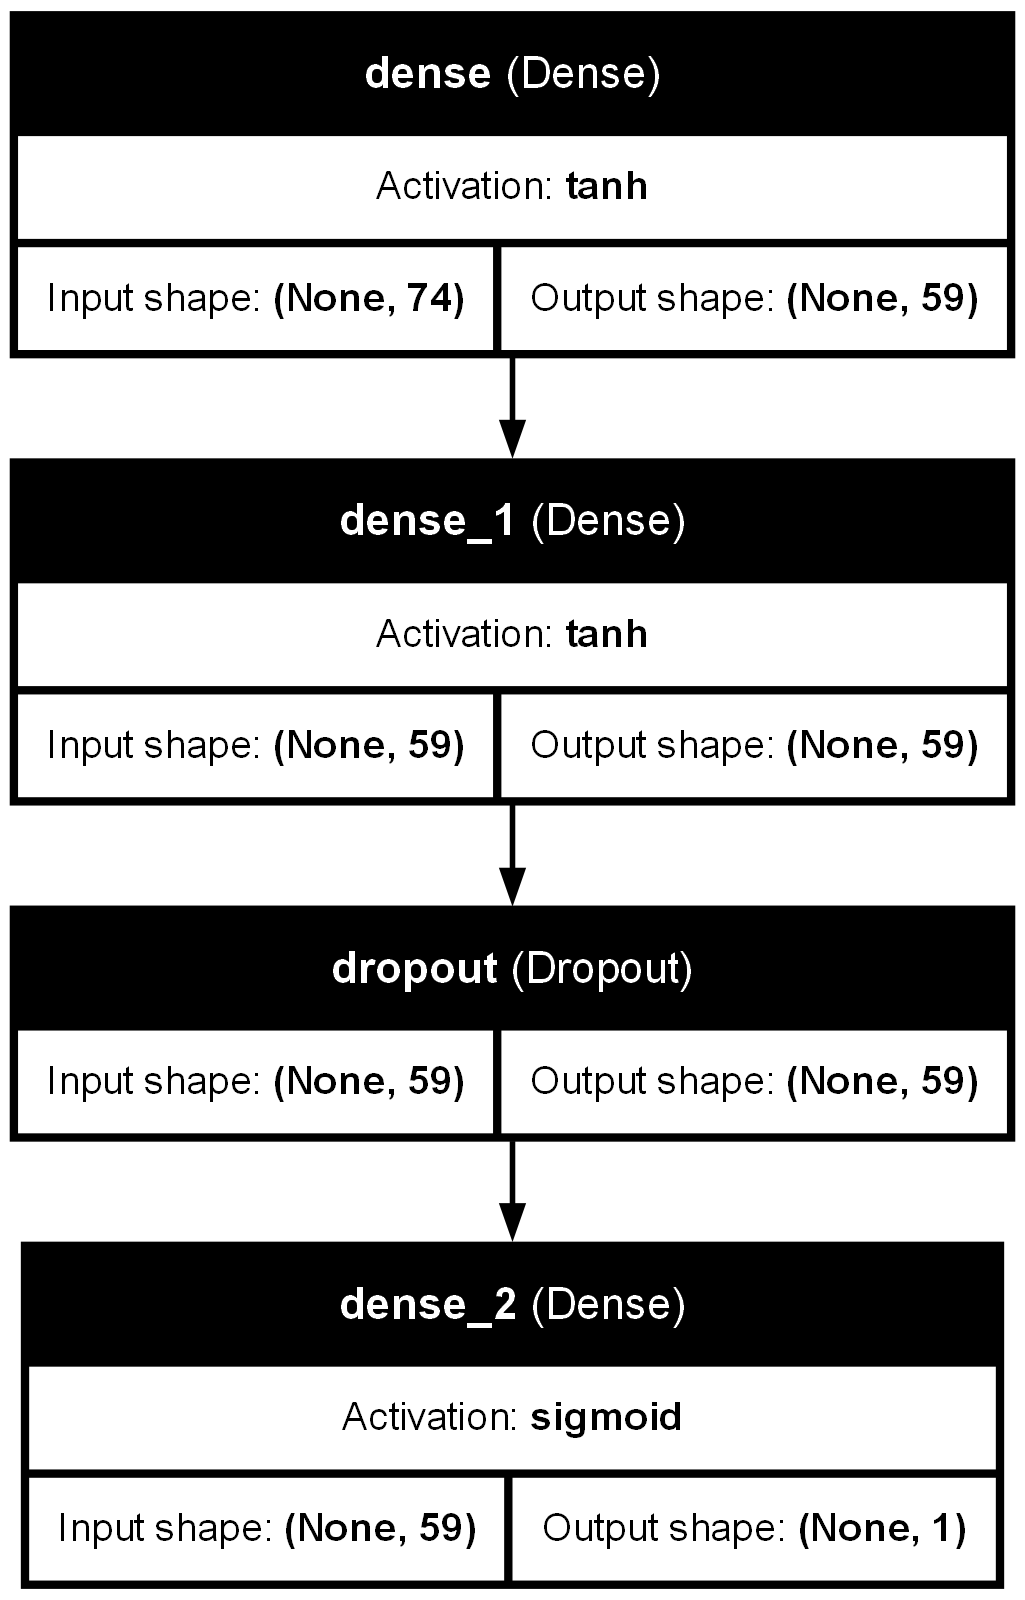

In [ ]:
# 21. Plot model diagram
plot_model(final_model, to_file='NN3.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [4]:
# 22. Check inference speed on test set
%timeit -r 10 -n 100 y_test_pred_prob = final_model.predict(X_test_processed)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
77/77 ━━━━━━━━━━